# Notebook to evaluate characteristics of individual anomaly trajectories


Main difference to evaluation in `evaluate_scores.iypnb`: there we performed a population view taking into account all samples that we have, here it is an individual trajectory perspective. This individual trajectory perspective yields a much smaller sample size due to the restriction that each analyzed trajectory must have a microbial sample in 3 months preceding abx exposure (at -1.0) as well as at least one sample after exposure:

| n | 1 |2 |
|----------|----------|----------|
| # infants     | 49 |30 |
| # infants w score increased + w/o | 22 + 27 |12 + 17 |

As contrast, sample size in population view performed in `evaluate_scores.iypnb`:

| Characteristic | n = 1 | n = 2 |
|-----------------|--------|--------|
| **ABX Duration** |        |        |
| < 7 days        | 39     | 31     |
| ≥ 7 days        | 51     | 53     |
| **Age**         |        |        |
| < 12 months     | 75     | 35     |
| 12-24 months    | 34     | 38     |

To run this notebook you need to create and activate the following conda environment:

```
conda create --name score_eval -c conda-forge -c defaults numpy pandas matplotlib seaborn scipy scikit-learn ipython ipykernel -y
conda activate score_eval
pip install -e .
```

## Setup

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency, mannwhitneyu

from src.utils_eval_score import (
    _plot_score_after_nth_abx_exposure,
    _select_samples_around_nth_abx_exposure,
    get_scores_n_abx_info,
    plot_trajectory,
)

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams.update({"font.family": "DejaVu Sans"})
plt.style.use("tableau-colorblind10")

warnings.filterwarnings("ignore", category=FutureWarning)
# avg. number of days per month
DAYS_PER_MONTH = 30.437

USER input: define the inferred model and linked datasets to evaluate here:

In [2]:
#### USER INPUT START
# name of the model
model_name = "saved_models_microbial_novel_alpha_div2/id-57"
# which model version to evaluate: "best" or "last"
point_to_evaluate = "best"

# name of feature dataset used for model
ft_name = "ft_vat19_anomaly_v20240806_entero_genus"
# name of abx time-series used for model
abx_ts_name = "ts_vat19_abx_v20240806"

# limit evaluation to time range up to this many months (if None no limit is set
# and all scores are evaluated)
limit_months = 24.0

# whether to group samples prior to abx exposure in analysis
group_samples = True

# ! which abx exposure to analyse in this notebook
n = 2

# ! how many samples prior and after abx exposure to consider
min_samples = -3.0
# 3.0 for n=1, 4.0 for n=2
max_samples = 3.0  

# whether to filter noabx score samples by having at least 1 obs prior to cutoff
no_filter = True

# whether to display diet info after 1st, 2nd, 3rd abx exposure plots
display_diet_info = True

# whether to have max. resolution of 0.5 months or not
max_resolution = False

# scaling factor options:
scaling_factors_used = True

# if scaling_factors_used is True, then the following options are required:
# non-centered = "nc_std" or centered = "std"
stddev_type = "nc_std"
# moving average window size: 30 or 10
moving_avg = 10
# whether to remove duplicates: "--RD-True" or "--RD-False"
duplicates = "--RD-True"
# using lower bound of 1 for SFs: "lower_bound-1" or ""
lower_bound = ""

#### USER INPUT END

## Prepare data

In [3]:
base_path = f"../data/{model_name}/anomaly_detection/"

res_n_group = f"g{str(group_samples)[0]}_maxres{str(max_resolution)[0]}"

if scaling_factors_used:
    print("Scaling factors used.")
    folder_name = f"using-SF_{stddev_type}_z_scores--moving_avg-{moving_avg}-cummax{lower_bound}{duplicates}"

    scores_path = f"{base_path}scores_{point_to_evaluate}_normal/{folder_name}/"
    evaluation_path = f"{base_path}evaluation_{point_to_evaluate}_overall_{res_n_group}_{stddev_type}_ma{moving_avg}{duplicates.replace('-', '_').lower()}/"
else:
    scores_path = f"{base_path}scores_{point_to_evaluate}_normal/"
    evaluation_path = (
        f"{base_path}evaluation_{point_to_evaluate}_overall_{res_n_group}_no_scaling/"
    )
if not os.path.exists(evaluation_path):
    os.makedirs(evaluation_path)


Scaling factors used.


In [4]:
noabx_train, noabx_val, abx_scores_flat, abx_df, abx_age_at_all = get_scores_n_abx_info(
    scores_path, ft_name, limit_months, abx_ts_name, no_filter=no_filter
)


In [5]:
abx_events = pd.DataFrame()
abx_events["host_id"] = abx_scores_flat["host_id"].unique()
abx_events = pd.merge(abx_events, abx_df, on="host_id", how="left")

## Trajectories with large vs. no increase after abx

In [6]:
# SELECT & PREPARE SAMPLES
score_col = f"score_{n}"

scores_abx_nth_samples = _select_samples_around_nth_abx_exposure(
    abx_scores_flat,
    abx_df,
    n=n,
    min_samples=min_samples,
    max_samples=max_samples,
    group_samples=group_samples,
    score_var=score_col,
    max_resolution=max_resolution,
)

scores_abx_nth_samples.drop(
    columns=[
        "abx",
        "score_0",
        "div_alpha_observed_features",
        "div_alpha_faith_pd",
        "div_alpha_shannon",
        "max_abx_w_microbiome",
        "abx_max_count_ever",
    ],
    inplace=True,
)

# select only samples that have a -1 score
hosts_w_prior_sample = scores_abx_nth_samples[
    scores_abx_nth_samples["diff_age_nth_abx"] == -1.0
].host_id.unique()
len(hosts_w_prior_sample)

print(scores_abx_nth_samples.shape)
scores_abx_nth_samples = scores_abx_nth_samples[
    scores_abx_nth_samples.host_id.isin(hosts_w_prior_sample)
]
print(scores_abx_nth_samples.shape)

(117, 18)
(93, 18)


In [7]:
# Compute relative score: max score in 3 or 4 months after abx exposure
scores_abx_nth_samples = (
    scores_abx_nth_samples.groupby("host_id")
    .apply(
        lambda x: x.assign(
            score_rel_change_1=x[score_col] / x[score_col].shift(1),
            score_rel_change_2=x[score_col] / x[score_col].shift(2),
            score_rel_change_3=x[score_col] / x[score_col].shift(3),
            score_rel_change_4=x[score_col] / x[score_col].shift(4),
        ),
        include_groups=False,
    )
    .reset_index()
)
scores_abx_nth_samples.drop(columns="level_1", inplace=True)

if n == 1:
    scores_abx_nth_samples.drop(columns="score_rel_change_4", inplace=True)

# Identify all columns relevant to score_rel_change
rel_change_cols = [
    col for col in scores_abx_nth_samples.columns if col.startswith("score_rel_change_")
]
# Select those columns, forward-fill each row, and pick the last non-NaN entry
scores_abx_nth_samples["score_rel_change"] = (
    scores_abx_nth_samples[rel_change_cols]
    .ffill(axis=1)  # fill forward along each row
    .iloc[:, -1]  # take the rightmost (last) non-NaN value
)
df_max_rel_change = (
    scores_abx_nth_samples.groupby("host_id", as_index=False)["score_rel_change"]
    .max()
    .rename(columns={"score_rel_change": "max_score_rel_change"})
)
df_max_rel_change.dropna(inplace=True)

print(
    f"Number of unique infants with quantifiable rel score change: {df_max_rel_change.host_id.nunique()}"
)

Number of unique infants with quantifiable rel score change: 29


In [8]:
scores_abx_nth_samples["months_since_last_prior_sample"] = (
    scores_abx_nth_samples["age_nth_abx"] - scores_abx_nth_samples["month5_bin"]
)

scores_abx_nth_samples[
    [
        "host_id",
        "diff_age_nth_abx",
        "age_nth_abx",
        "month5_bin",
        "months_since_last_prior_sample",
    ]
]

host_id  diff_age_nth_abx  age_nth_abx  month5_bin  \
0   E003188              -1.0          7.0         6.5   
1   E003188               0.0          7.0         7.5   
2   E003188               1.0          7.0         8.5   
3   E003188               2.0          7.0         9.5   
4   E003953              -1.0         10.0         9.0   
..      ...               ...          ...         ...   
88  T012312              -1.0         15.0        13.0   
89  T012312               2.0         15.0        17.5   
90  T012977              -1.0         24.0        22.5   
91  T024121              -1.0         12.0        10.5   
92  T025415              -1.0         23.0        22.0   

    months_since_last_prior_sample  
0                              0.5  
1                             -0.5  
2                             -1.5  
3                             -2.5  
4                              1.0  
..                             ...  
88                             2.0  
89                            -2.5  
90                             1.5  
91                             1.5  
92                             1.0  

[93 rows x 5 columns]

In [9]:
# adjust gastroenteritis
scores_abx_nth_samples["gastroenteritis"] = "Others"
scores_abx_nth_samples.loc[
    scores_abx_nth_samples["abx_reason"] == "Gastroenteritis", "gastroenteritis"
] = "Gastroenteritis"

display(scores_abx_nth_samples["gastroenteritis"].value_counts(dropna=False))

# adjust diet_milk
display(scores_abx_nth_samples["diet_milk"] .value_counts(dropna=False))
scores_abx_nth_samples["diet_milk_g"] = scores_abx_nth_samples["diet_milk"]
bd_exposed = ["bd", "mixed"]
scores_abx_nth_samples.loc[
    scores_abx_nth_samples["diet_milk"].isin(bd_exposed), "diet_milk_g"
] = "bd_or_mixed"
scores_abx_nth_samples["diet_milk_g"] .value_counts(dropna=False)

gastroenteritis
Others             89
Gastroenteritis     4
Name: count, dtype: int64

diet_milk
None     57
mixed    27
fd        5
bd        4
Name: count, dtype: int64

diet_milk_g
None           57
bd_or_mixed    31
fd              5
Name: count, dtype: int64

In [10]:
# get abx duration for these infants
df_duration = scores_abx_nth_samples.groupby("host_id", as_index=False)[
    "abx_any_last_dur_days"
].last()
df_duration.dropna(inplace=True)

df_rel_change = pd.merge(df_max_rel_change, df_duration, on="host_id", how="left")
print(
    f"Number of unique infants with quantifiable rel score change + abx duration: {df_rel_change.host_id.nunique()}"
)

# get all other characteristics in -1 bin before abx exposure
characteristics_numeric = ["month5_bin", f"score_{n}", "months_since_last_prior_sample"]

characteristics_cat = [
    "diet_milk_g",
    "diet_weaning",
    "delivery_mode",
    "abx_reason",
    "gastroenteritis",
    "abx_type",
]

cols_to_select = ["host_id"] + characteristics_numeric + characteristics_cat
df_charc = scores_abx_nth_samples.loc[
    scores_abx_nth_samples["diff_age_nth_abx"] == -1.0, cols_to_select
]

df_rel_change_final = pd.merge(df_rel_change, df_charc, on="host_id", how="left")
print(
    f"Number of unique infants with quantifiable rel score change + abx duration + chars: {df_rel_change_final.host_id.nunique()}"
)

# transform categoricals to proper categoricals:
for cat in characteristics_cat:
    df_rel_change_final[cat] = df_rel_change_final[cat].astype("category")

df_rel_change_final.head()

Number of unique infants with quantifiable rel score change + abx duration: 29
Number of unique infants with quantifiable rel score change + abx duration + chars: 29


host_id  max_score_rel_change  abx_any_last_dur_days  month5_bin   score_2  \
0  E003188              2.454824                    7.0         6.5  0.964095   
1  E004628              0.487022                    7.0         7.0  2.337792   
2  E004898            106.951751                    7.0         5.5  0.010308   
3  E005786              3.015982                    5.0        12.0  0.526360   
4  E006091              0.429890                    7.0        13.0  1.160912   

   months_since_last_prior_sample  diet_milk_g diet_weaning delivery_mode  \
0                             0.5  bd_or_mixed          yes       vaginal   
1                             0.5          NaN          yes      cesarean   
2                             1.5  bd_or_mixed          yes       vaginal   
3                             1.0          NaN          yes       vaginal   
4                             1.0          NaN          yes       vaginal   

     abx_reason gastroenteritis        abx_type  
0  Otitis media          Others           Other  
1  Otitis media          Others  Cephalosporine  
2  Otitis media          Others           Other  
3  Otitis media          Others   Cotrimoxazole  
4  Otitis media          Others           Other

In [11]:
# DEFINE GROUPS
# thresh = df_rel_change_final["max_score_rel_change"].quantile(0.75)
# print(thresh)
thresh = 2.0

rel_increase = df_rel_change_final.loc[
    df_rel_change_final["max_score_rel_change"] >= thresh
]
print(rel_increase.host_id.nunique())

rel_no_increase = df_rel_change_final.loc[
    df_rel_change_final["max_score_rel_change"] < thresh
]
print(rel_no_increase.host_id.nunique())

12
17


In [12]:
characteristics_numeric += ["abx_any_last_dur_days"]

In [13]:
# Describe CHARACTERISTICS
results_df = pd.DataFrame()

# Aggregate results for each group
for label, group in [
    ("increase", rel_increase),
    ("no_increase", rel_no_increase),
]:
    # nb infants
    nb_infants = group.host_id.nunique()
    results_df.loc[label, "nb_infants"] = nb_infants

    # Summaries for numeric columns
    for c in characteristics_numeric:
        stats = group[c].describe()
        mean_val = round(stats["mean"], 2)
        std_val = round(stats["std"], 2)
        results_df.loc[label, c] = f"{mean_val} ± {std_val}"

    # Fractions for each category value
    for cat in characteristics_cat:
        cat_counts = group[cat].value_counts(dropna=False)
        for val, cnt in cat_counts.items():
            fraction = round(cnt / nb_infants, 2)
            results_df.loc[label, f"{cat}_{val}"] = fraction
display(results_df)


nb_infants   month5_bin      score_2  \
increase           12.0  9.96 ± 4.76  0.38 ± 0.34   
no_increase        17.0  12.06 ± 4.9  1.48 ± 0.72   

            months_since_last_prior_sample abx_any_last_dur_days  \
increase                       1.54 ± 0.89            6.67 ± 1.5   
no_increase                    1.68 ± 0.85           7.06 ± 2.61   

             diet_milk_g_bd_or_mixed  diet_milk_g_nan  diet_milk_g_fd  \
increase                        0.50             0.42            0.08   
no_increase                     0.35             0.59            0.06   

             diet_weaning_yes  diet_weaning_no  ...  gastroenteritis_Others  \
increase                 0.92             0.08  ...                    0.92   
no_increase              1.00             0.00  ...                    1.00   

             gastroenteritis_Gastroenteritis  abx_type_Other  \
increase                                0.08            0.42   
no_increase                             0.00            0.06   

             abx_type_Cephalosporine  abx_type_Macrolide  \
increase                        0.17                0.17   
no_increase                     0.12                0.06   

             abx_type_Cephalosporine, Macrolide  abx_type_Penicillin  \
increase                                   0.08                 0.08   
no_increase                                0.00                 0.53   

             abx_type_Cotrimoxazole  abx_type_Cephalosporine, Penicillin  \
increase                       0.08                                 0.00   
no_increase                    0.12                                 0.06   

             abx_type_Other, Penicillin  
increase                           0.00  
no_increase                        0.06  

[2 rows x 26 columns]

In [14]:
# STATISTICAL TESTS for characteristics
sign_numeric_df = pd.DataFrame()

# Mann-Whitney U for numeric columns
for c in characteristics_numeric:
    inc_vals = rel_increase[c].dropna()
    no_inc_vals = rel_no_increase[c].dropna()
    stat, p_val = mannwhitneyu(inc_vals, no_inc_vals, alternative="two-sided")
    sign_numeric_df.loc[c, "statistic"] = round(stat, 4)
    sign_numeric_df.loc[c, "p-value"] = p_val

# Chi-square for categorical columns
sign_cat_df = pd.DataFrame()
for cat in characteristics_cat:
    inc_c = rel_increase[cat].dropna().value_counts()
    no_c = rel_no_increase[cat].dropna().value_counts()
    contingency = pd.DataFrame([inc_c, no_c], index=["increase", "no_increase"]).fillna(
        0
    )
    chi2, p_val, dof, expected = chi2_contingency(contingency)
    sign_cat_df.loc[cat, "chi2_statistic"] = round(chi2, 4)
    sign_cat_df.loc[cat, "p-value"] = p_val

print("\nNumeric Significance Results:")
print(sign_numeric_df)
print("\nCategorical Significance Results:")
print(sign_cat_df)


Numeric Significance Results:
                                statistic   p-value
month5_bin                           75.5  0.248675
score_2                               9.0  0.000042
months_since_last_prior_sample       91.5  0.650534
abx_any_last_dur_days                94.5  0.740772

Categorical Significance Results:
                 chi2_statistic   p-value
diet_milk_g              0.0000  1.000000
diet_weaning             0.0317  0.858618
delivery_mode            0.2376  0.625955
abx_reason               2.2034  0.531273
gastroenteritis          0.0317  0.858618
abx_type                12.2350  0.093092


In [15]:
sign_numeric_df.loc[f"score_{n}", "p-value"]

np.float64(4.204064692494874e-05)

In [16]:
# ----------------------------
# CREATE SUBPLOTS
#   2 rows x 5 columns to accommodate 5 categorical variables (row 1)
#   and 2 numeric variables (row 2, columns 0 & 1 only)
# ----------------------------
n_rows = len(characteristics_numeric) + len(characteristics_cat)
fig, axs = plt.subplots(
    nrows=n_rows, ncols=1, figsize=(8, 20), dpi=600
)  # , sharex=True)
# fig.suptitle("Comparison of Characteristics for 'increase' vs. 'no_increase'", fontsize=12, y=1.02)

for idx, c in enumerate(characteristics_numeric):
    increase_vals = rel_increase[c].dropna()
    no_increase_vals = rel_no_increase[c].dropna()

    axs[idx].boxplot(
        [increase_vals, no_increase_vals], labels=["increase", "no_increase"]
    )
    axs[idx].set_ylabel(c)

# Stacked barplots for each categorical variable
for idx_cat, cat in enumerate(characteristics_cat):
    idx_cat_true = idx + idx_cat + 1
    cat_fraction_cols = [col for col in results_df.columns if col.startswith(cat + "_")]
    results_df[cat_fraction_cols].plot(
        kind="bar",
        stacked=True,
        ax=axs[idx_cat_true],
    )
    axs[idx_cat_true].set_ylabel(
        f"{cat} fractions",
    )
    # Remove the prefix for cleaner legend labels
    handles, labels = axs[idx_cat_true].get_legend_handles_labels()
    new_labels = [label.replace(cat + "_", "") for label in labels]
    axs[idx_cat_true].legend(
        handles, new_labels, title=cat, bbox_to_anchor=(1.05, 1), loc="upper left"
    )

# Remove x-axis ticks and labels from all subplots except the last one
for ax in axs[:-1]:
    ax.set_xlabel("")
    ax.set_xticklabels([])
for tick in axs[-1].get_xticklabels():
    tick.set_rotation(0)
plt.tight_layout()
plt.show()


/var/folders/k3/lydcv_vx7cb6tzmkf7k8xvsw0000gp/T/ipykernel_12502/71330760.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[idx].boxplot(
/var/folders/k3/lydcv_vx7cb6tzmkf7k8xvsw0000gp/T/ipykernel_12502/71330760.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[idx].boxplot(
/var/folders/k3/lydcv_vx7cb6tzmkf7k8xvsw0000gp/T/ipykernel_12502/71330760.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[idx].boxplot(
/var/folders/k3/lydcv_vx7cb6tzmkf7k8xvsw0000gp/T/ipykernel_12502/71330760.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplo

Saving plot to ../data/saved_models_microbial_novel_alpha_div2/id-57/anomaly_detection/evaluation_best_overall_gT_maxresF_nc_std_ma10__rd_true/score_after_abx2nd_relative_score_increase.pdf
Saving plot to ../data/saved_models_microbial_novel_alpha_div2/id-57/anomaly_detection/evaluation_best_overall_gT_maxresF_nc_std_ma10__rd_true/score_after_abx2nd_relative_score_no_increase.pdf


'../data/saved_models_microbial_novel_alpha_div2/id-57/anomaly_detection/evaluation_best_overall_gT_maxresF_nc_std_ma10__rd_true/score_after_abx2nd_relative_score_no_increase.pdf'

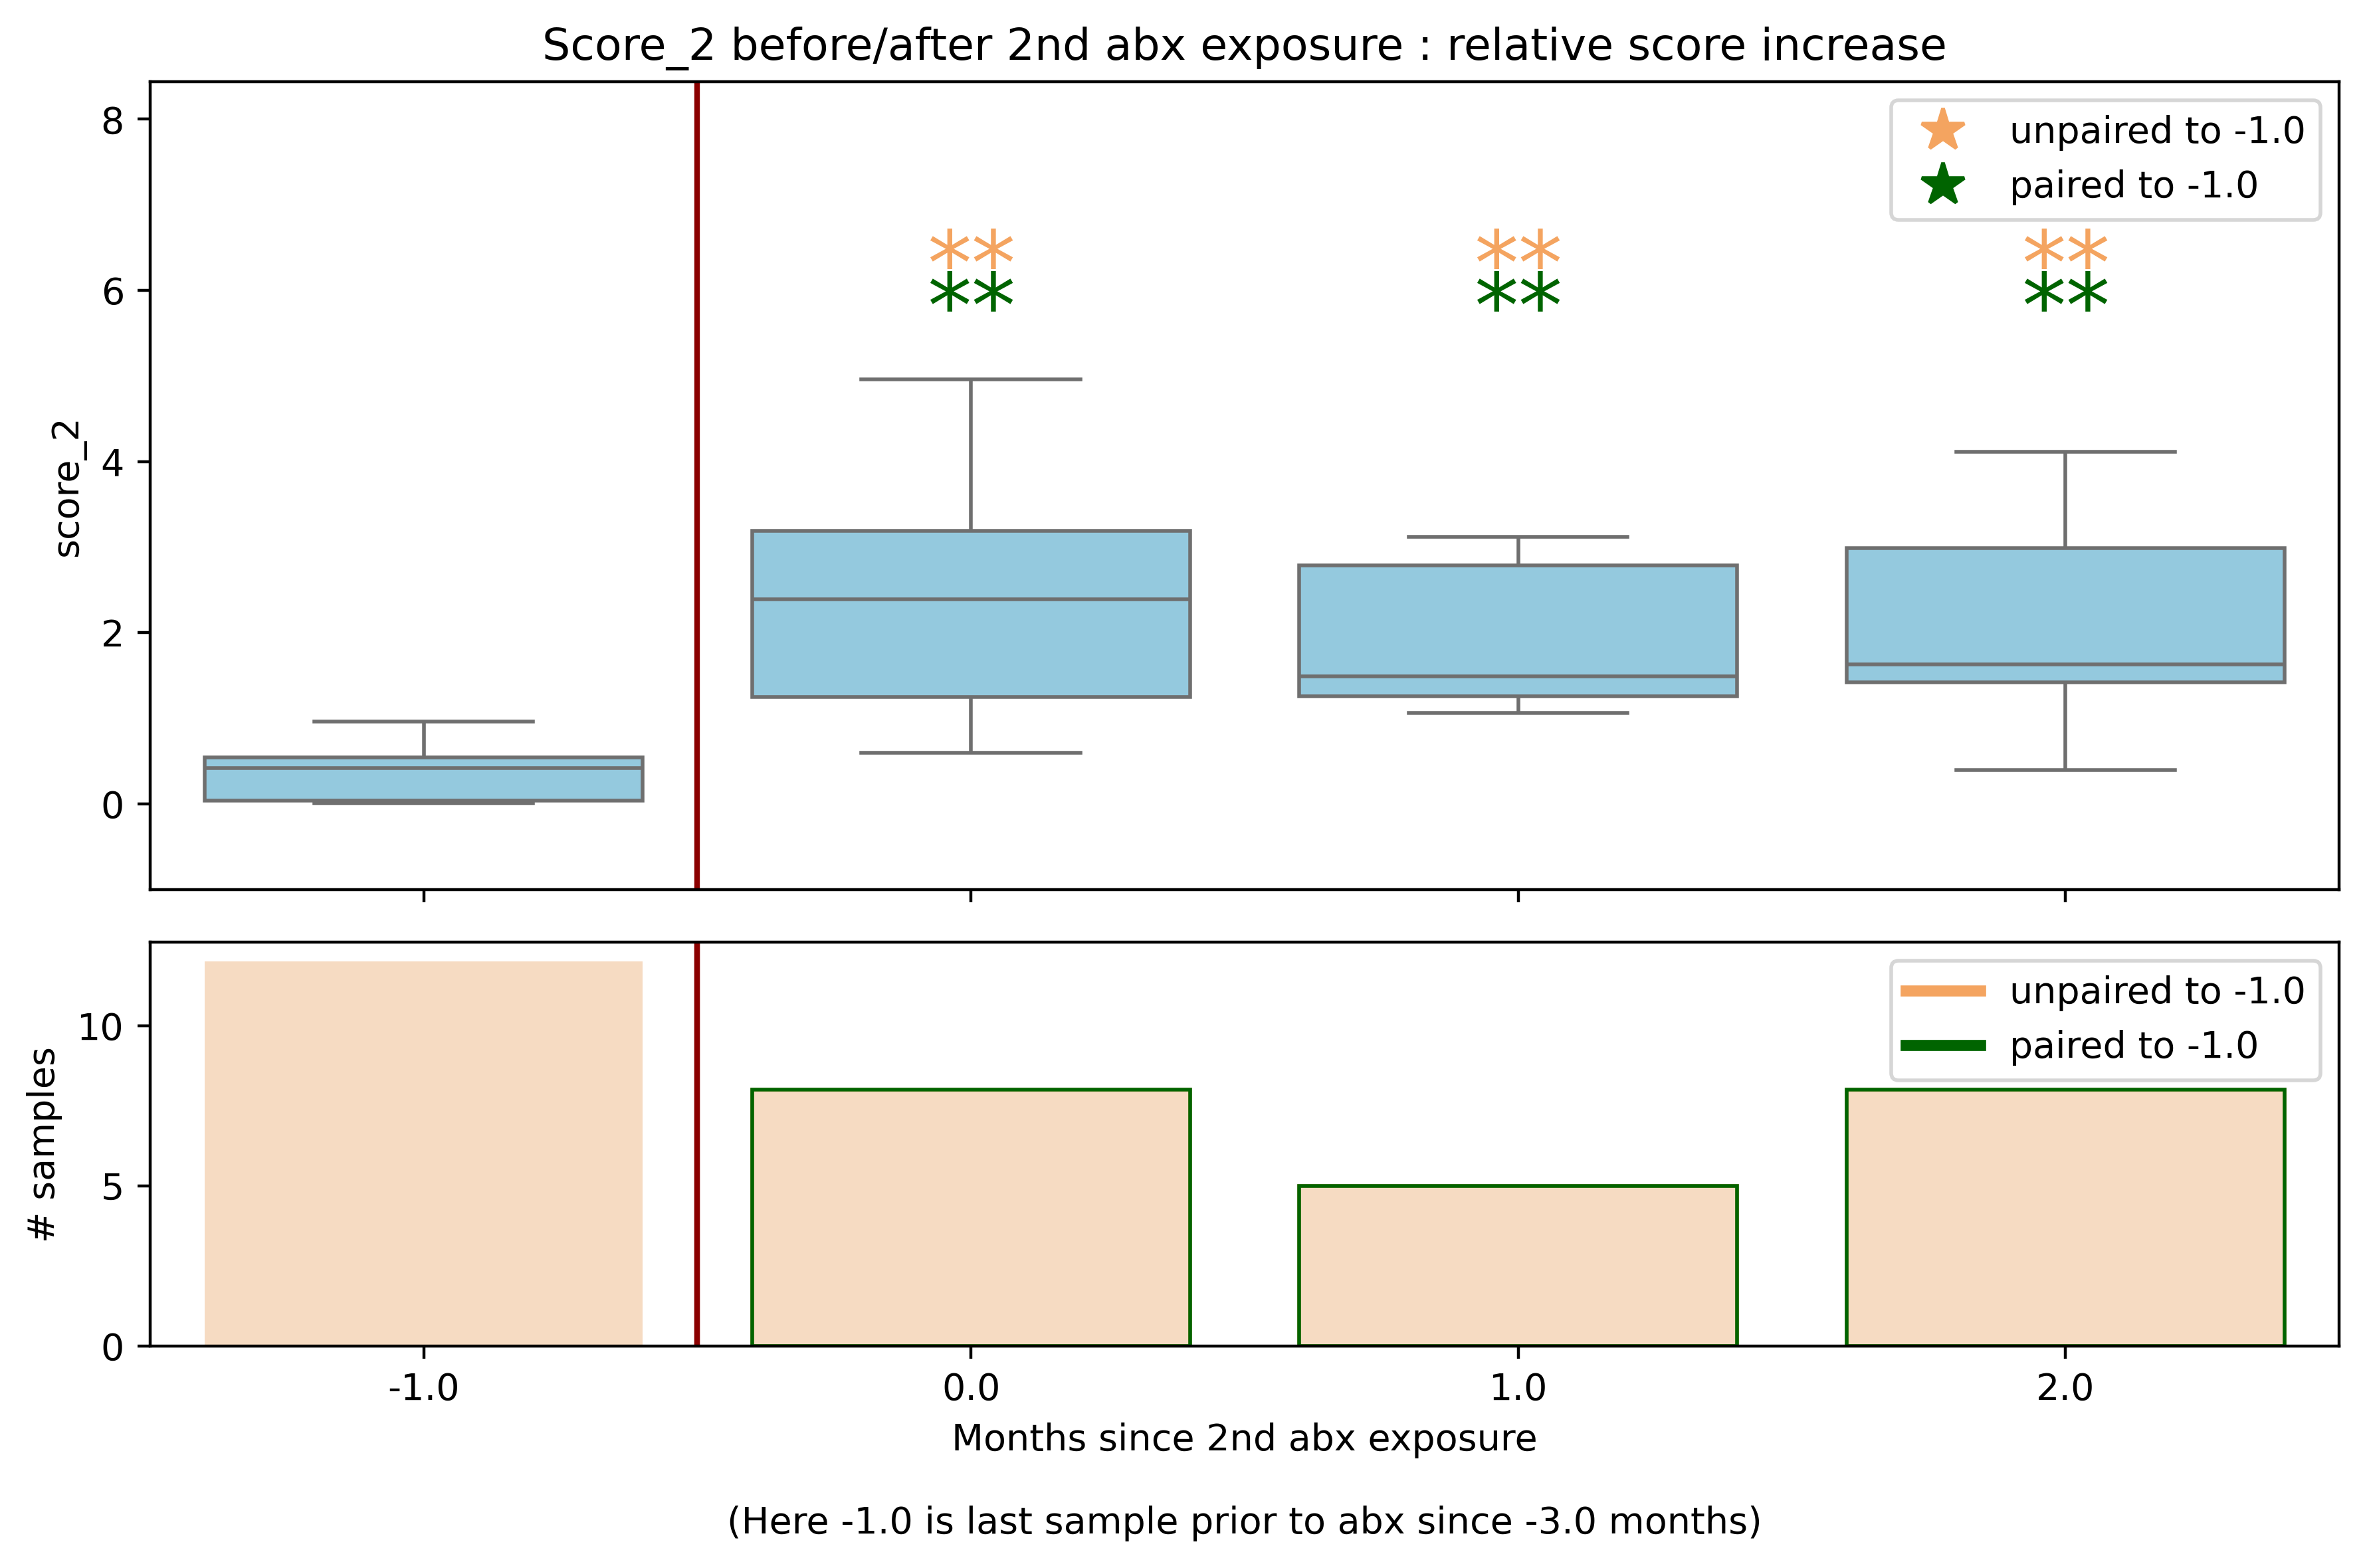

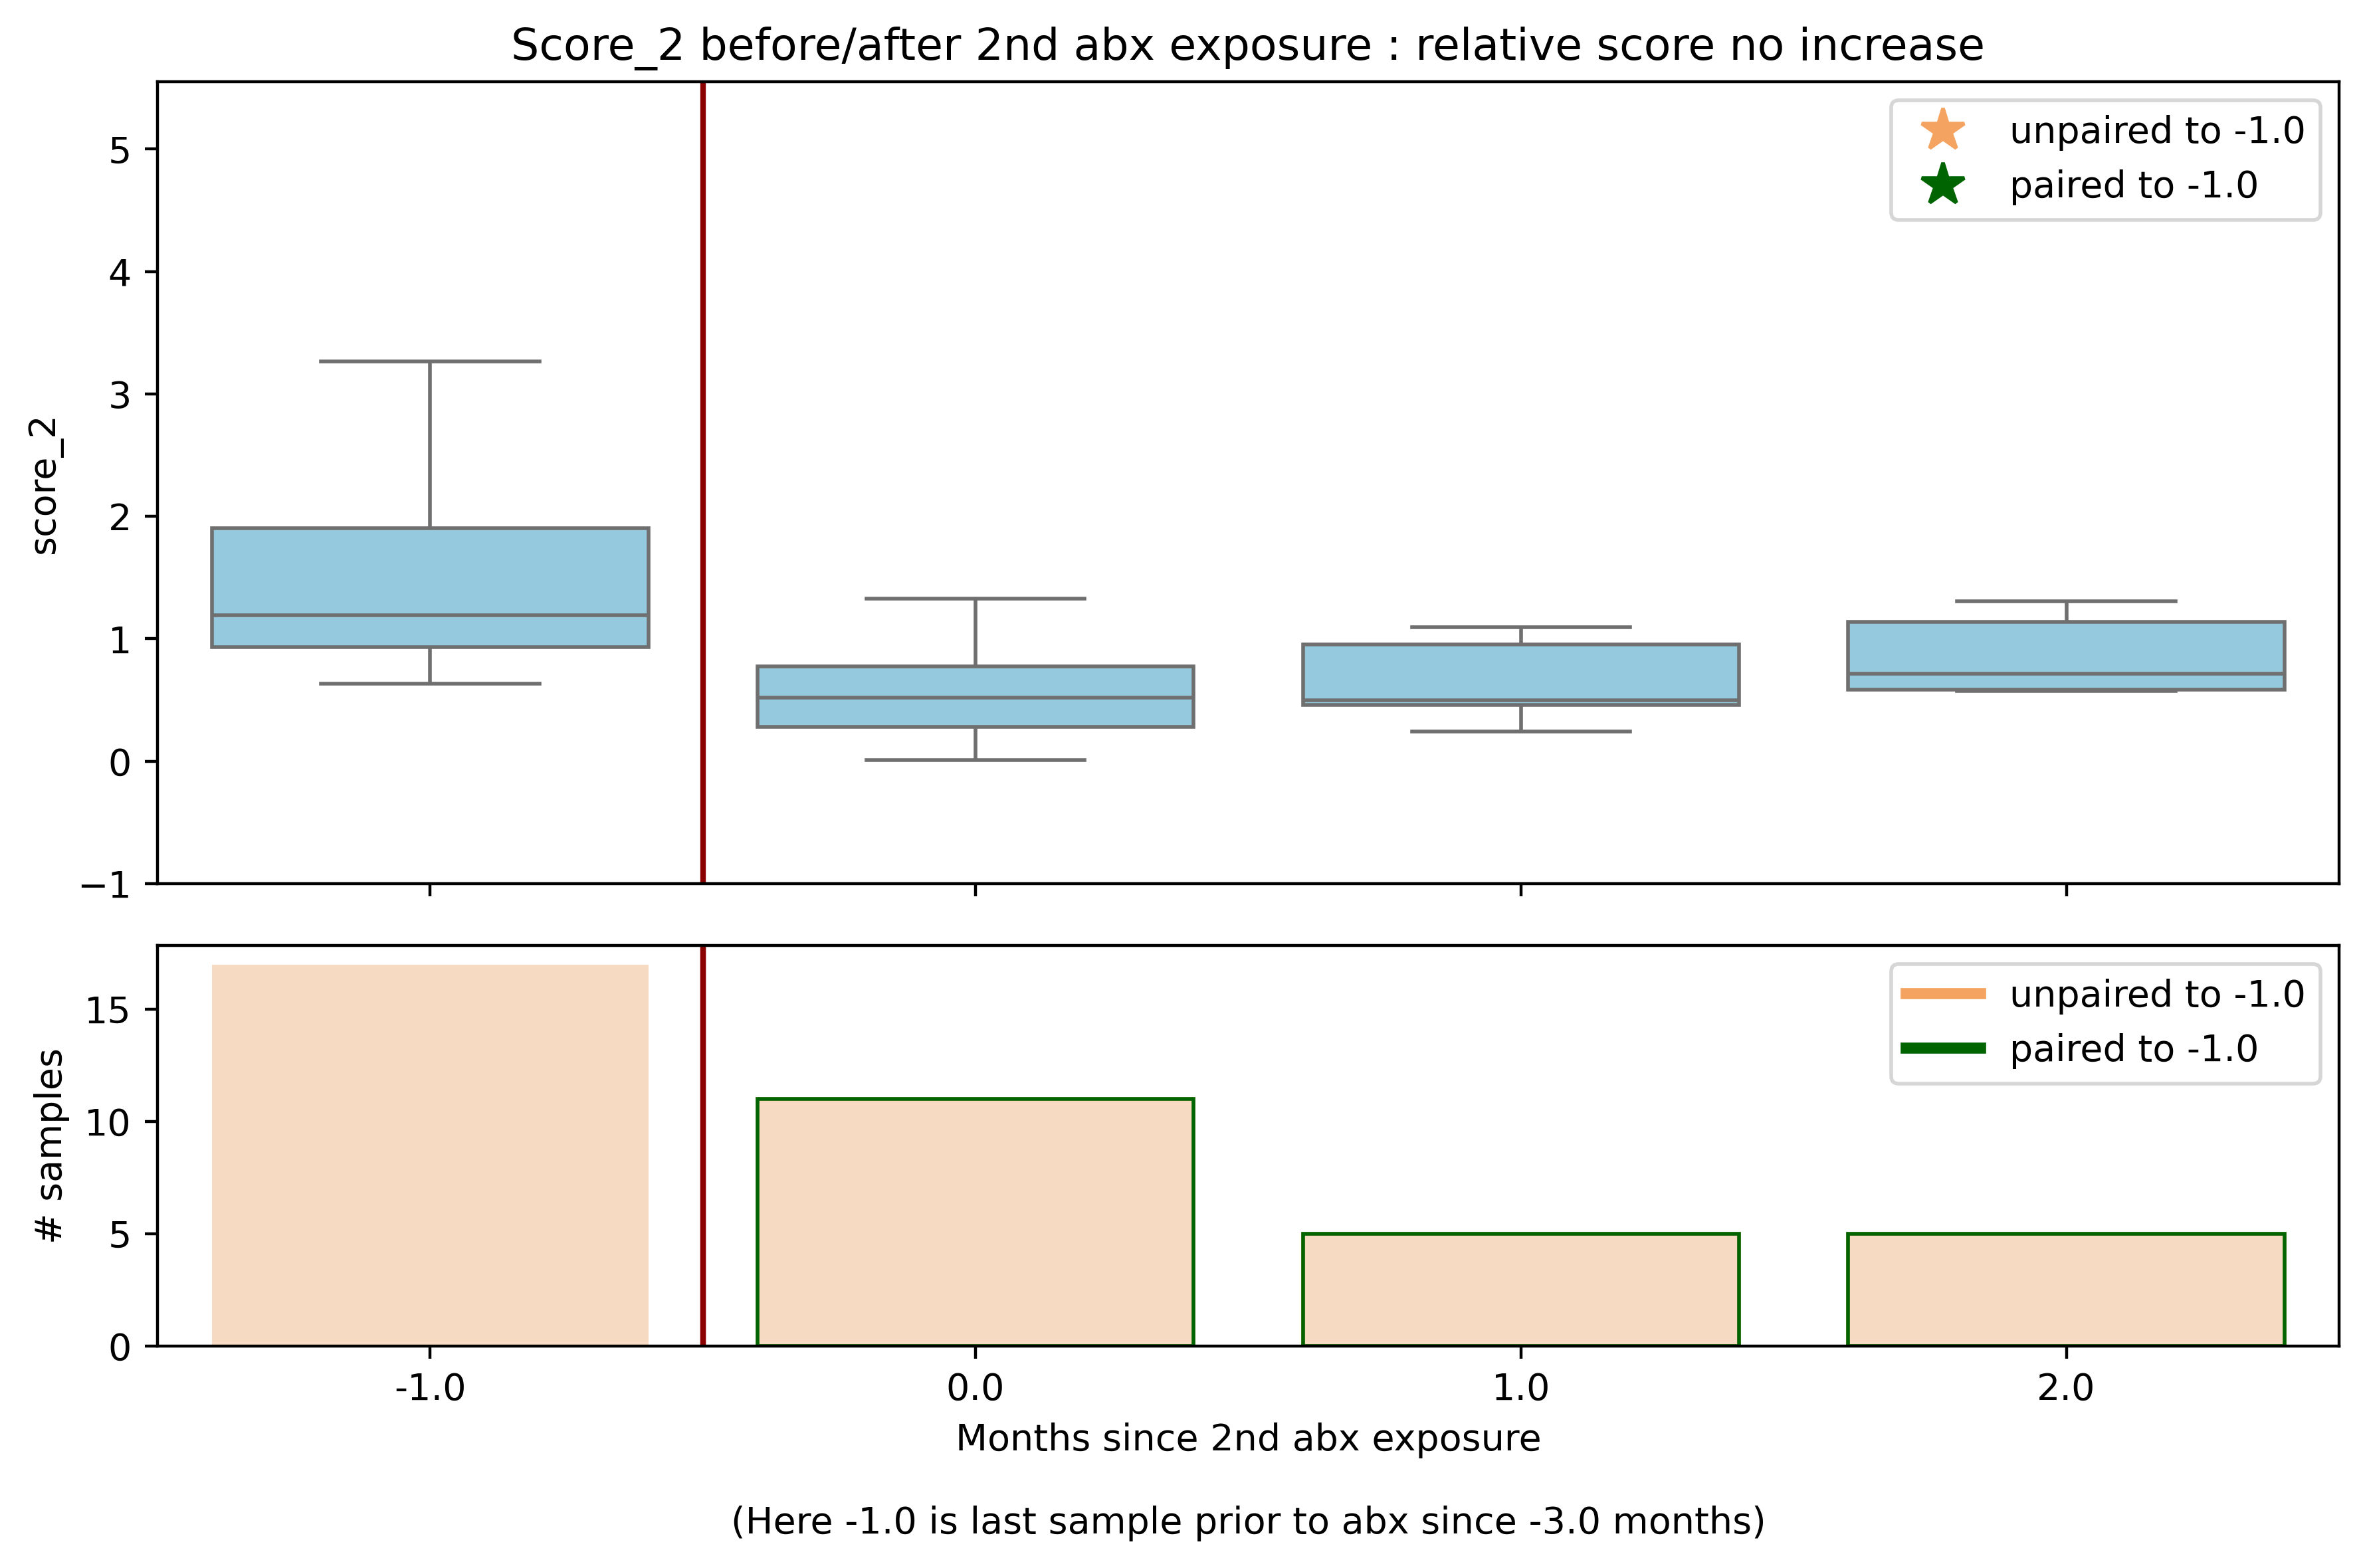

In [17]:
group_increase_scores = scores_abx_nth_samples.loc[
    scores_abx_nth_samples["host_id"].isin(rel_increase["host_id"])
]
_plot_score_after_nth_abx_exposure(
    group_increase_scores,
    x_axis="diff_age_nth_abx",
    y_axis=score_col,
    n=n,
    path_to_save=evaluation_path,
    flag="relative_score_increase",
    tag=": relative score increase",
    min_samples=min_samples,
    max_samples=max_samples,
    max_resolution=max_resolution,
    grouped_samples=group_samples,
)

group_no_increase_scores = scores_abx_nth_samples.loc[
    scores_abx_nth_samples["host_id"].isin(rel_no_increase["host_id"])
]
_plot_score_after_nth_abx_exposure(
    group_no_increase_scores,
    x_axis="diff_age_nth_abx",
    y_axis=score_col,
    n=n,
    path_to_save=evaluation_path,
    flag="relative_score_no_increase",
    tag=": relative score no increase",
    min_samples=min_samples,
    max_samples=max_samples,
    max_resolution=max_resolution,
    grouped_samples=group_samples,
)

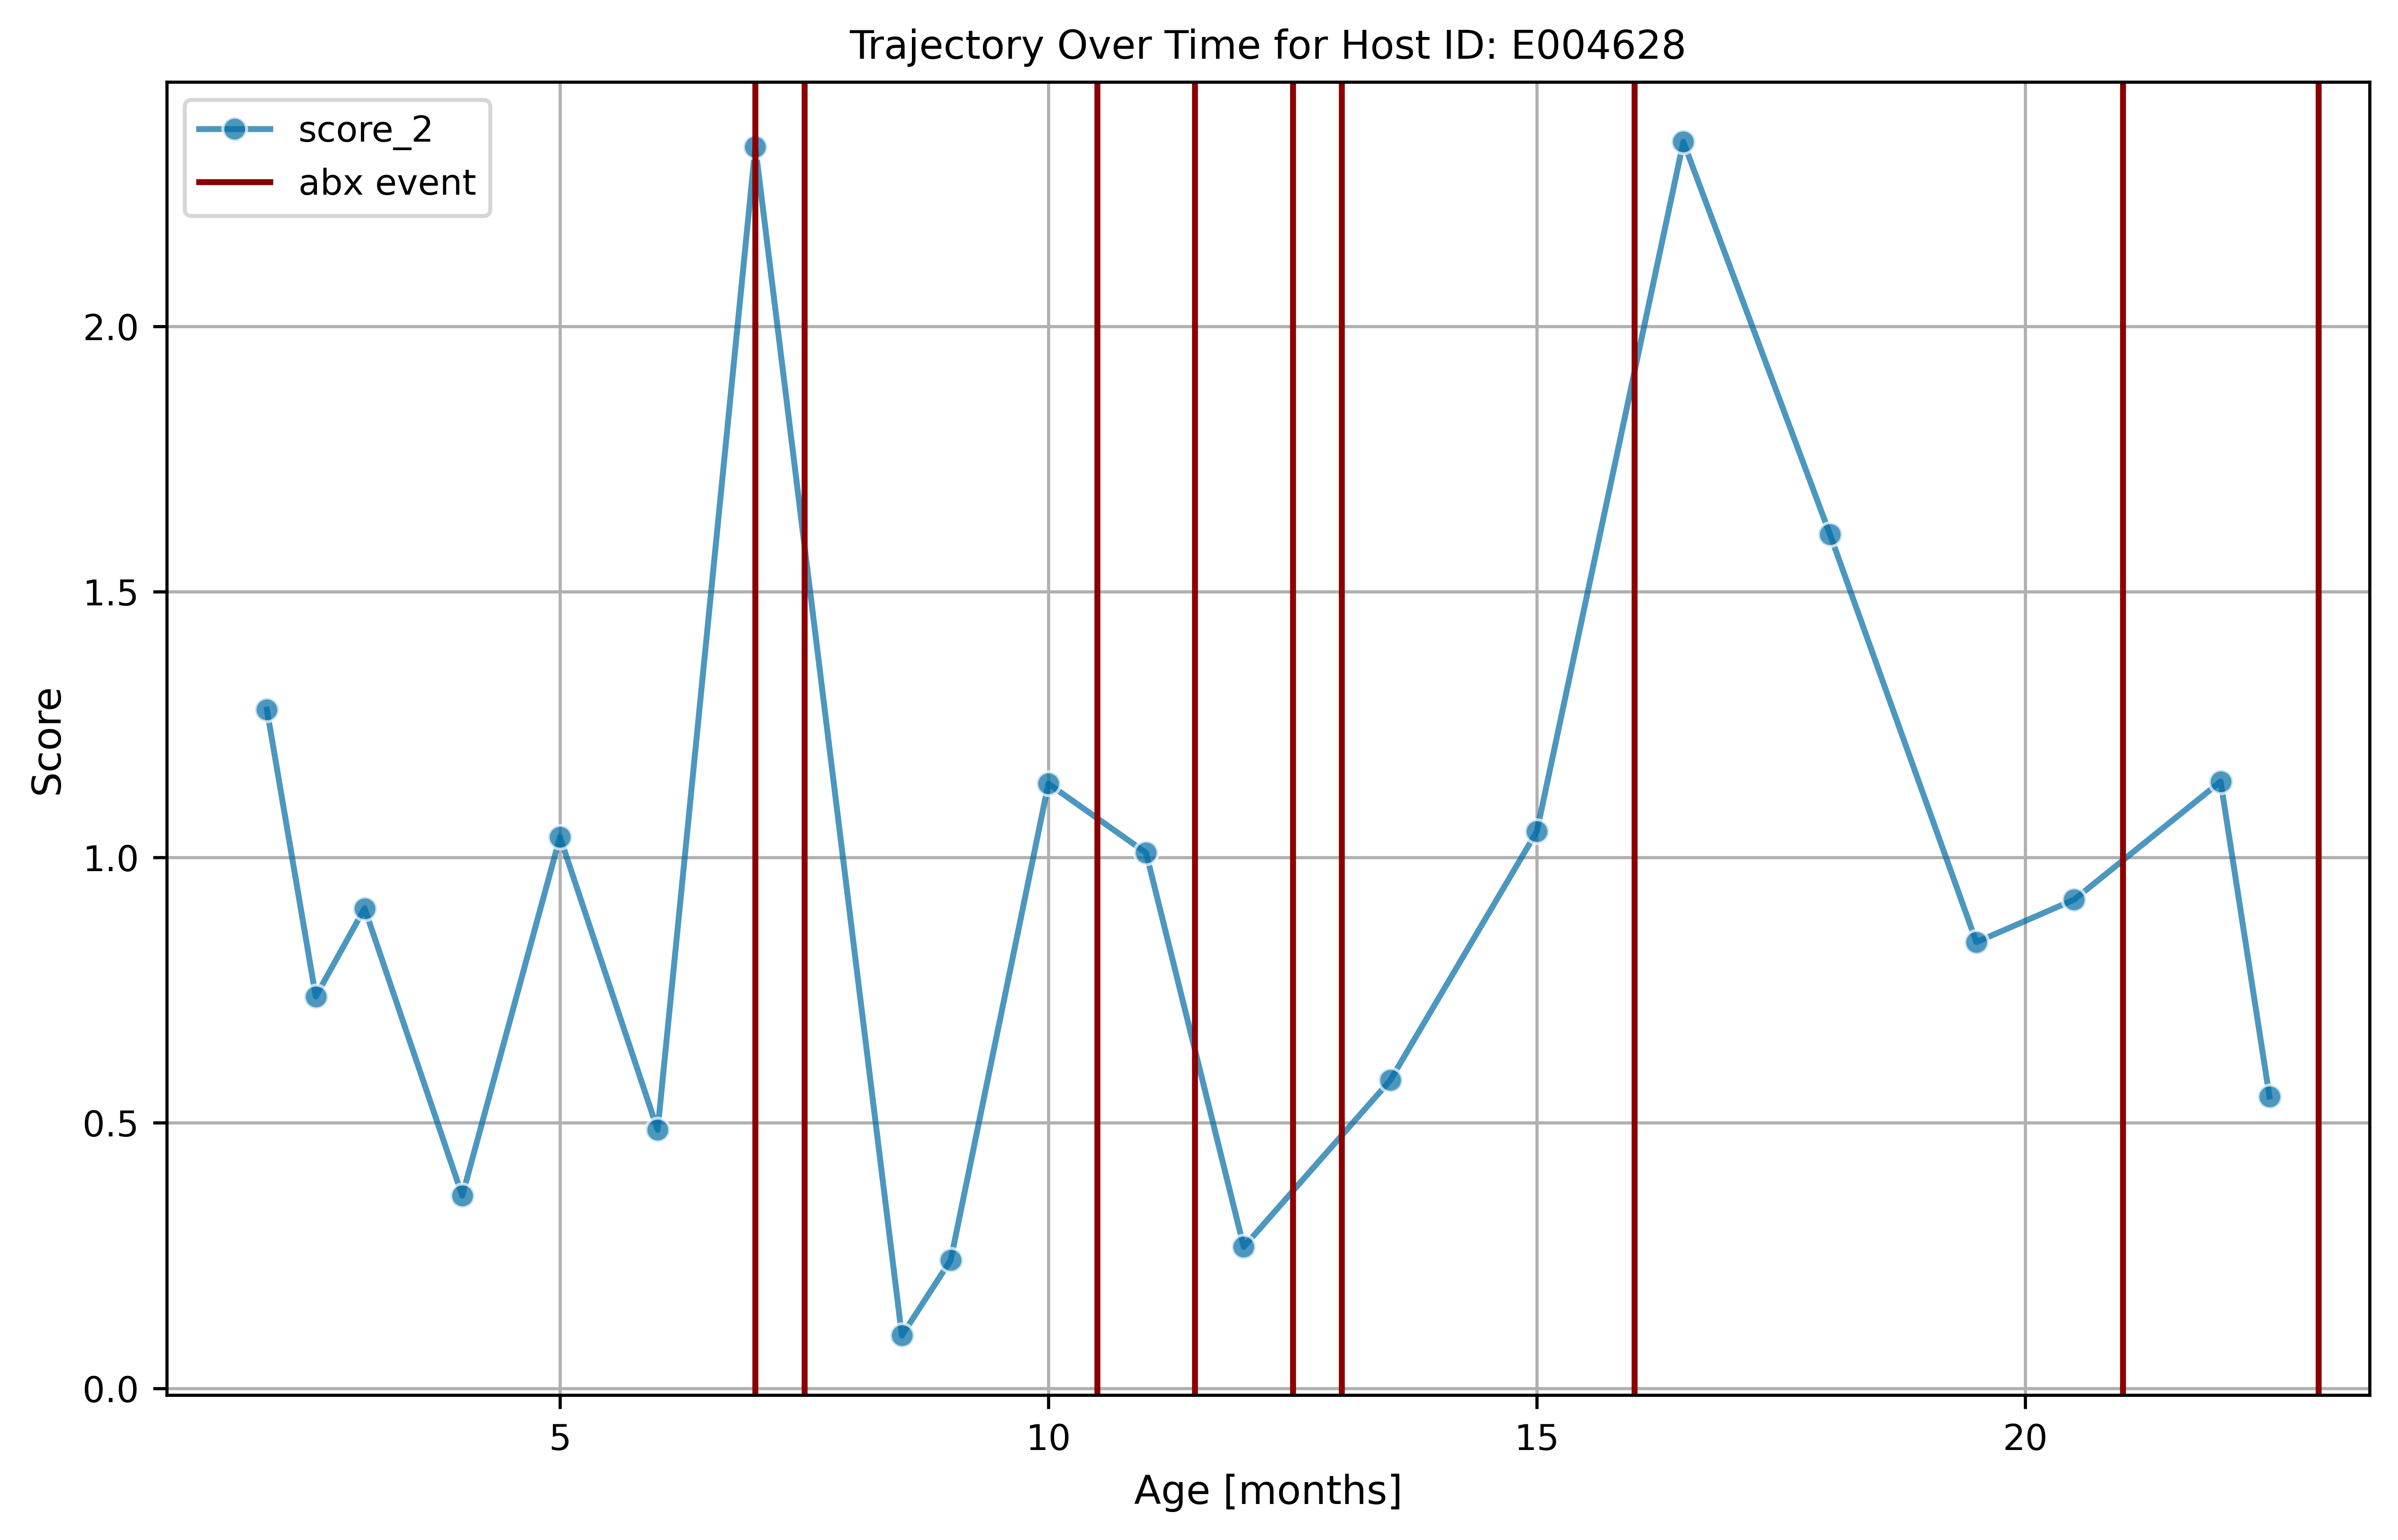

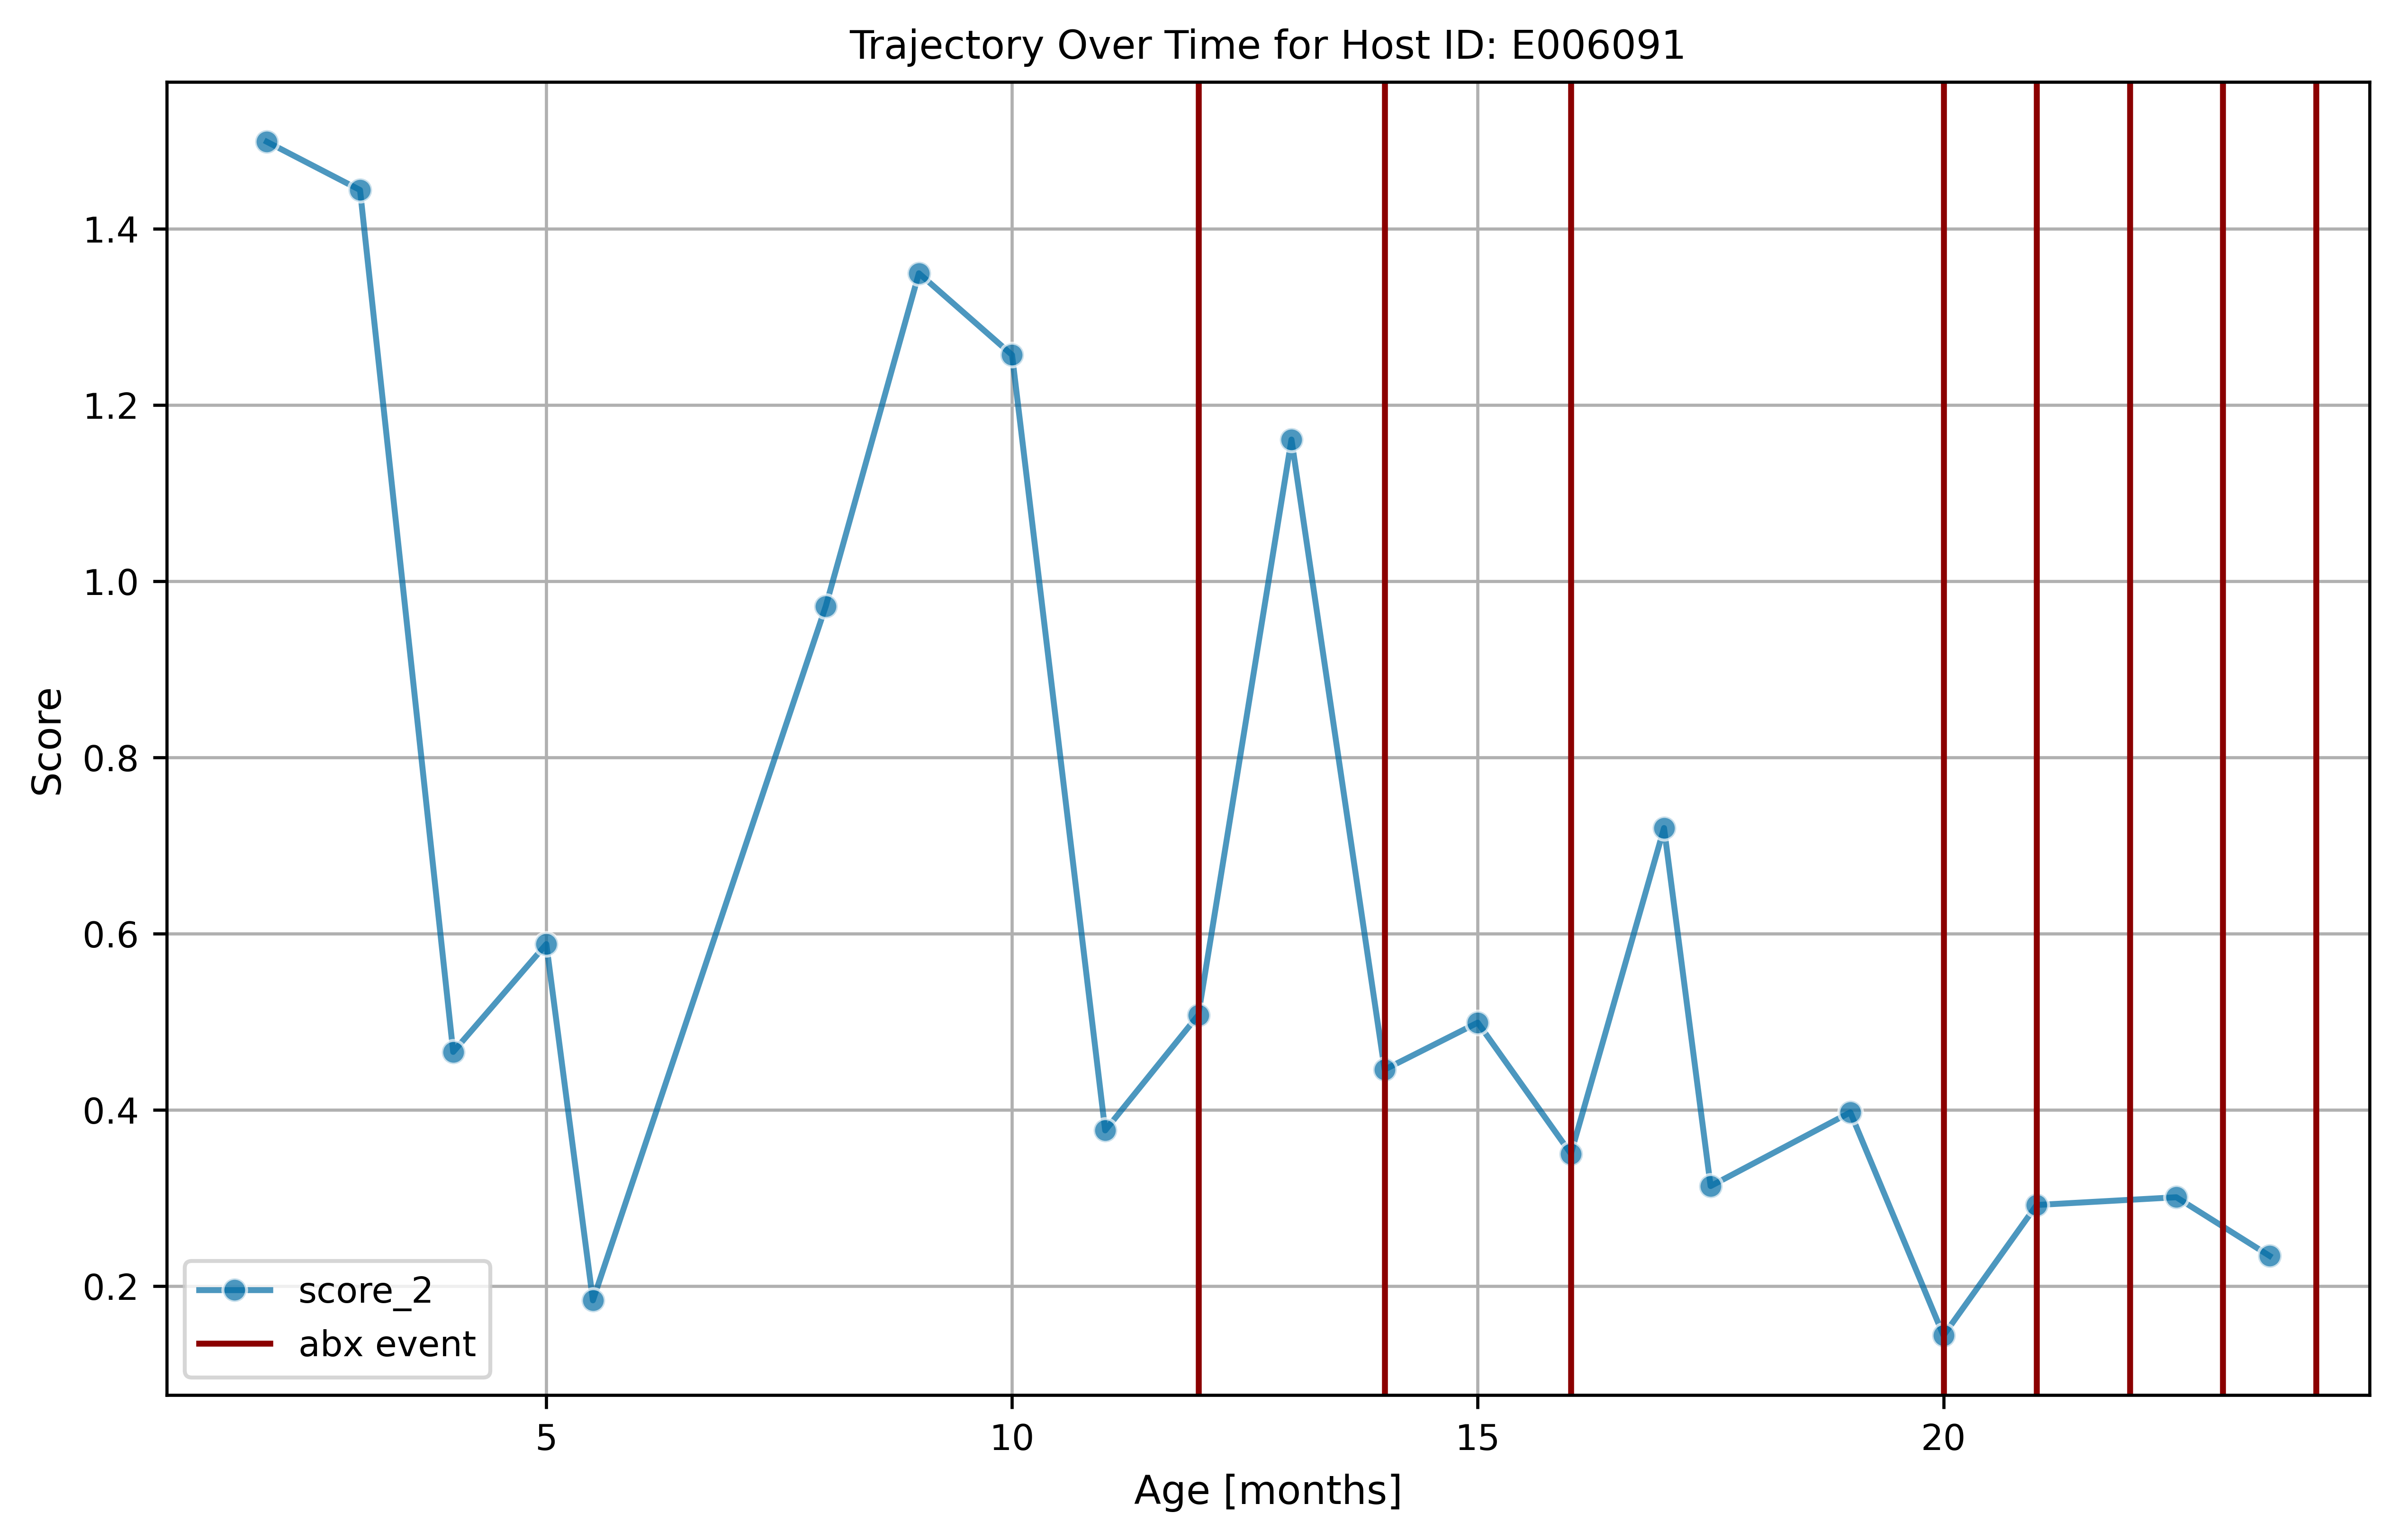

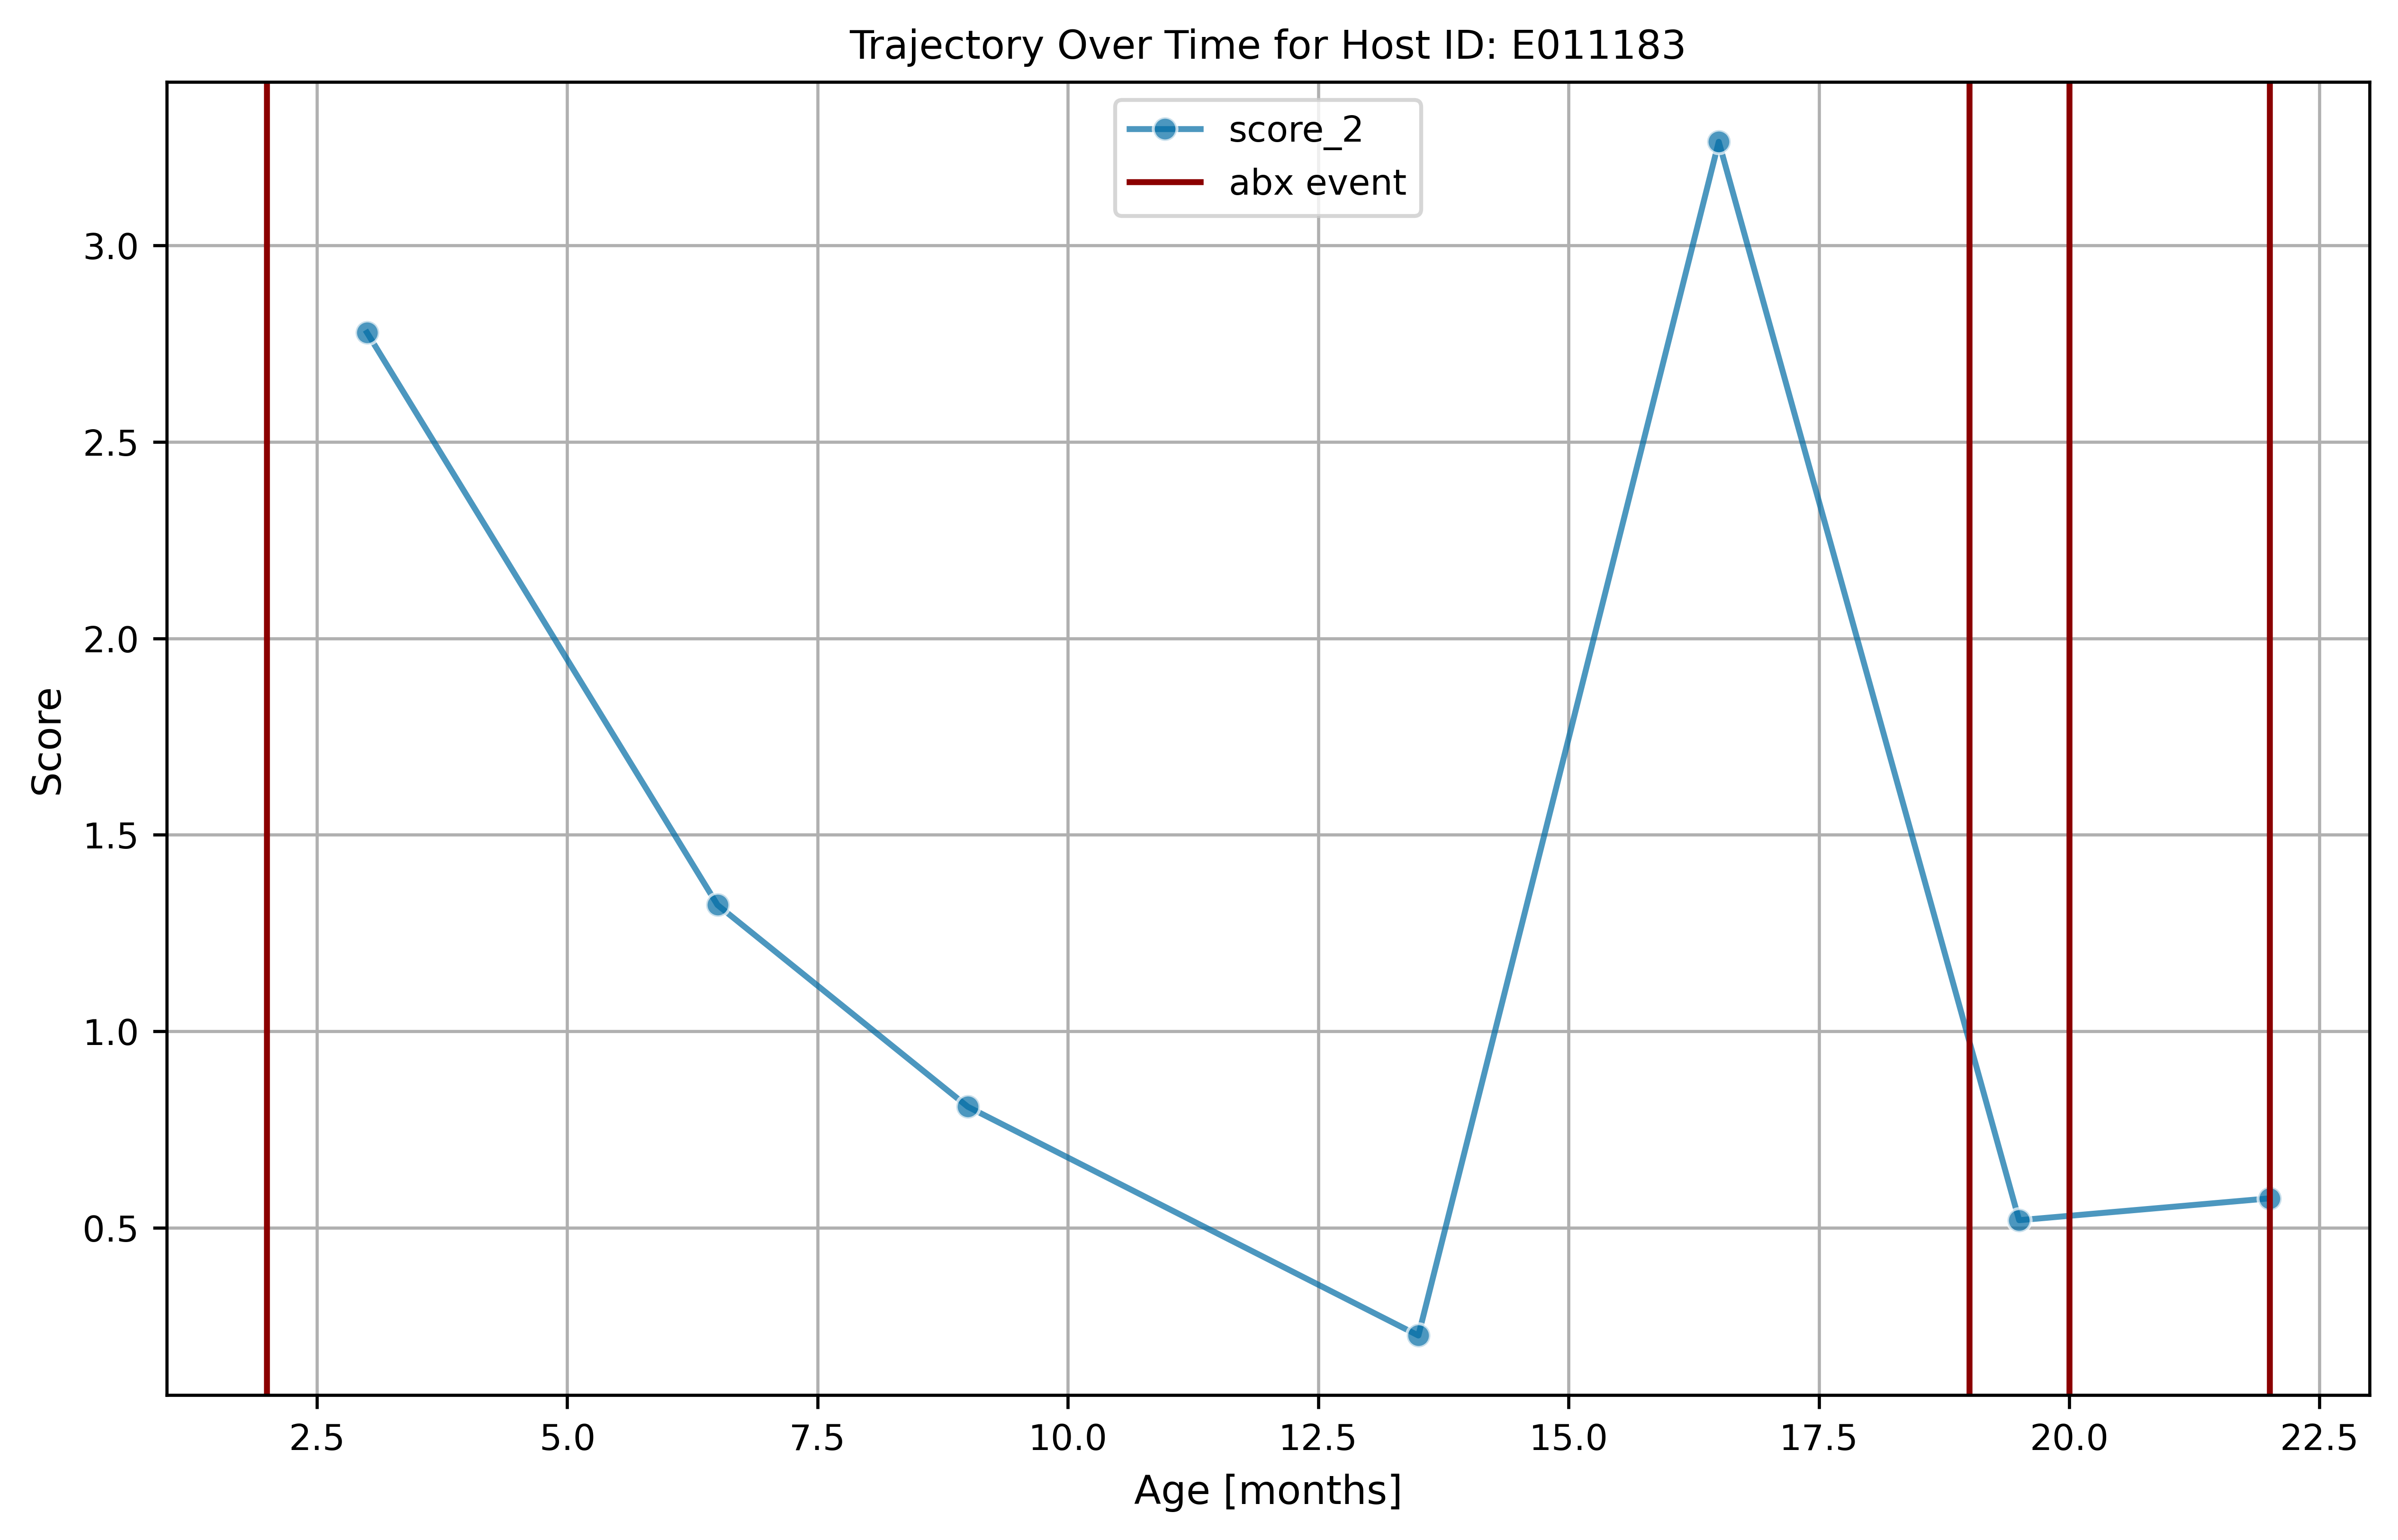

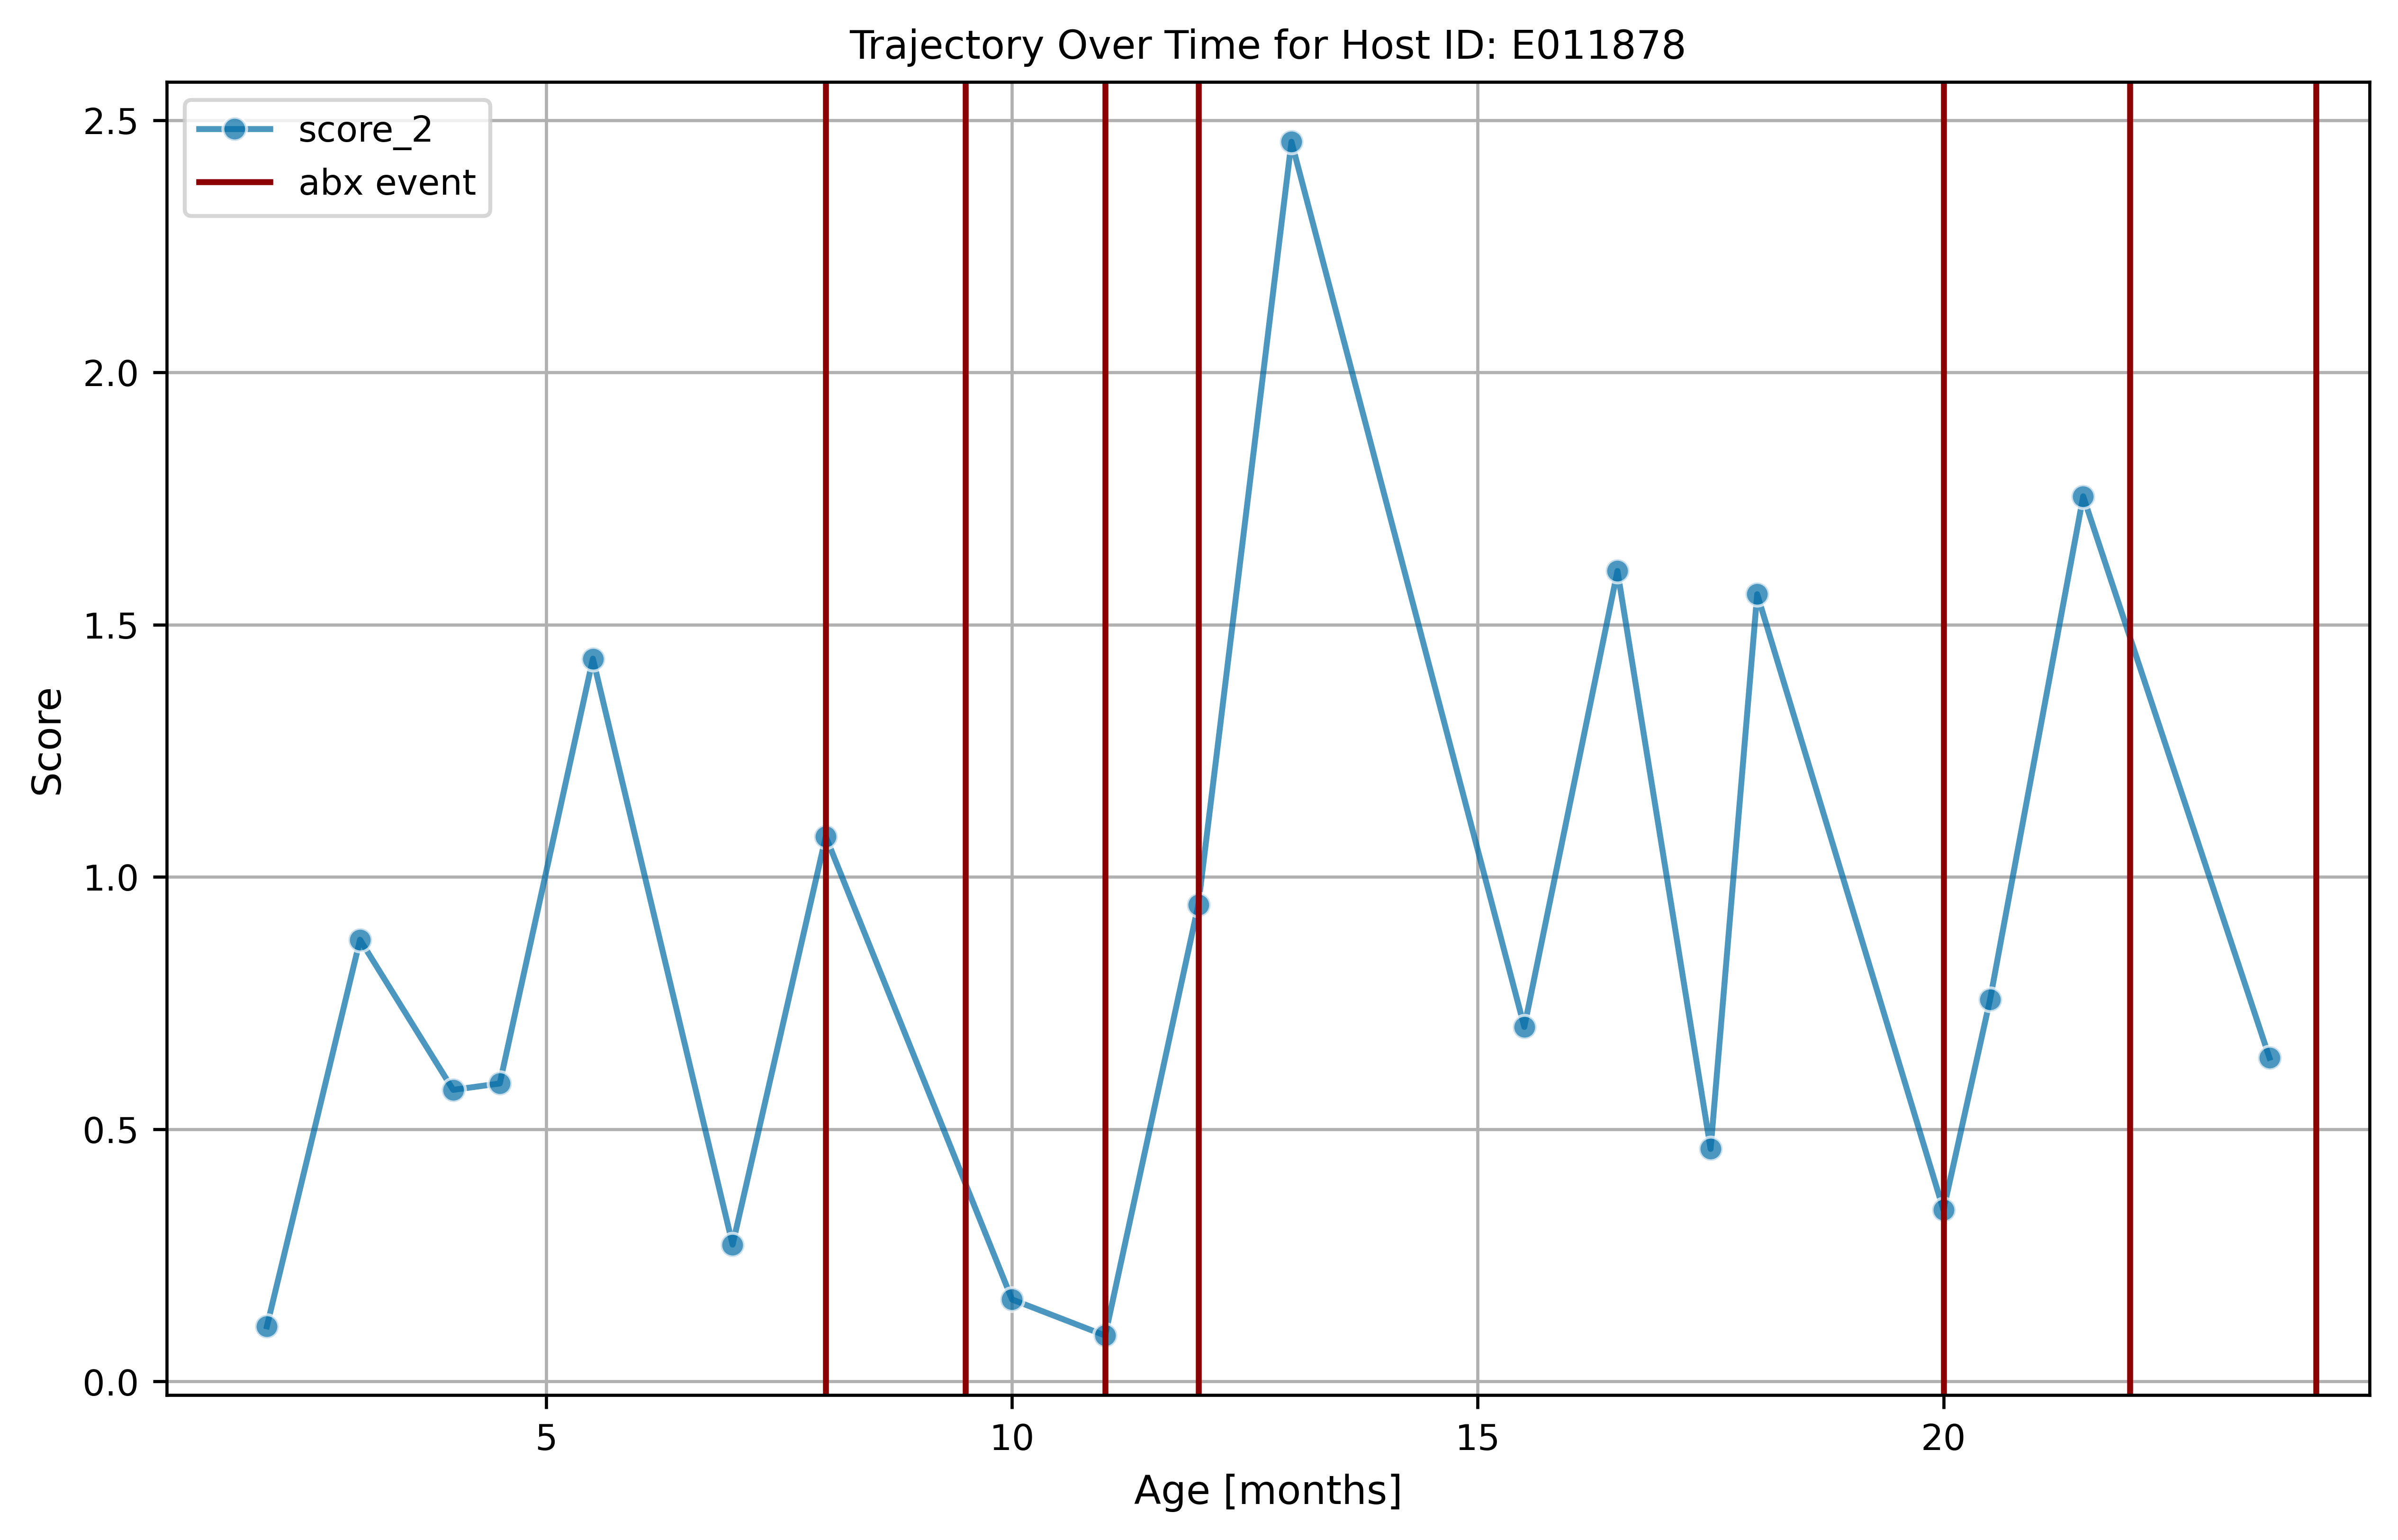

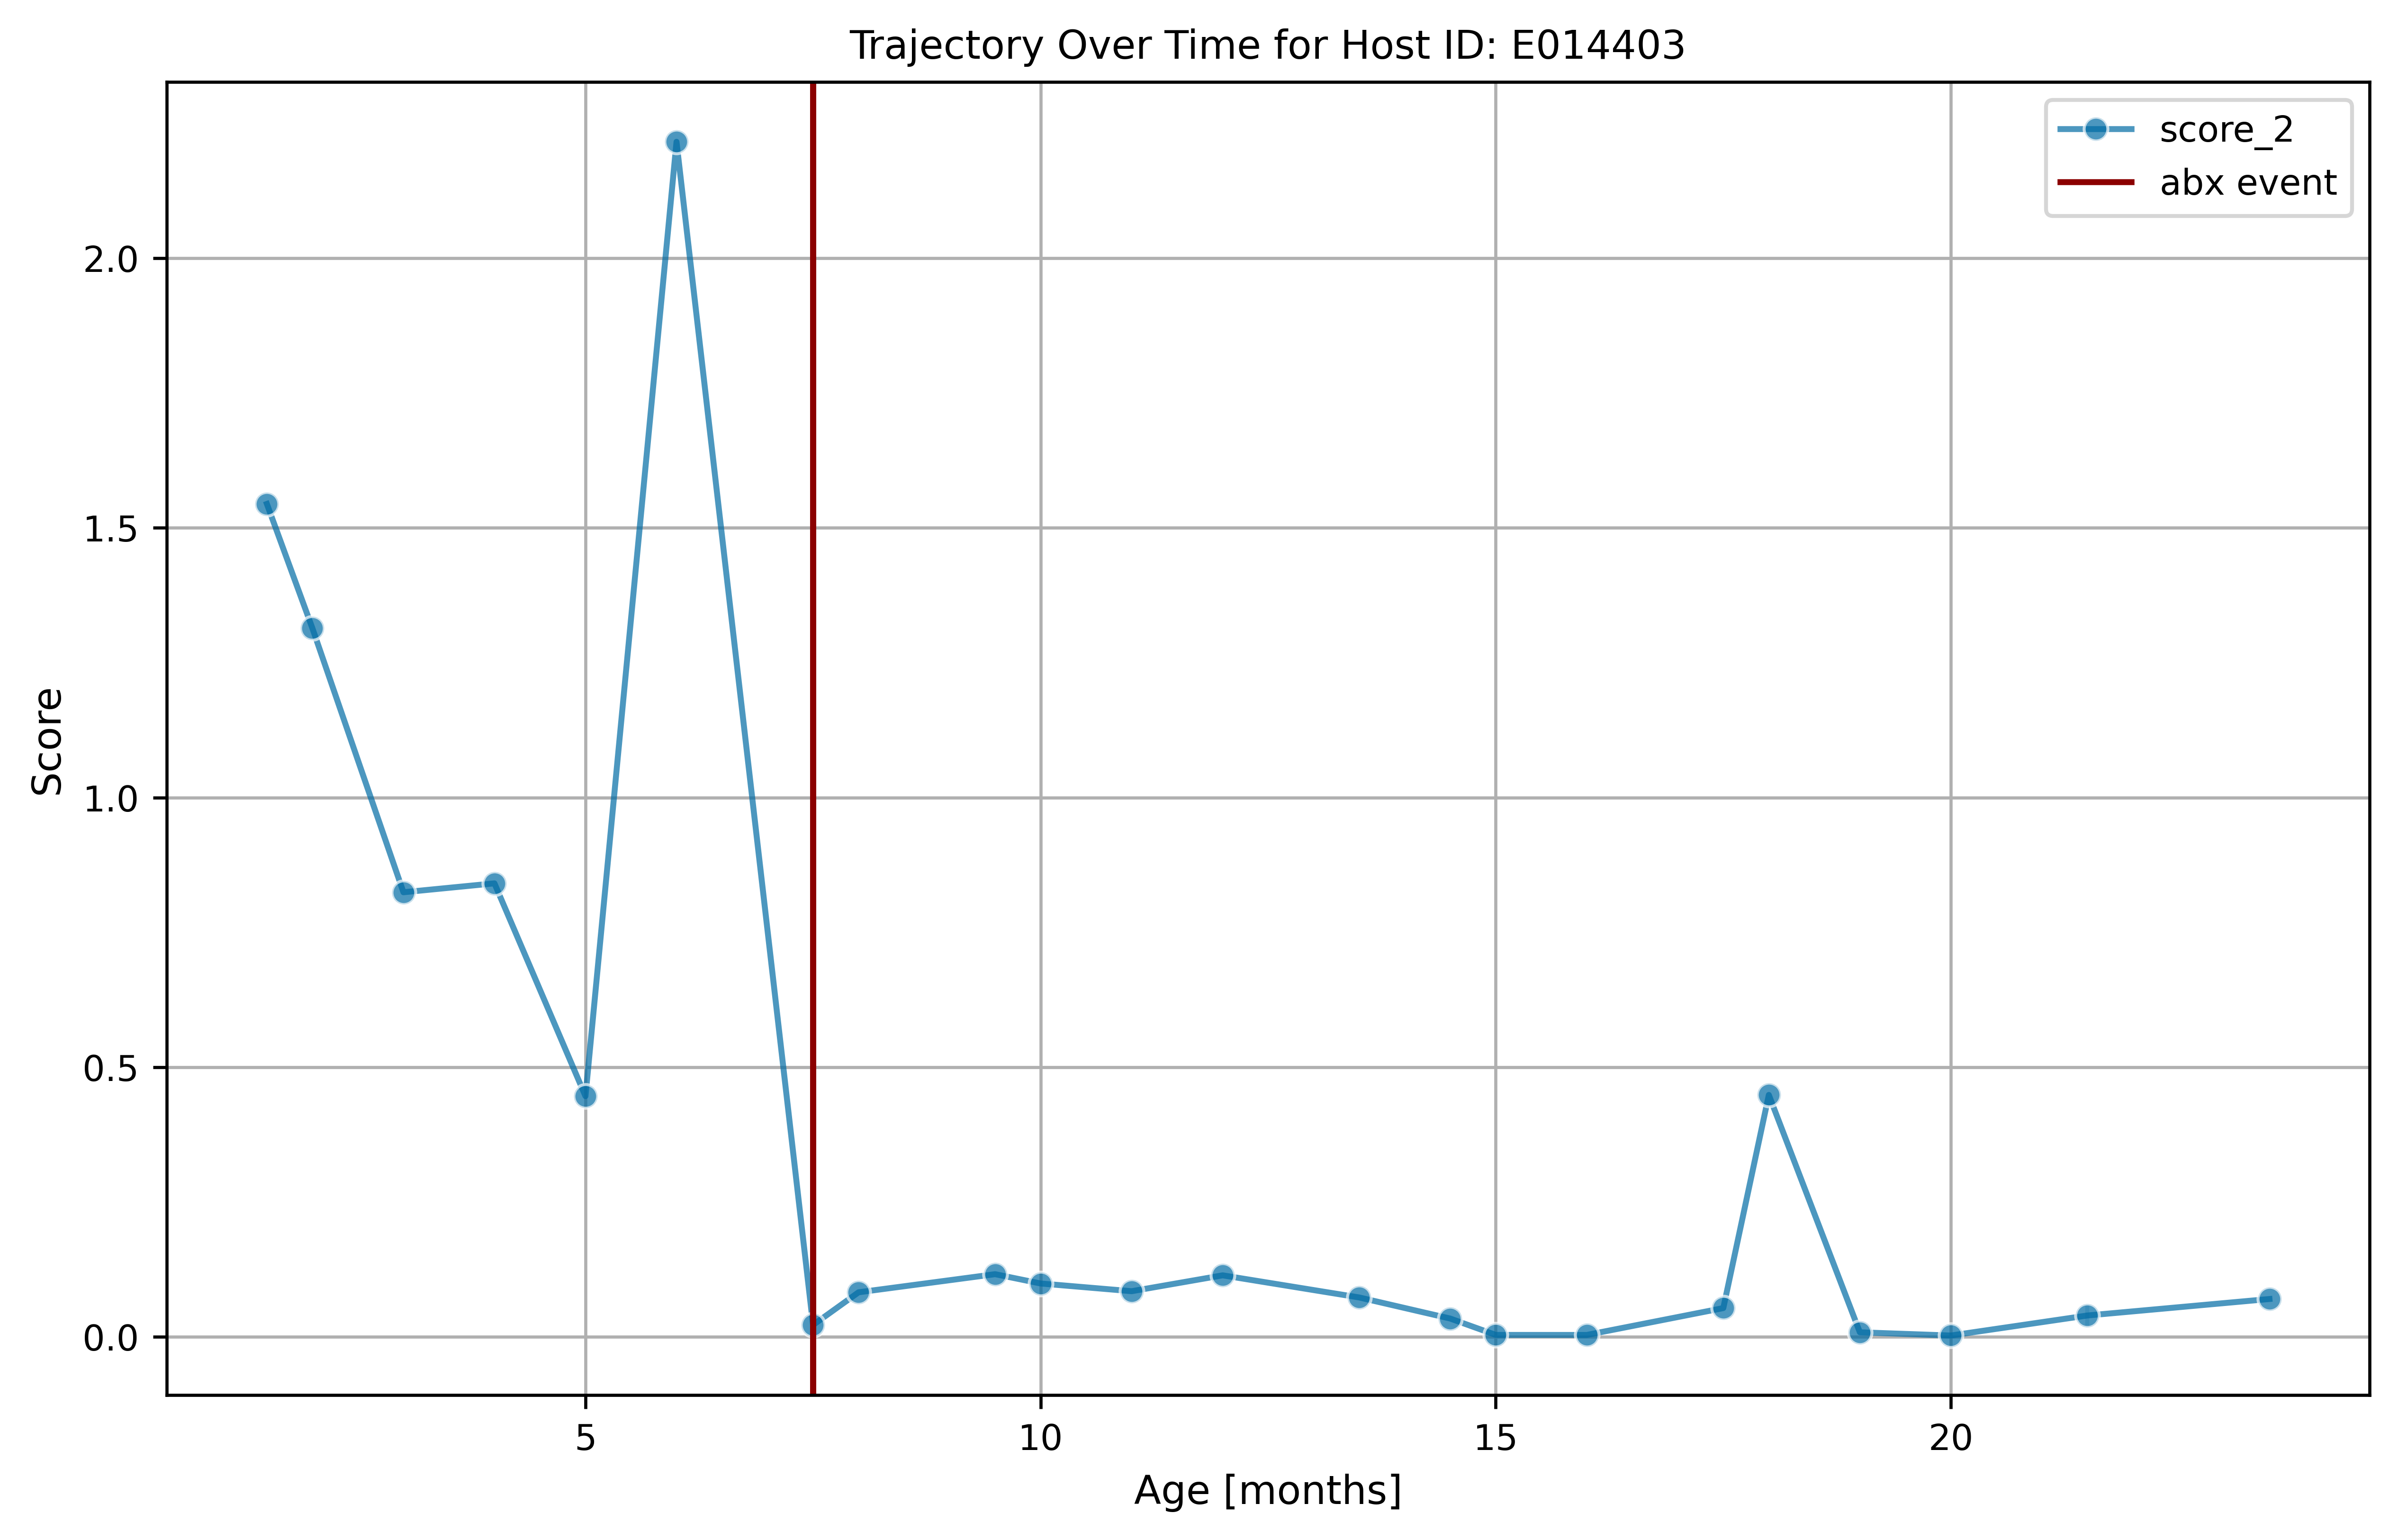

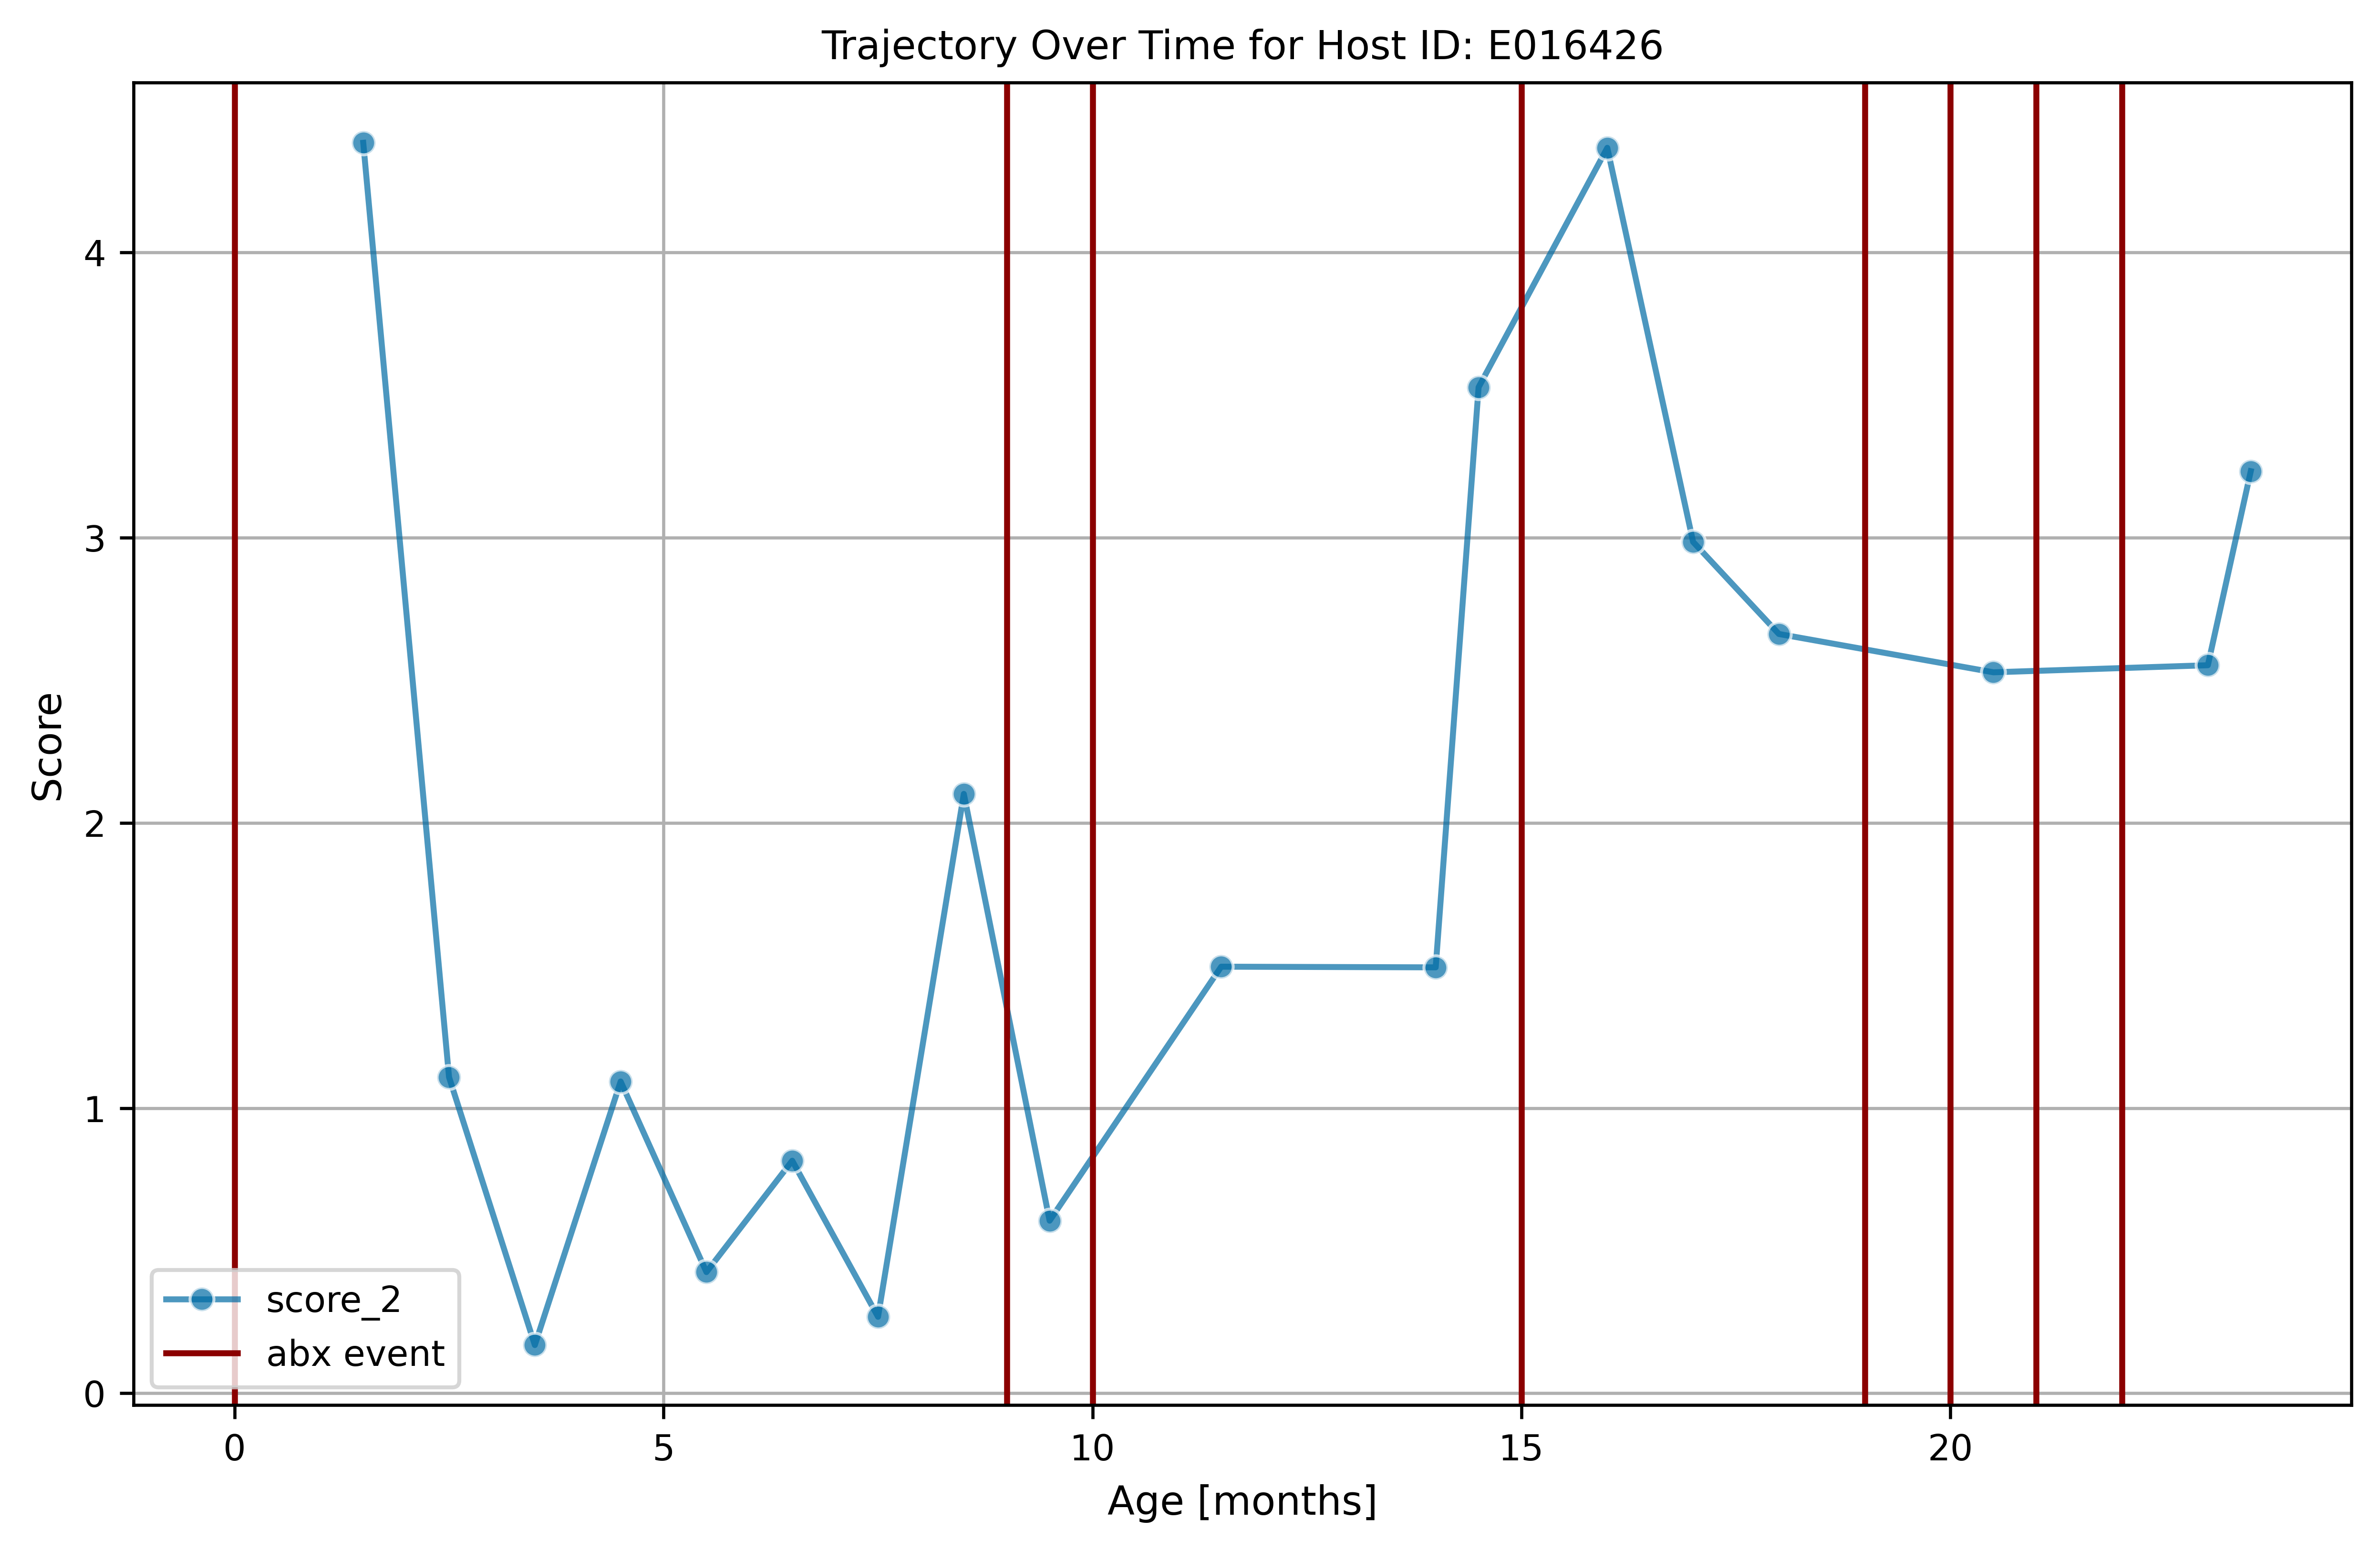

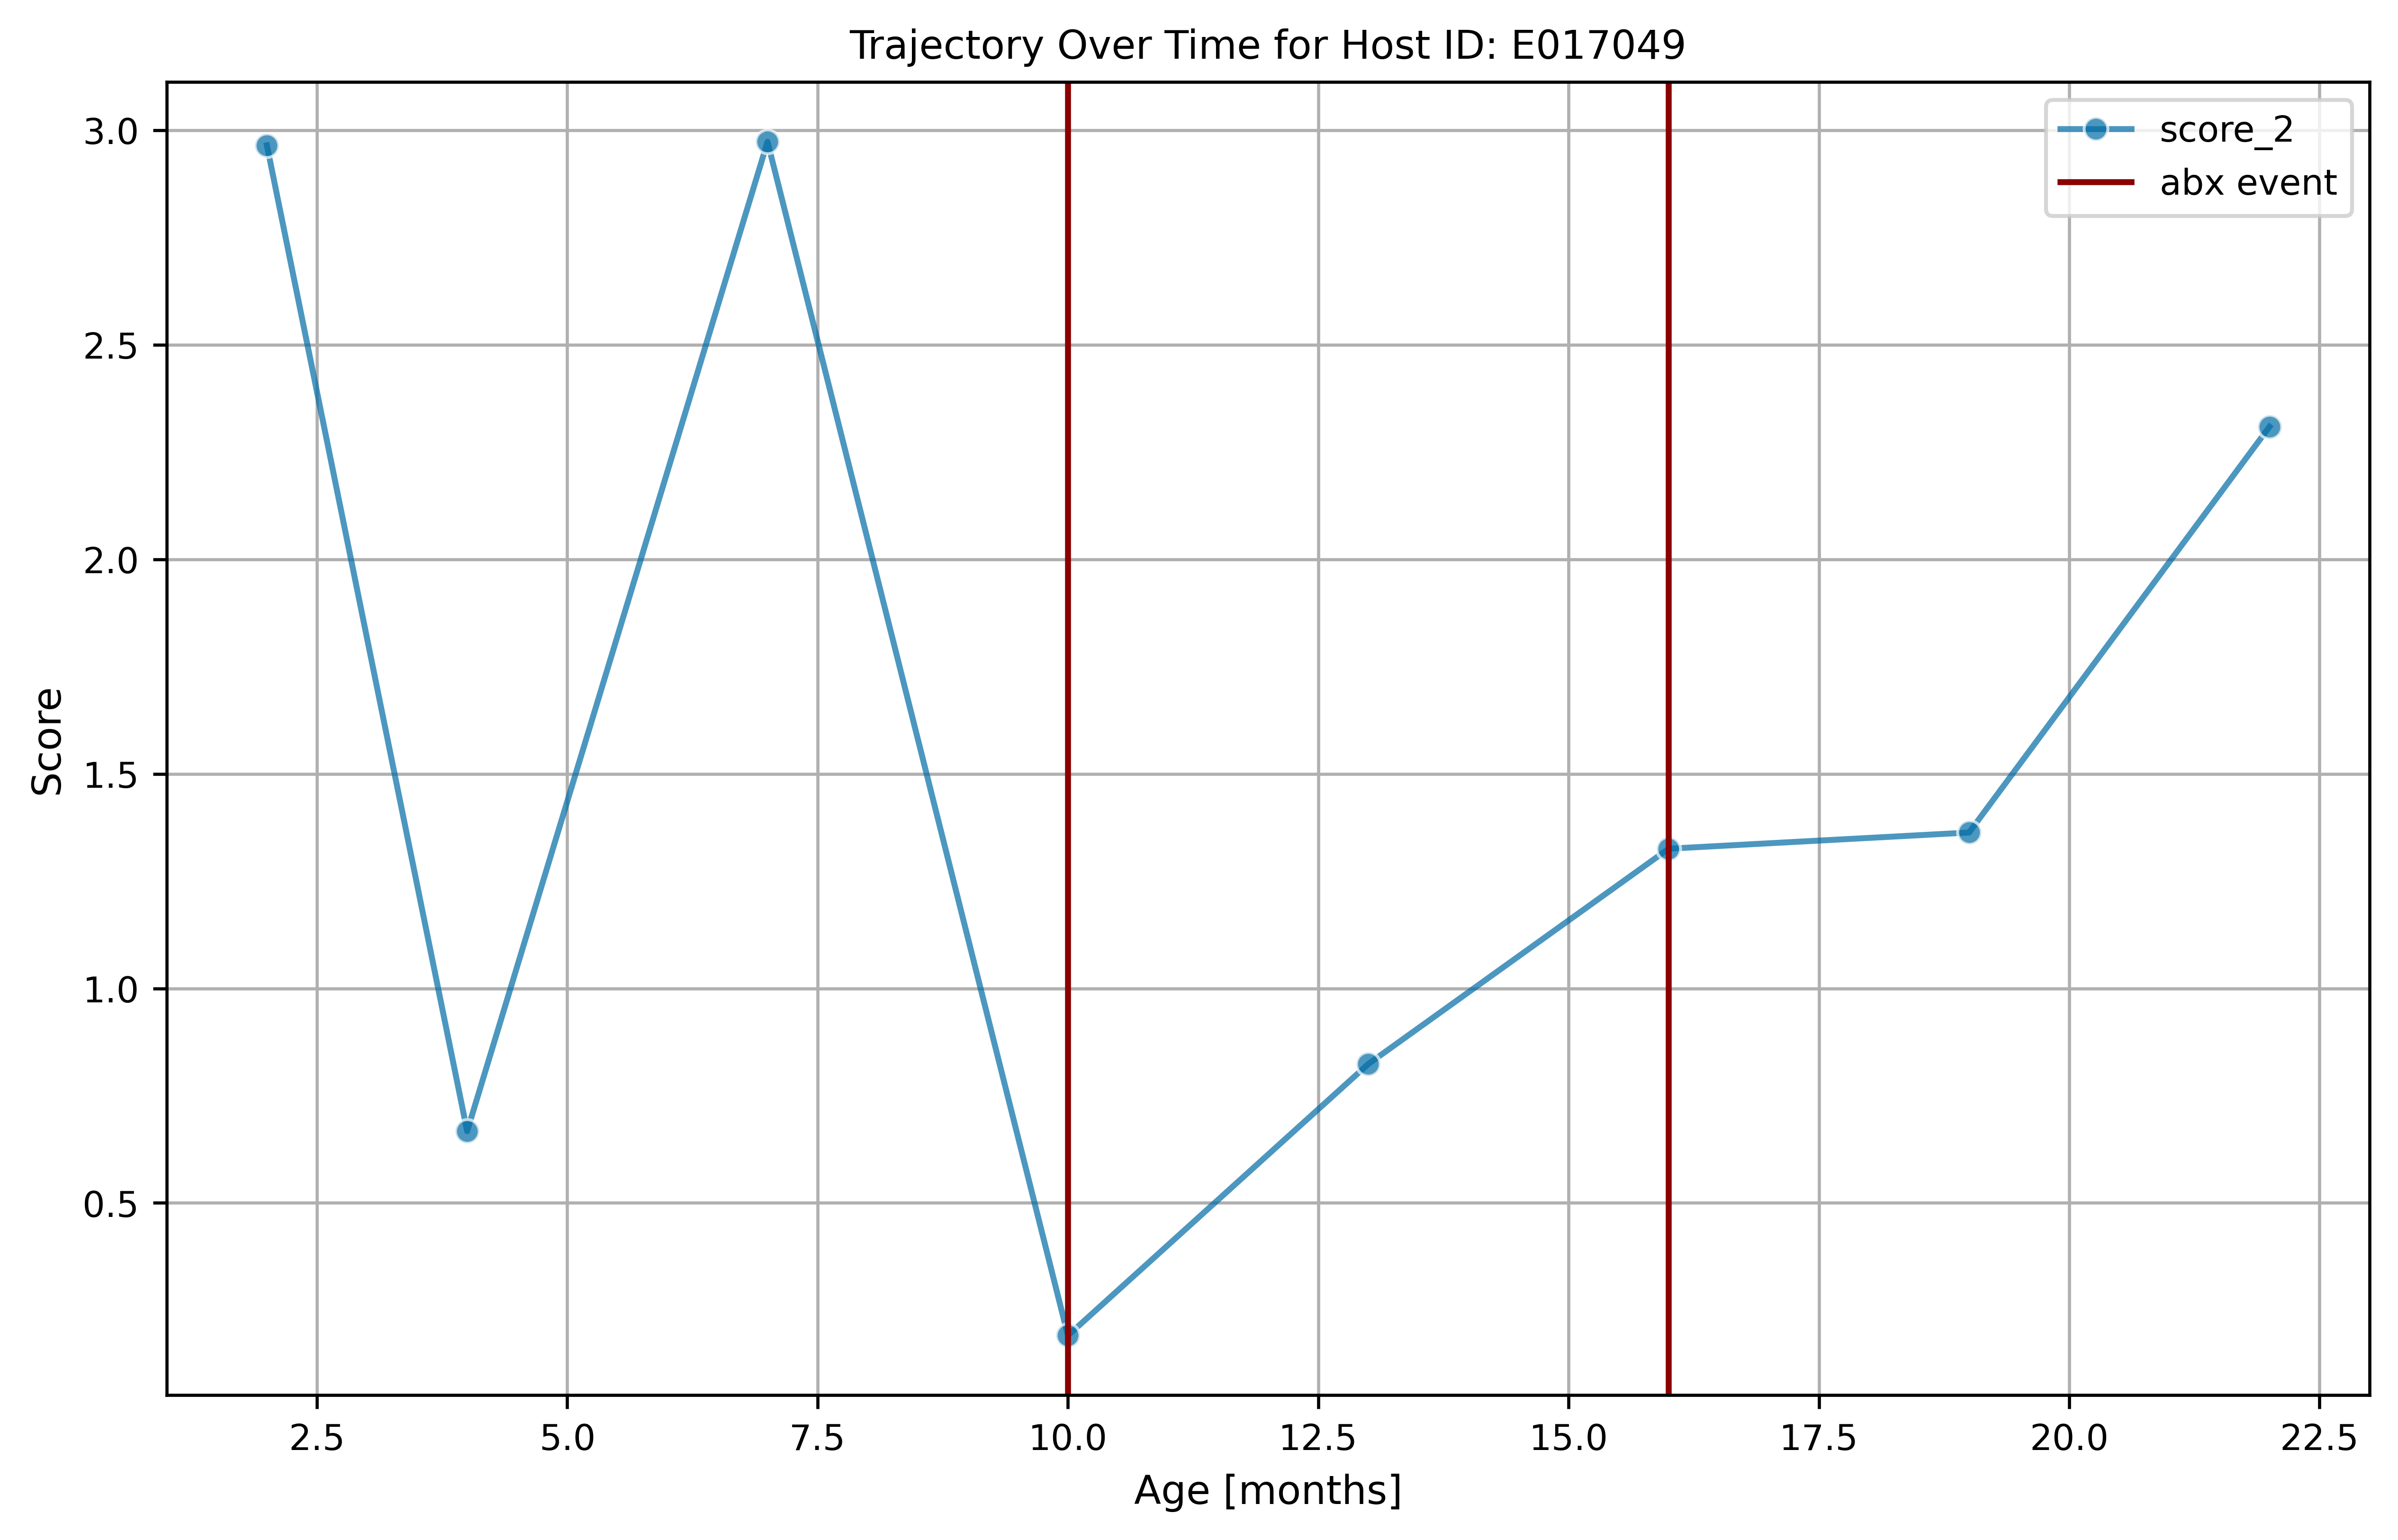

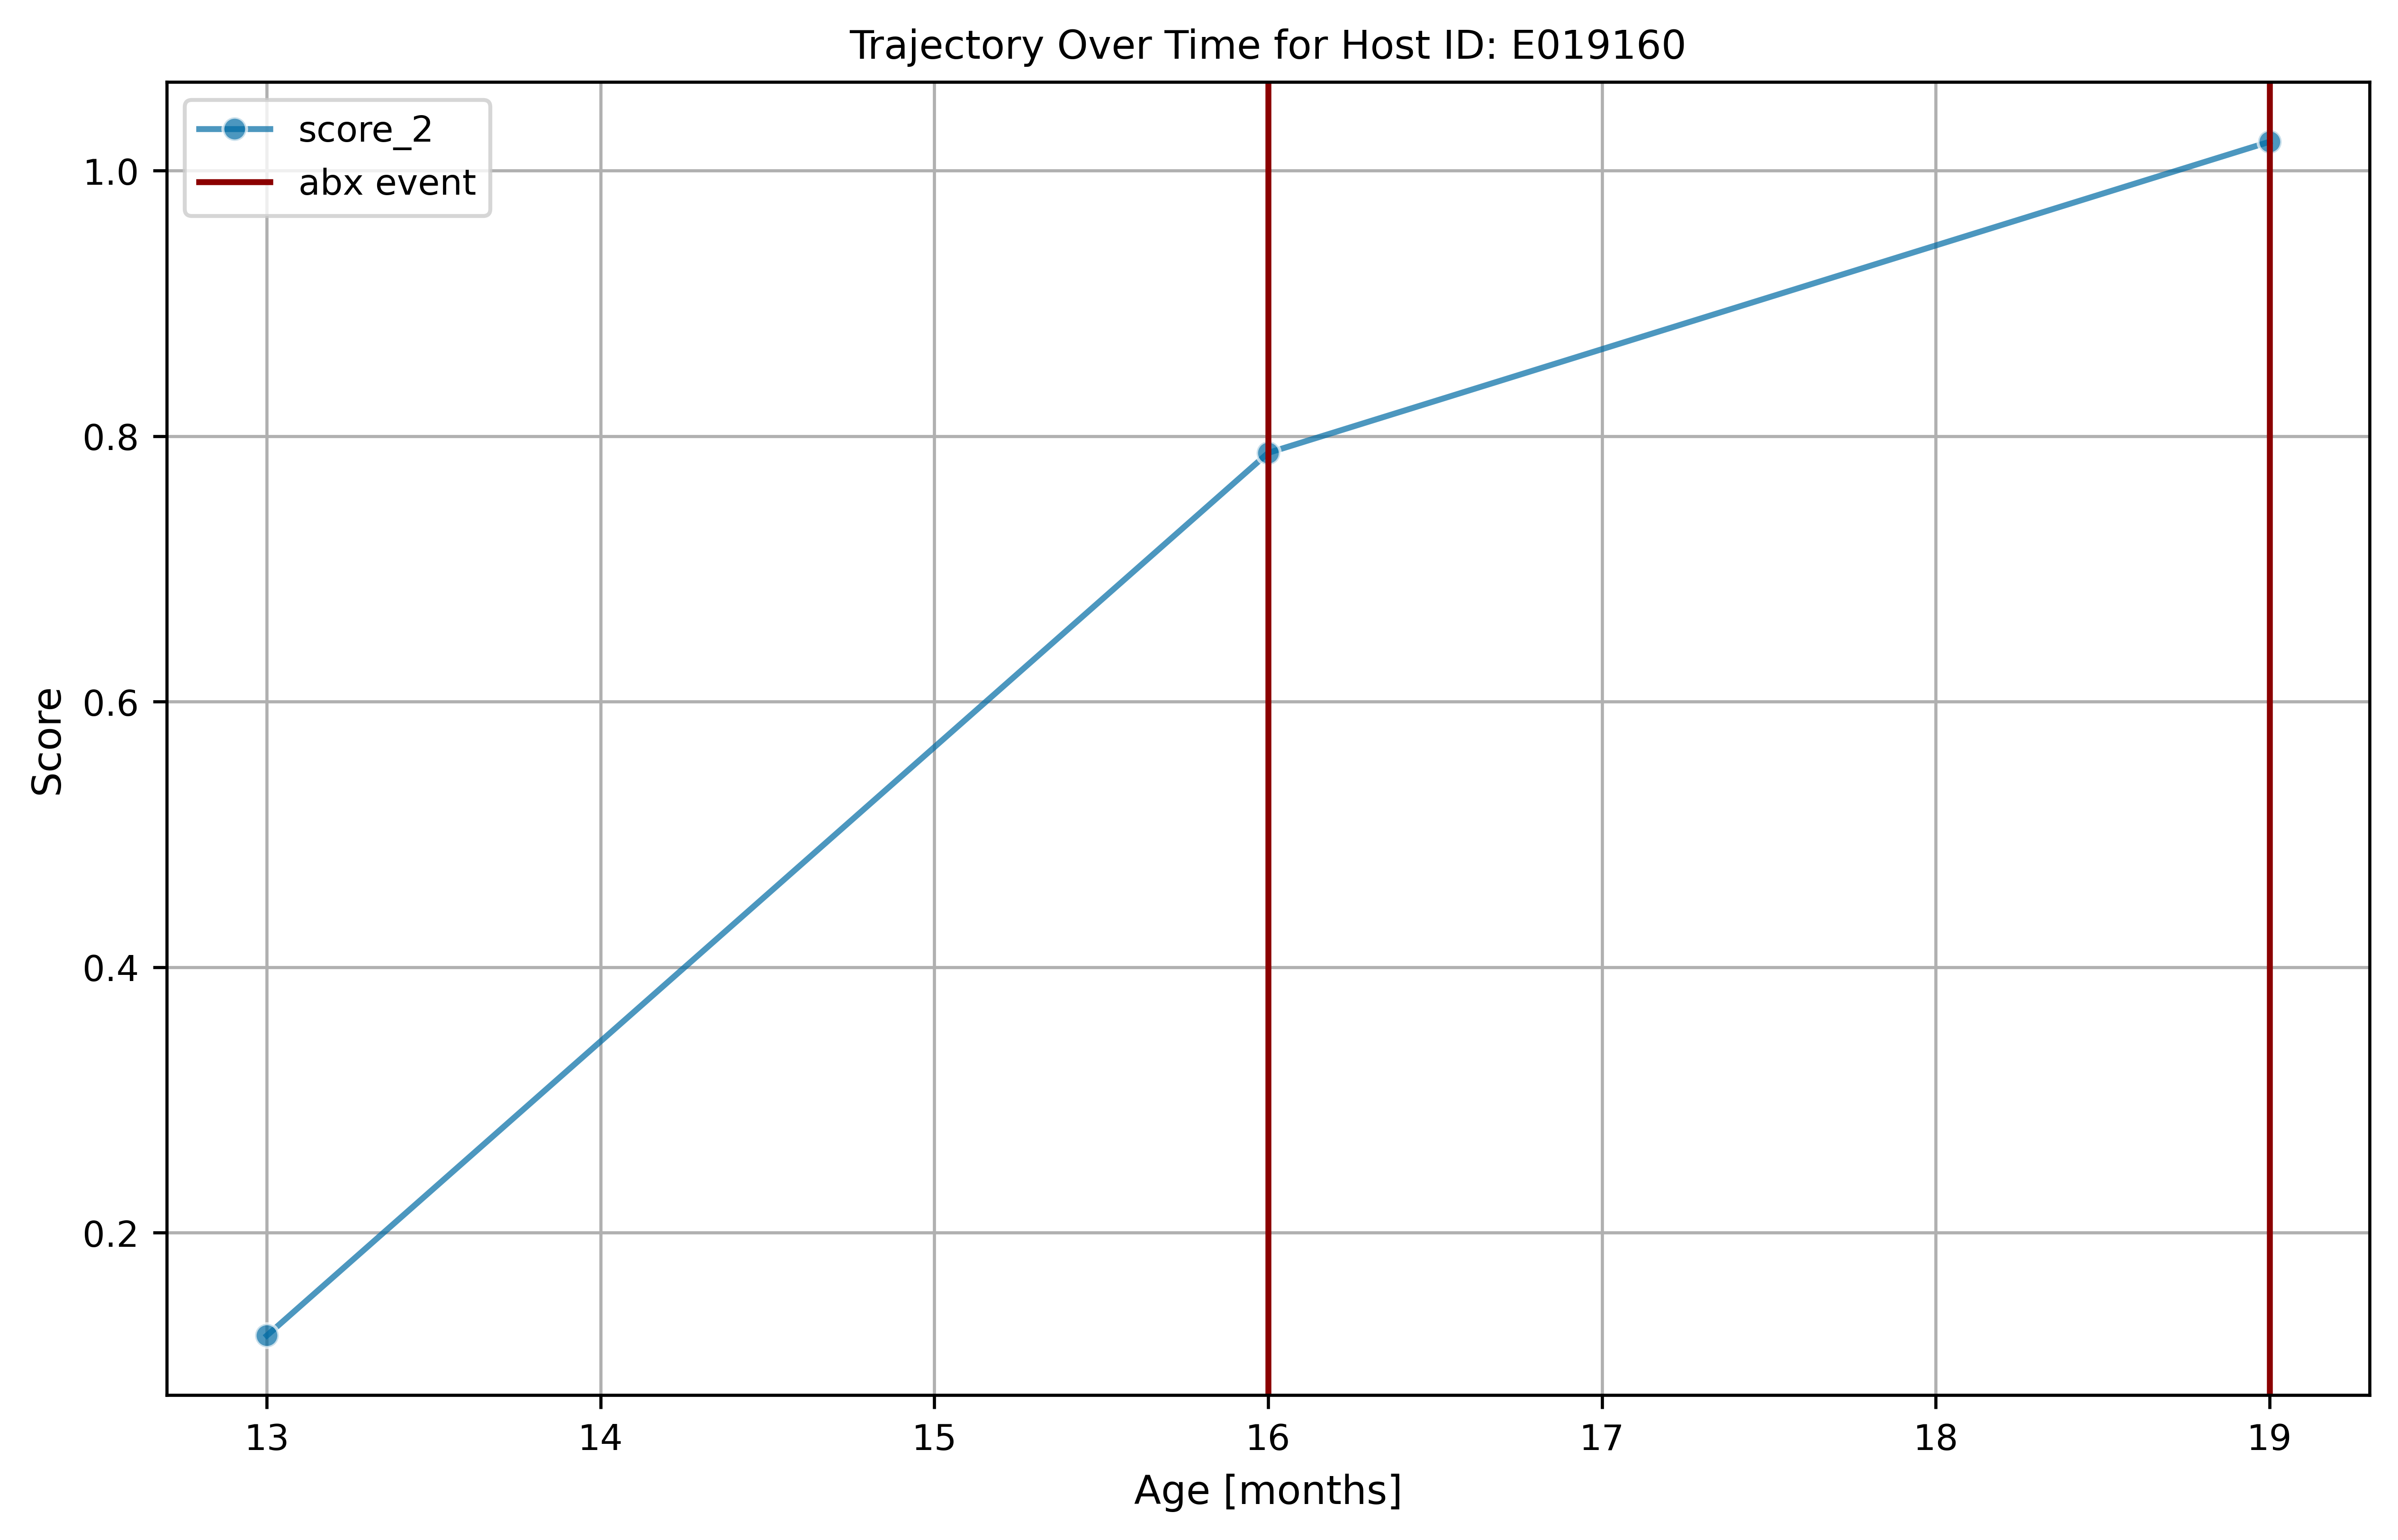

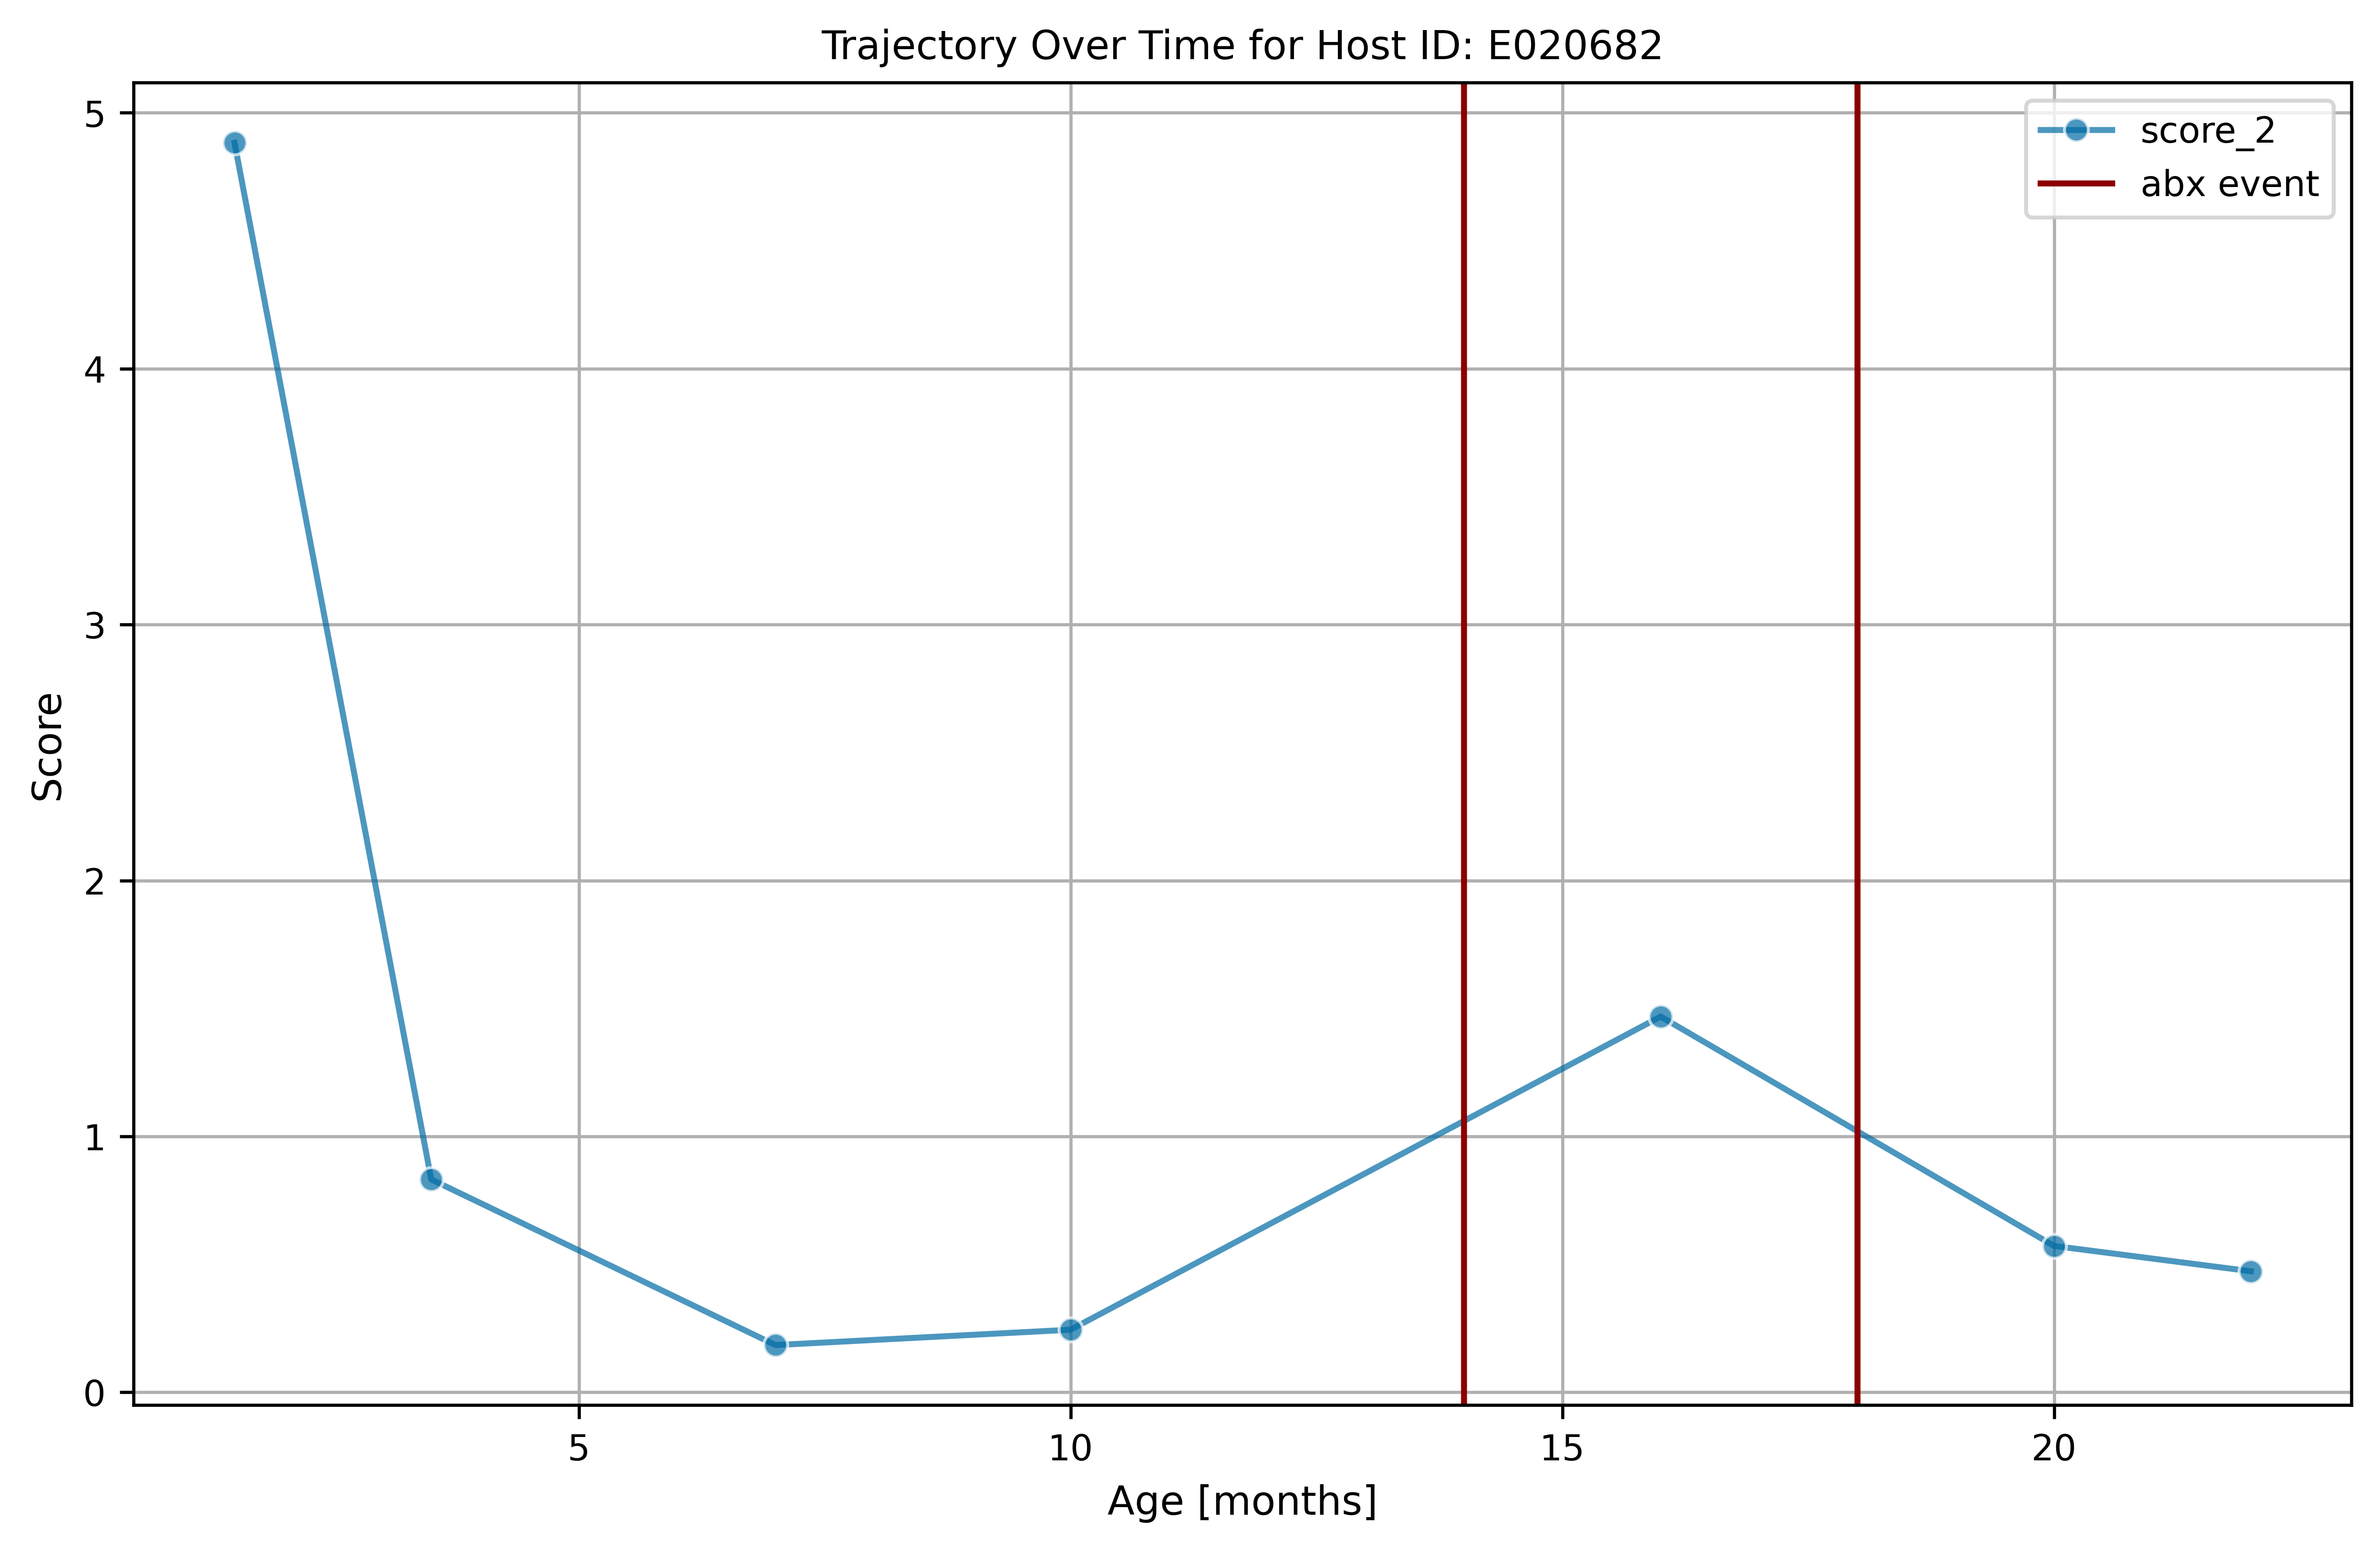

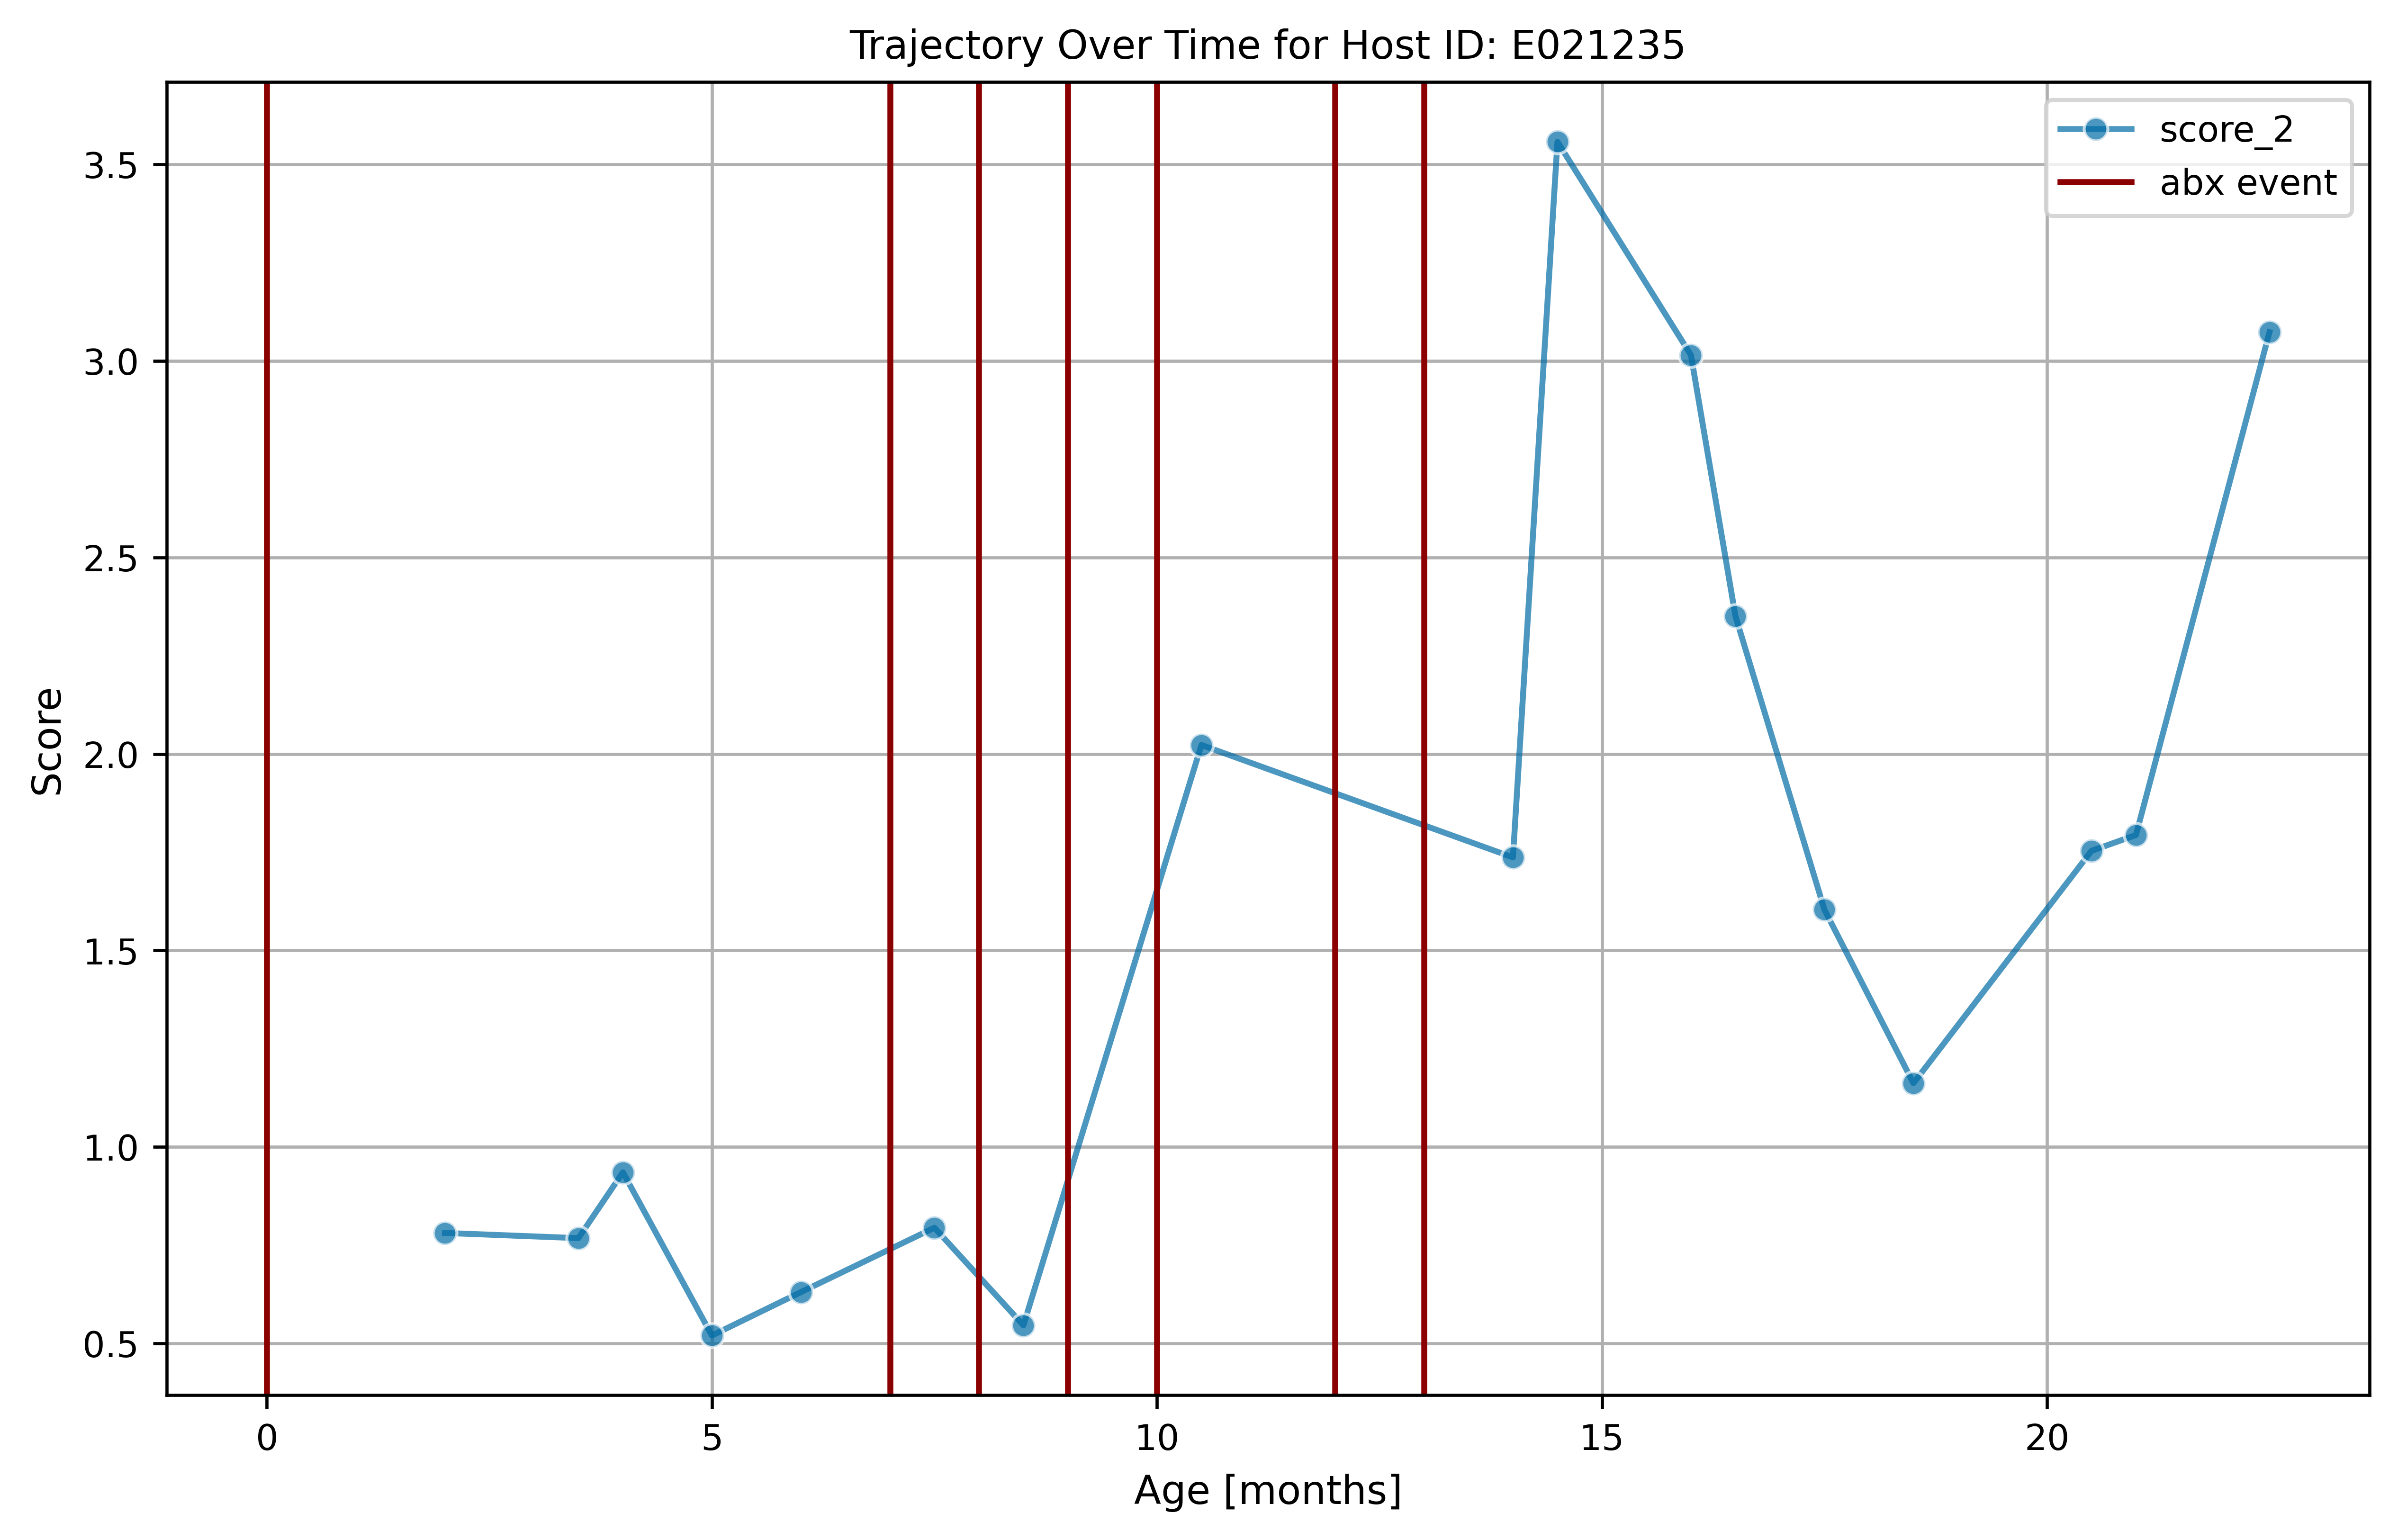

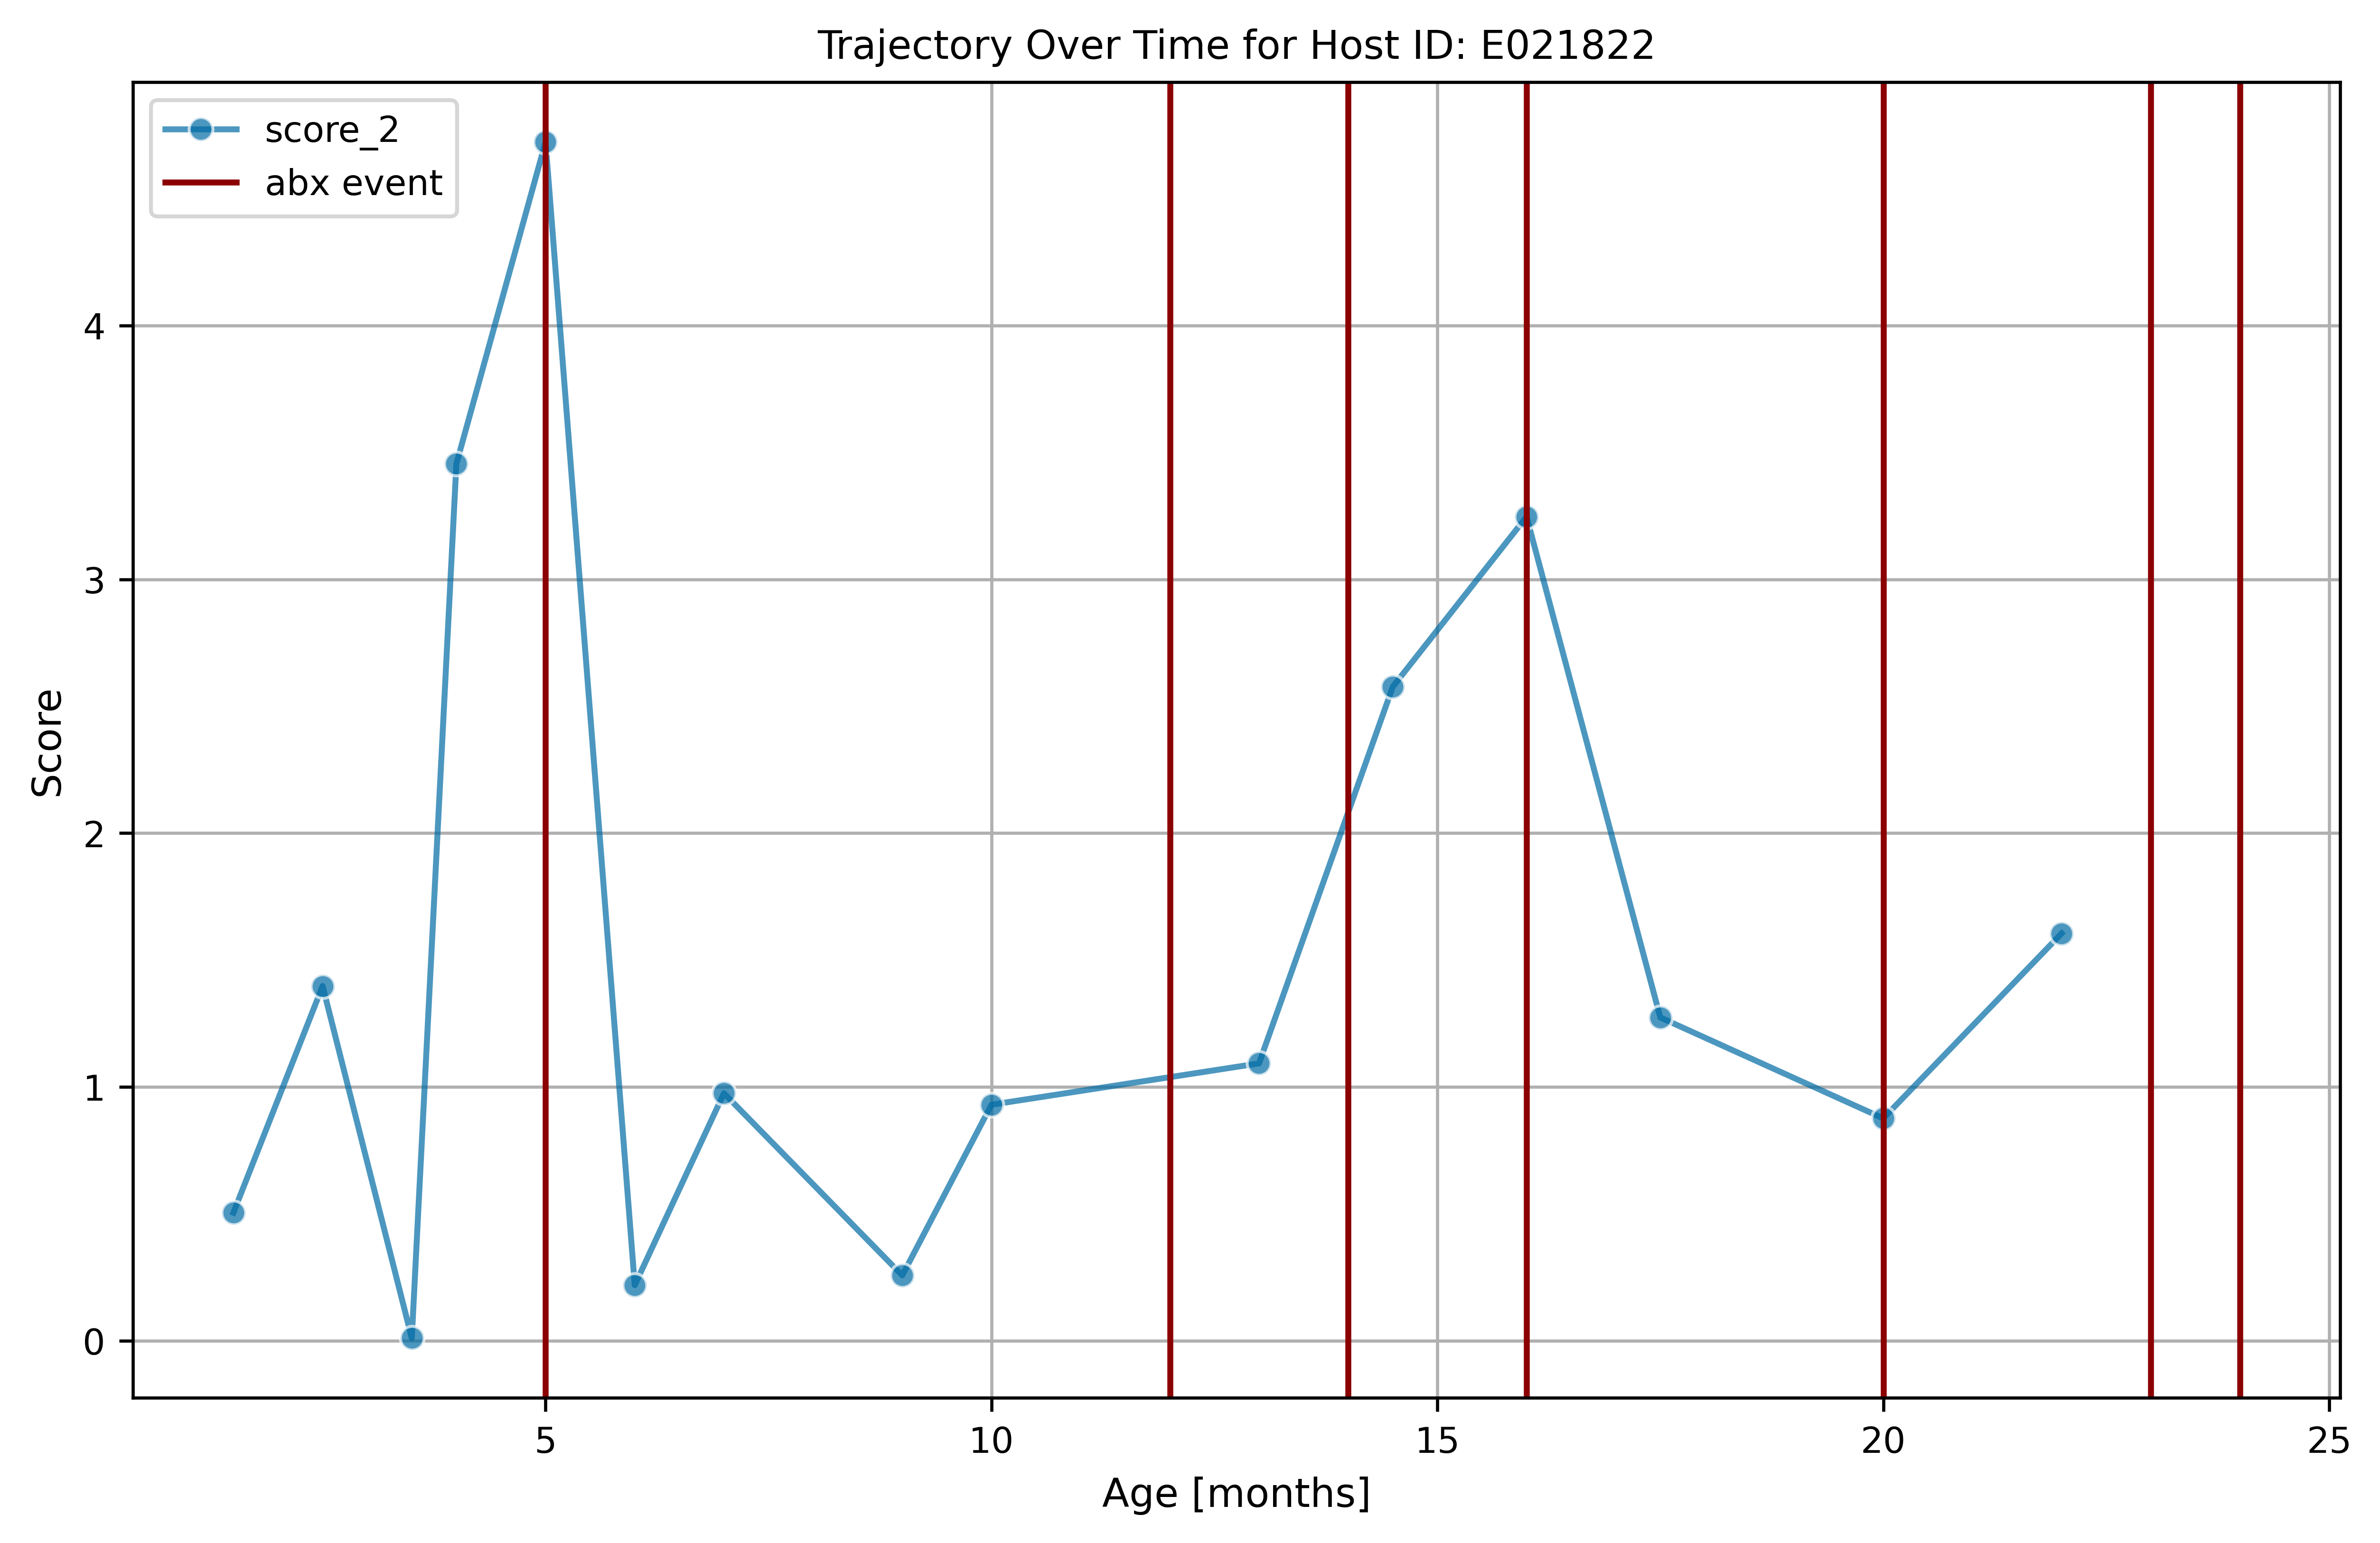

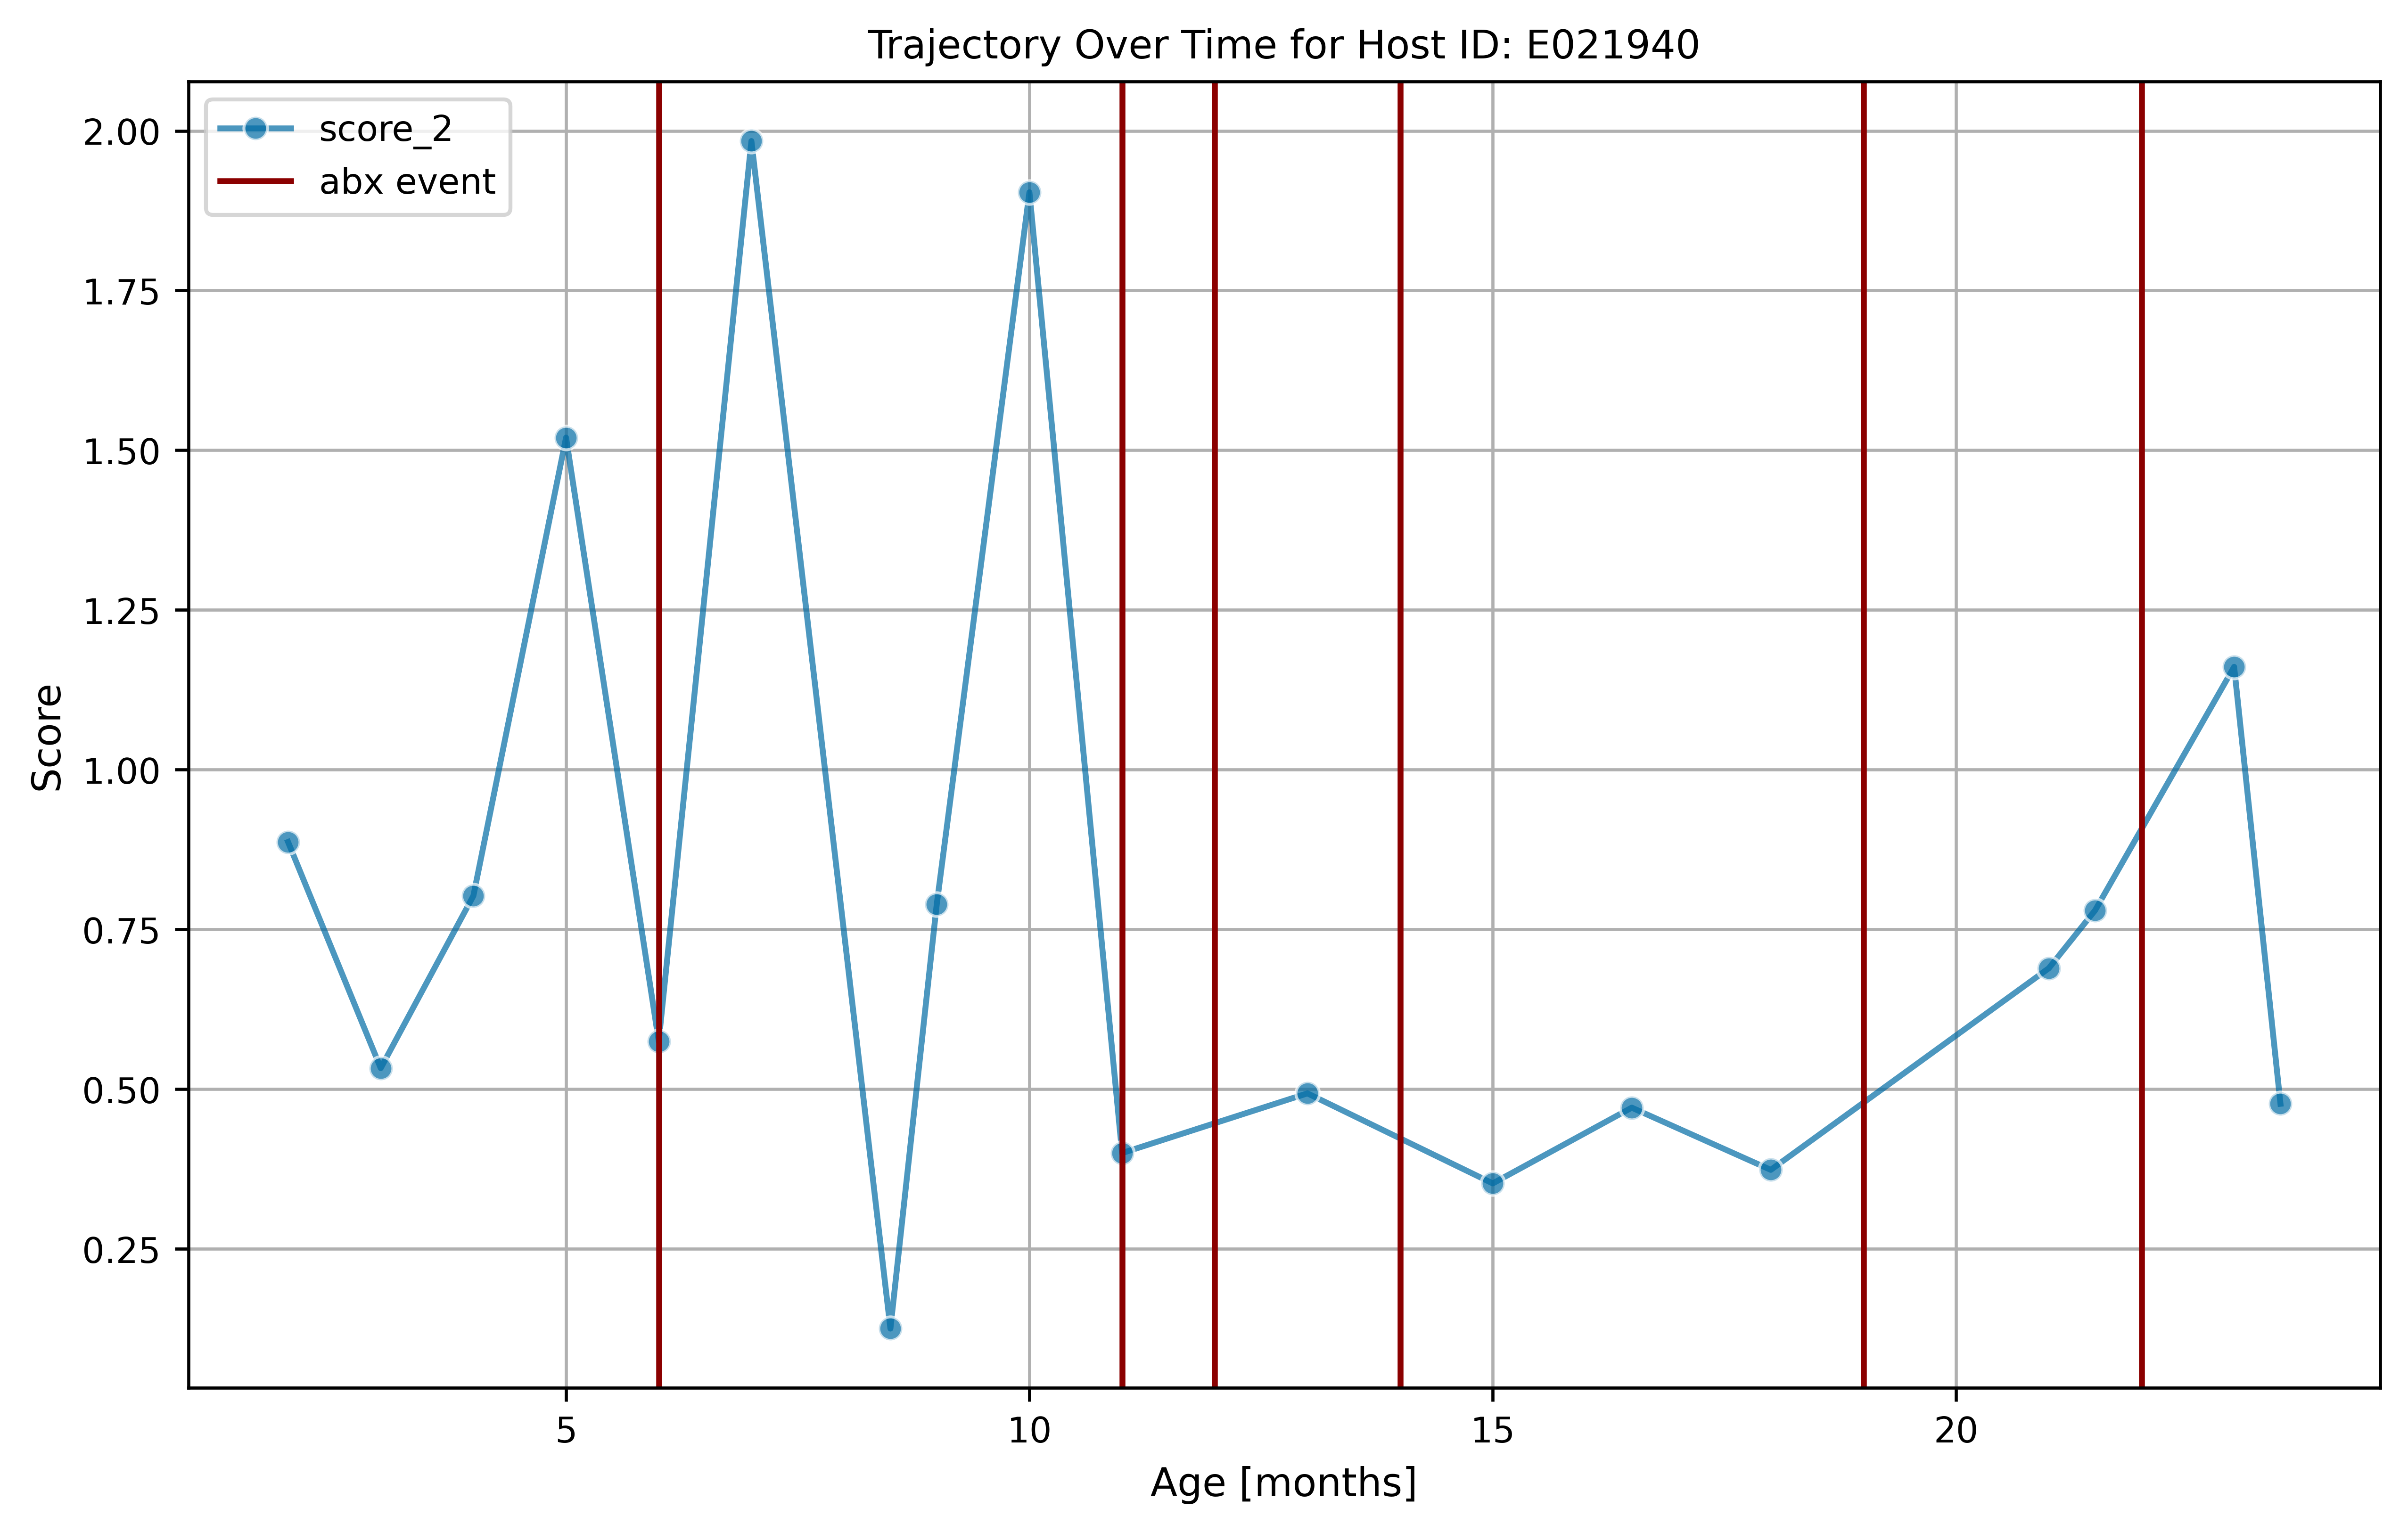

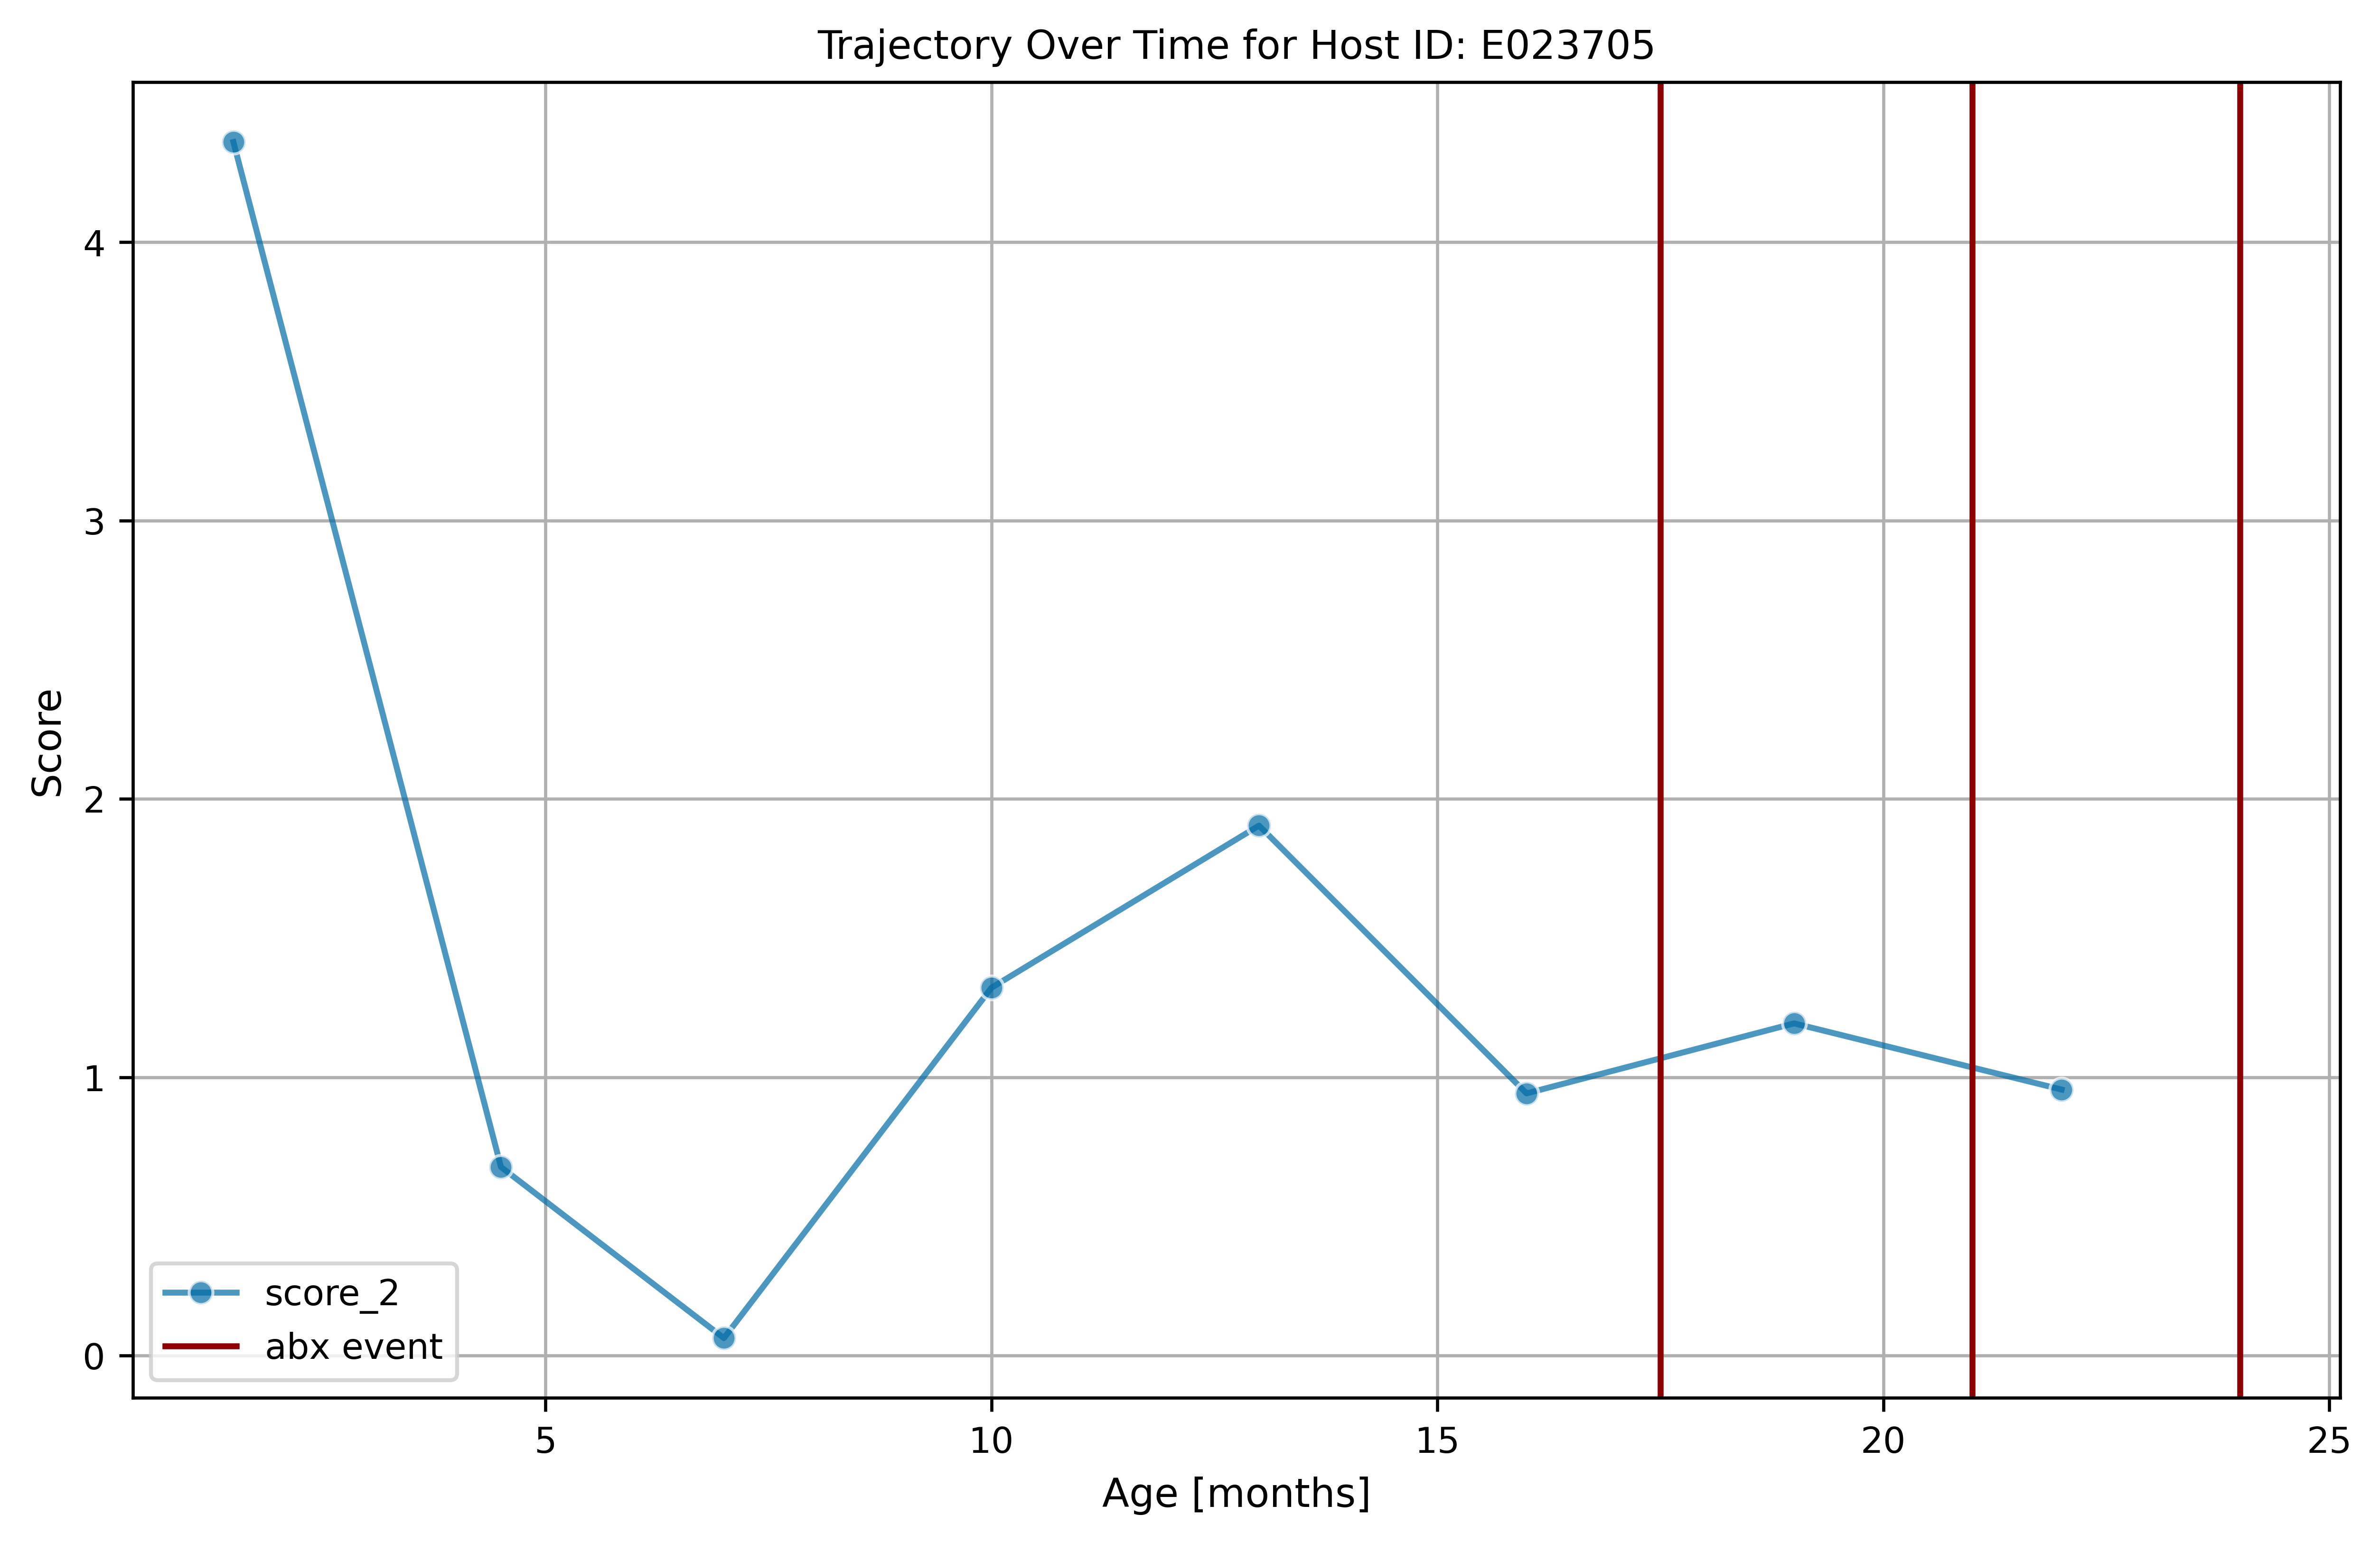

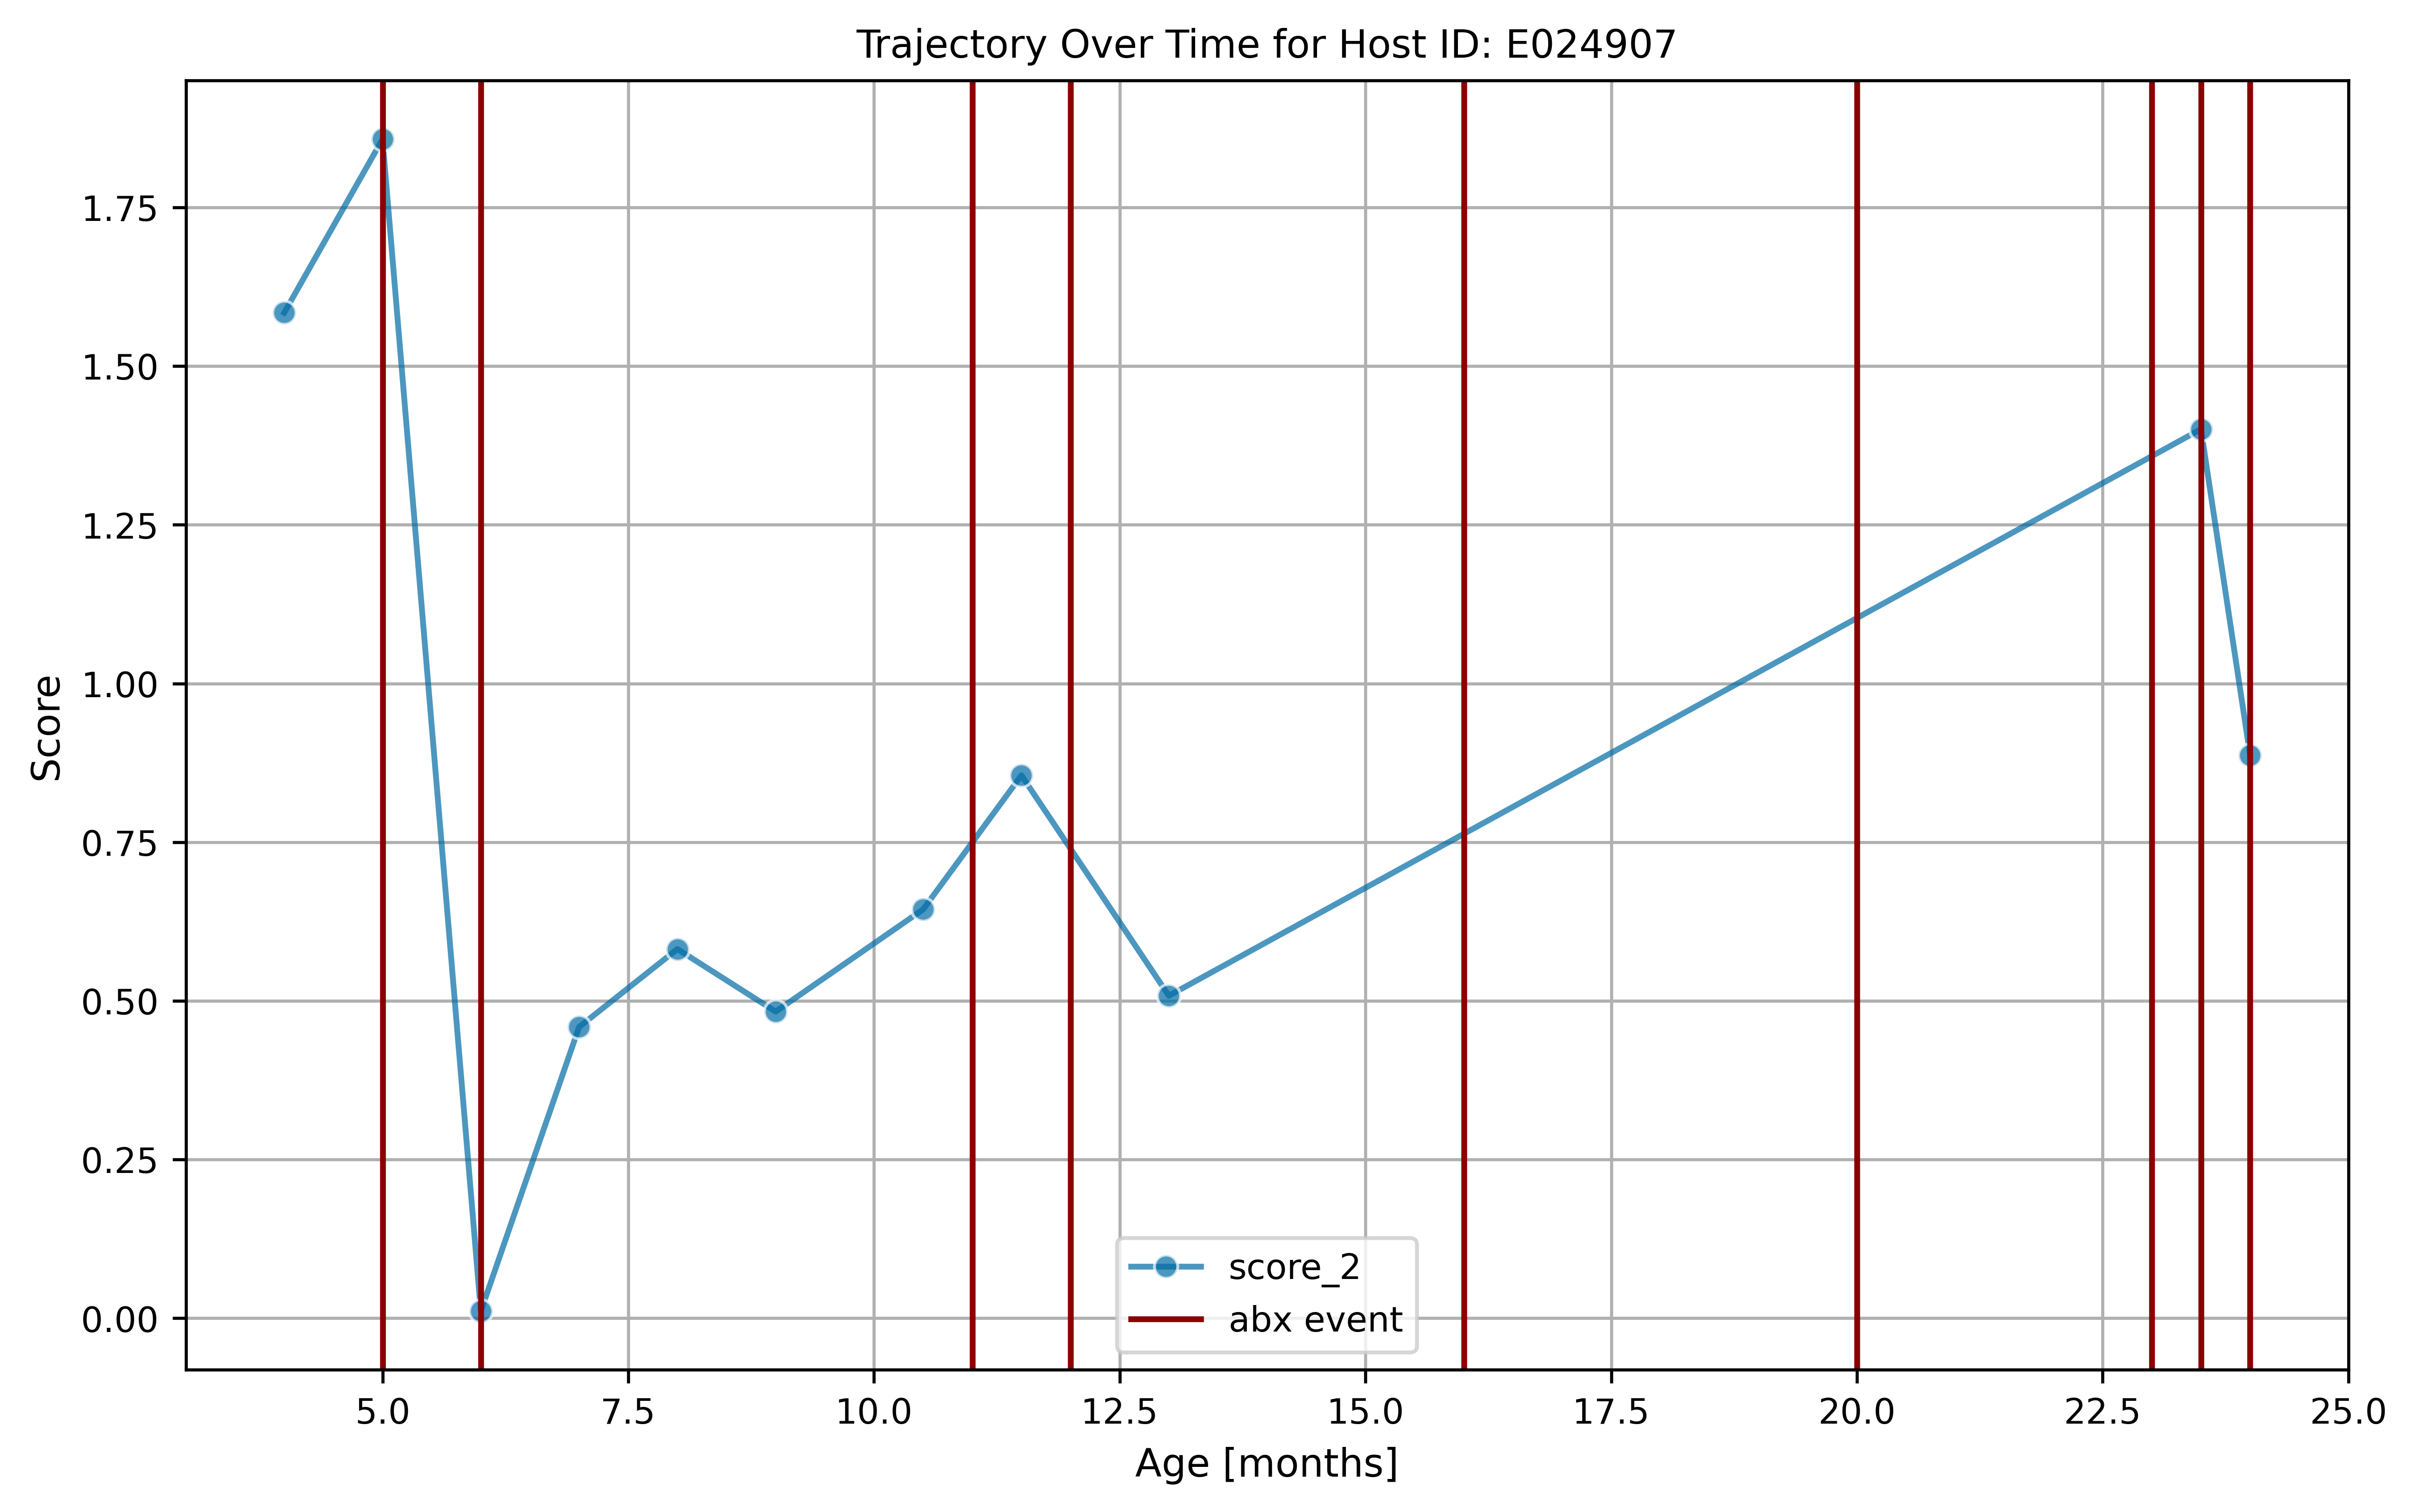

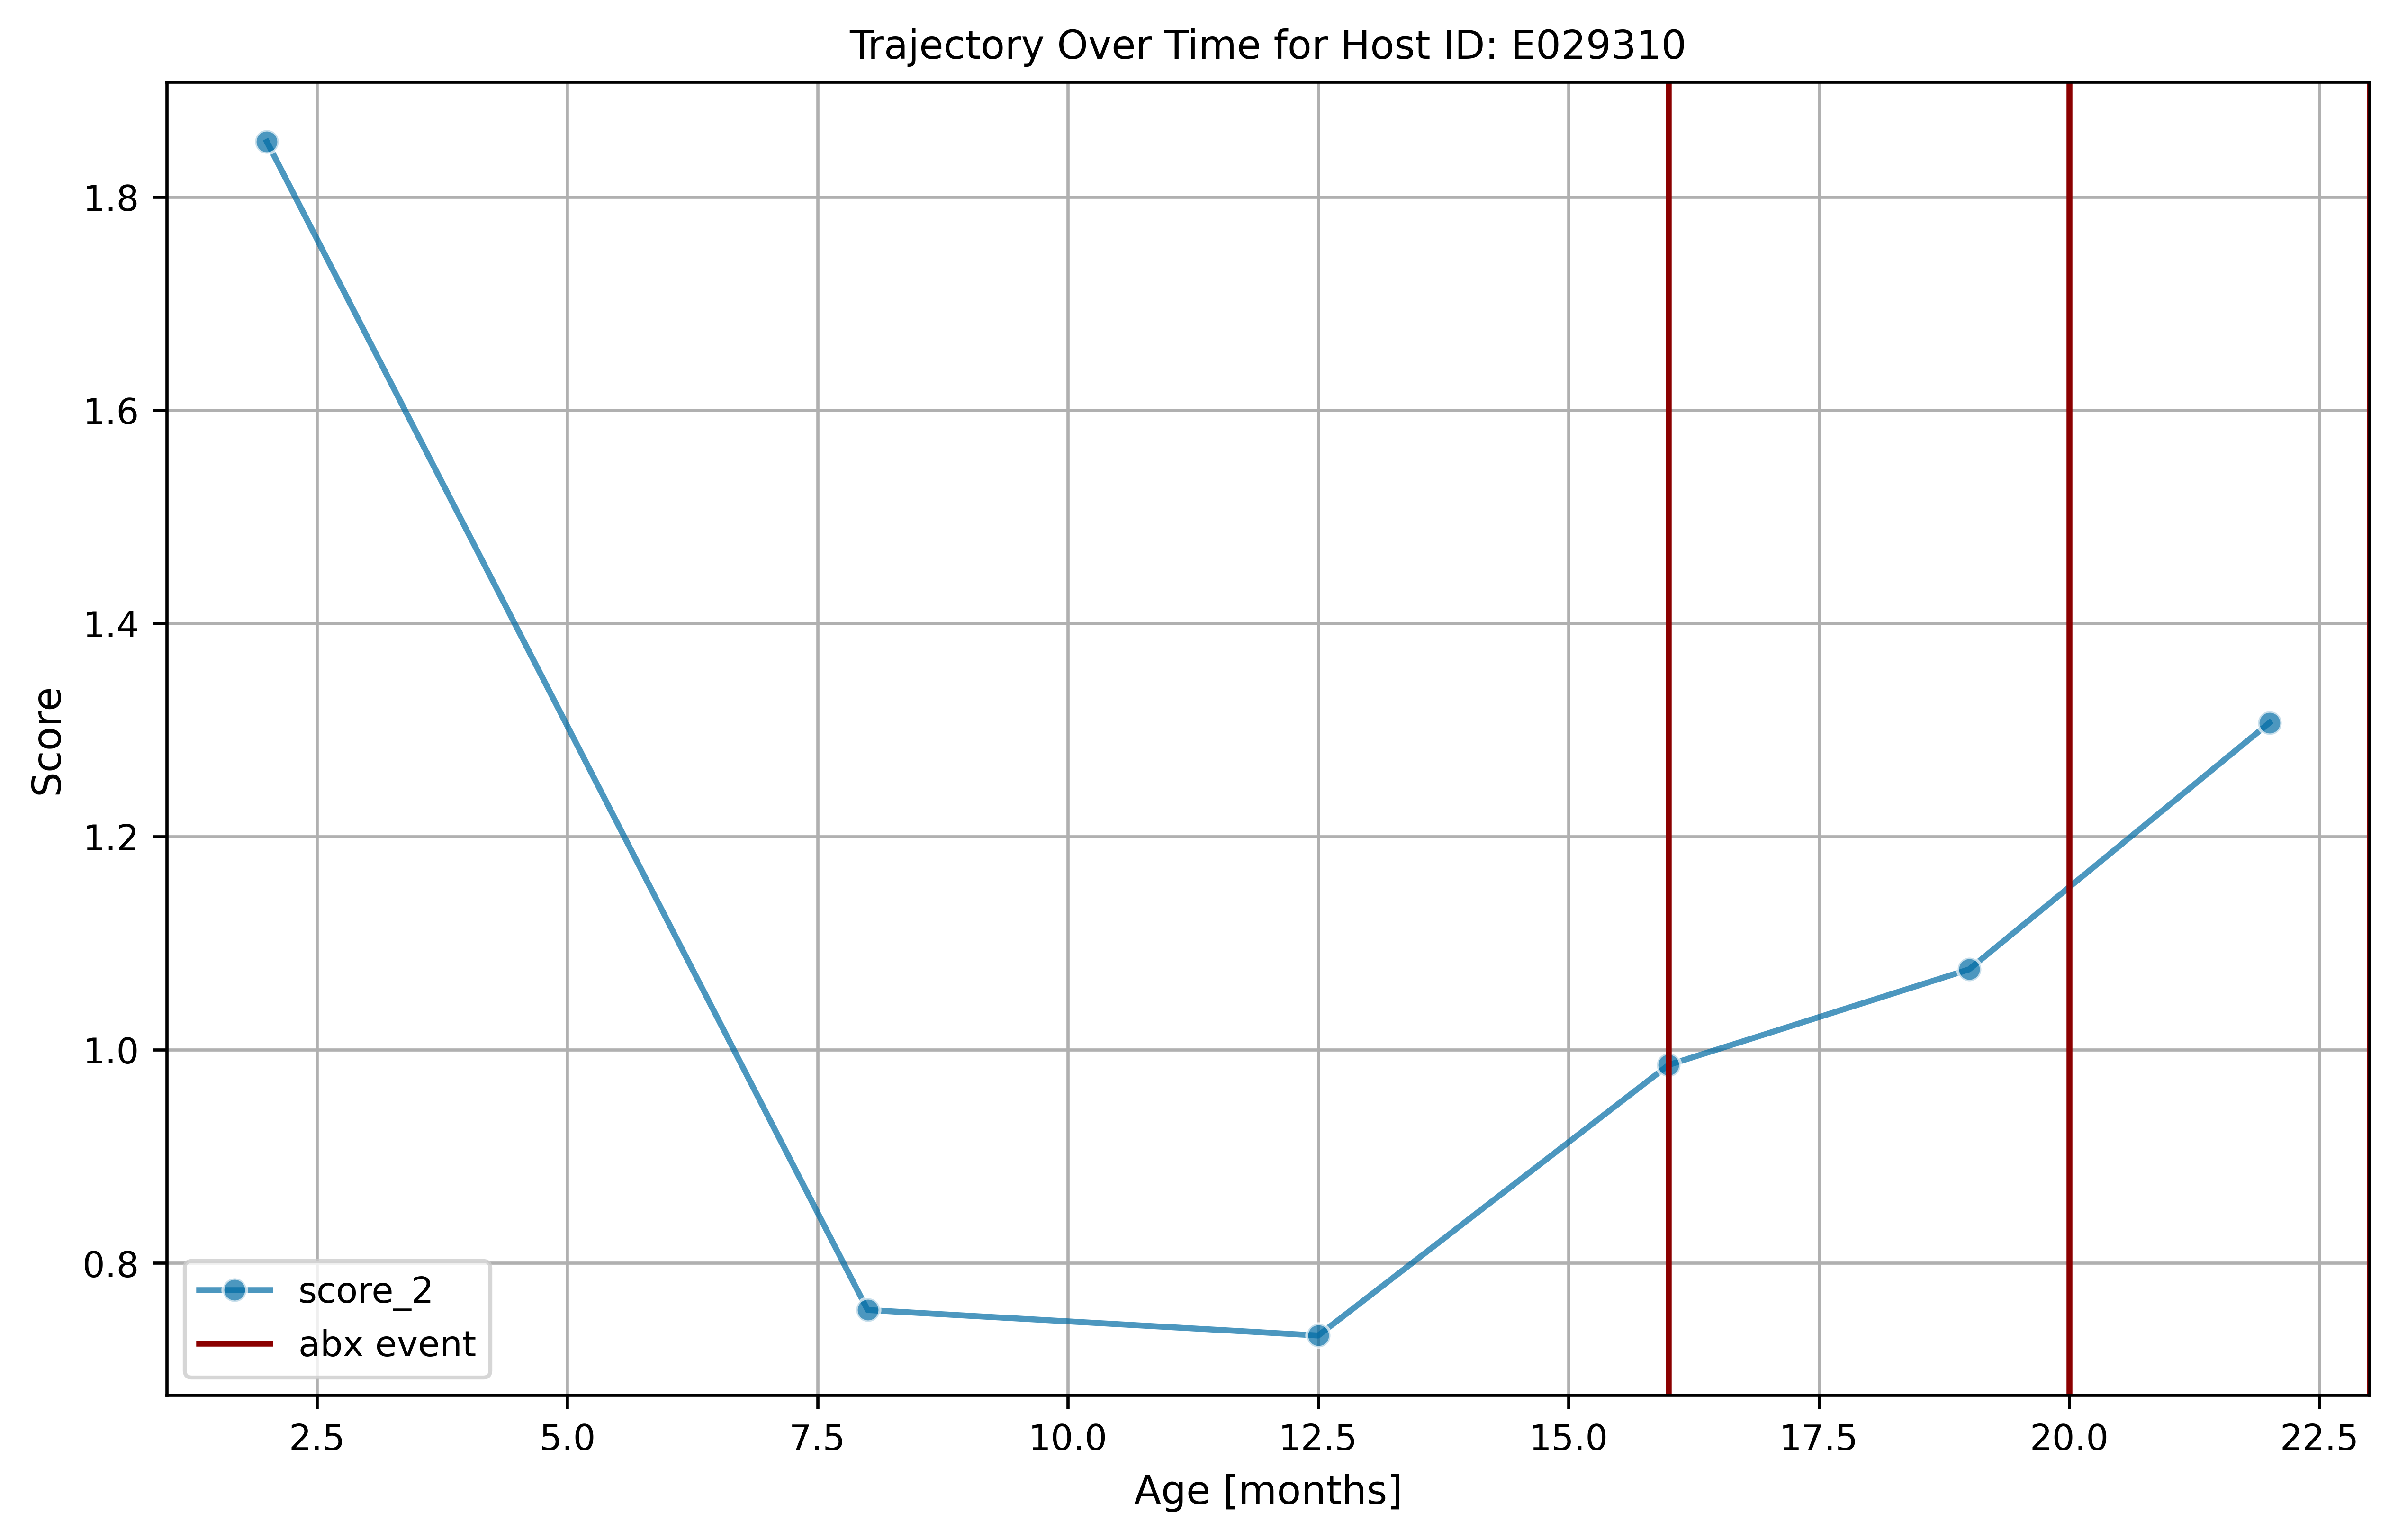

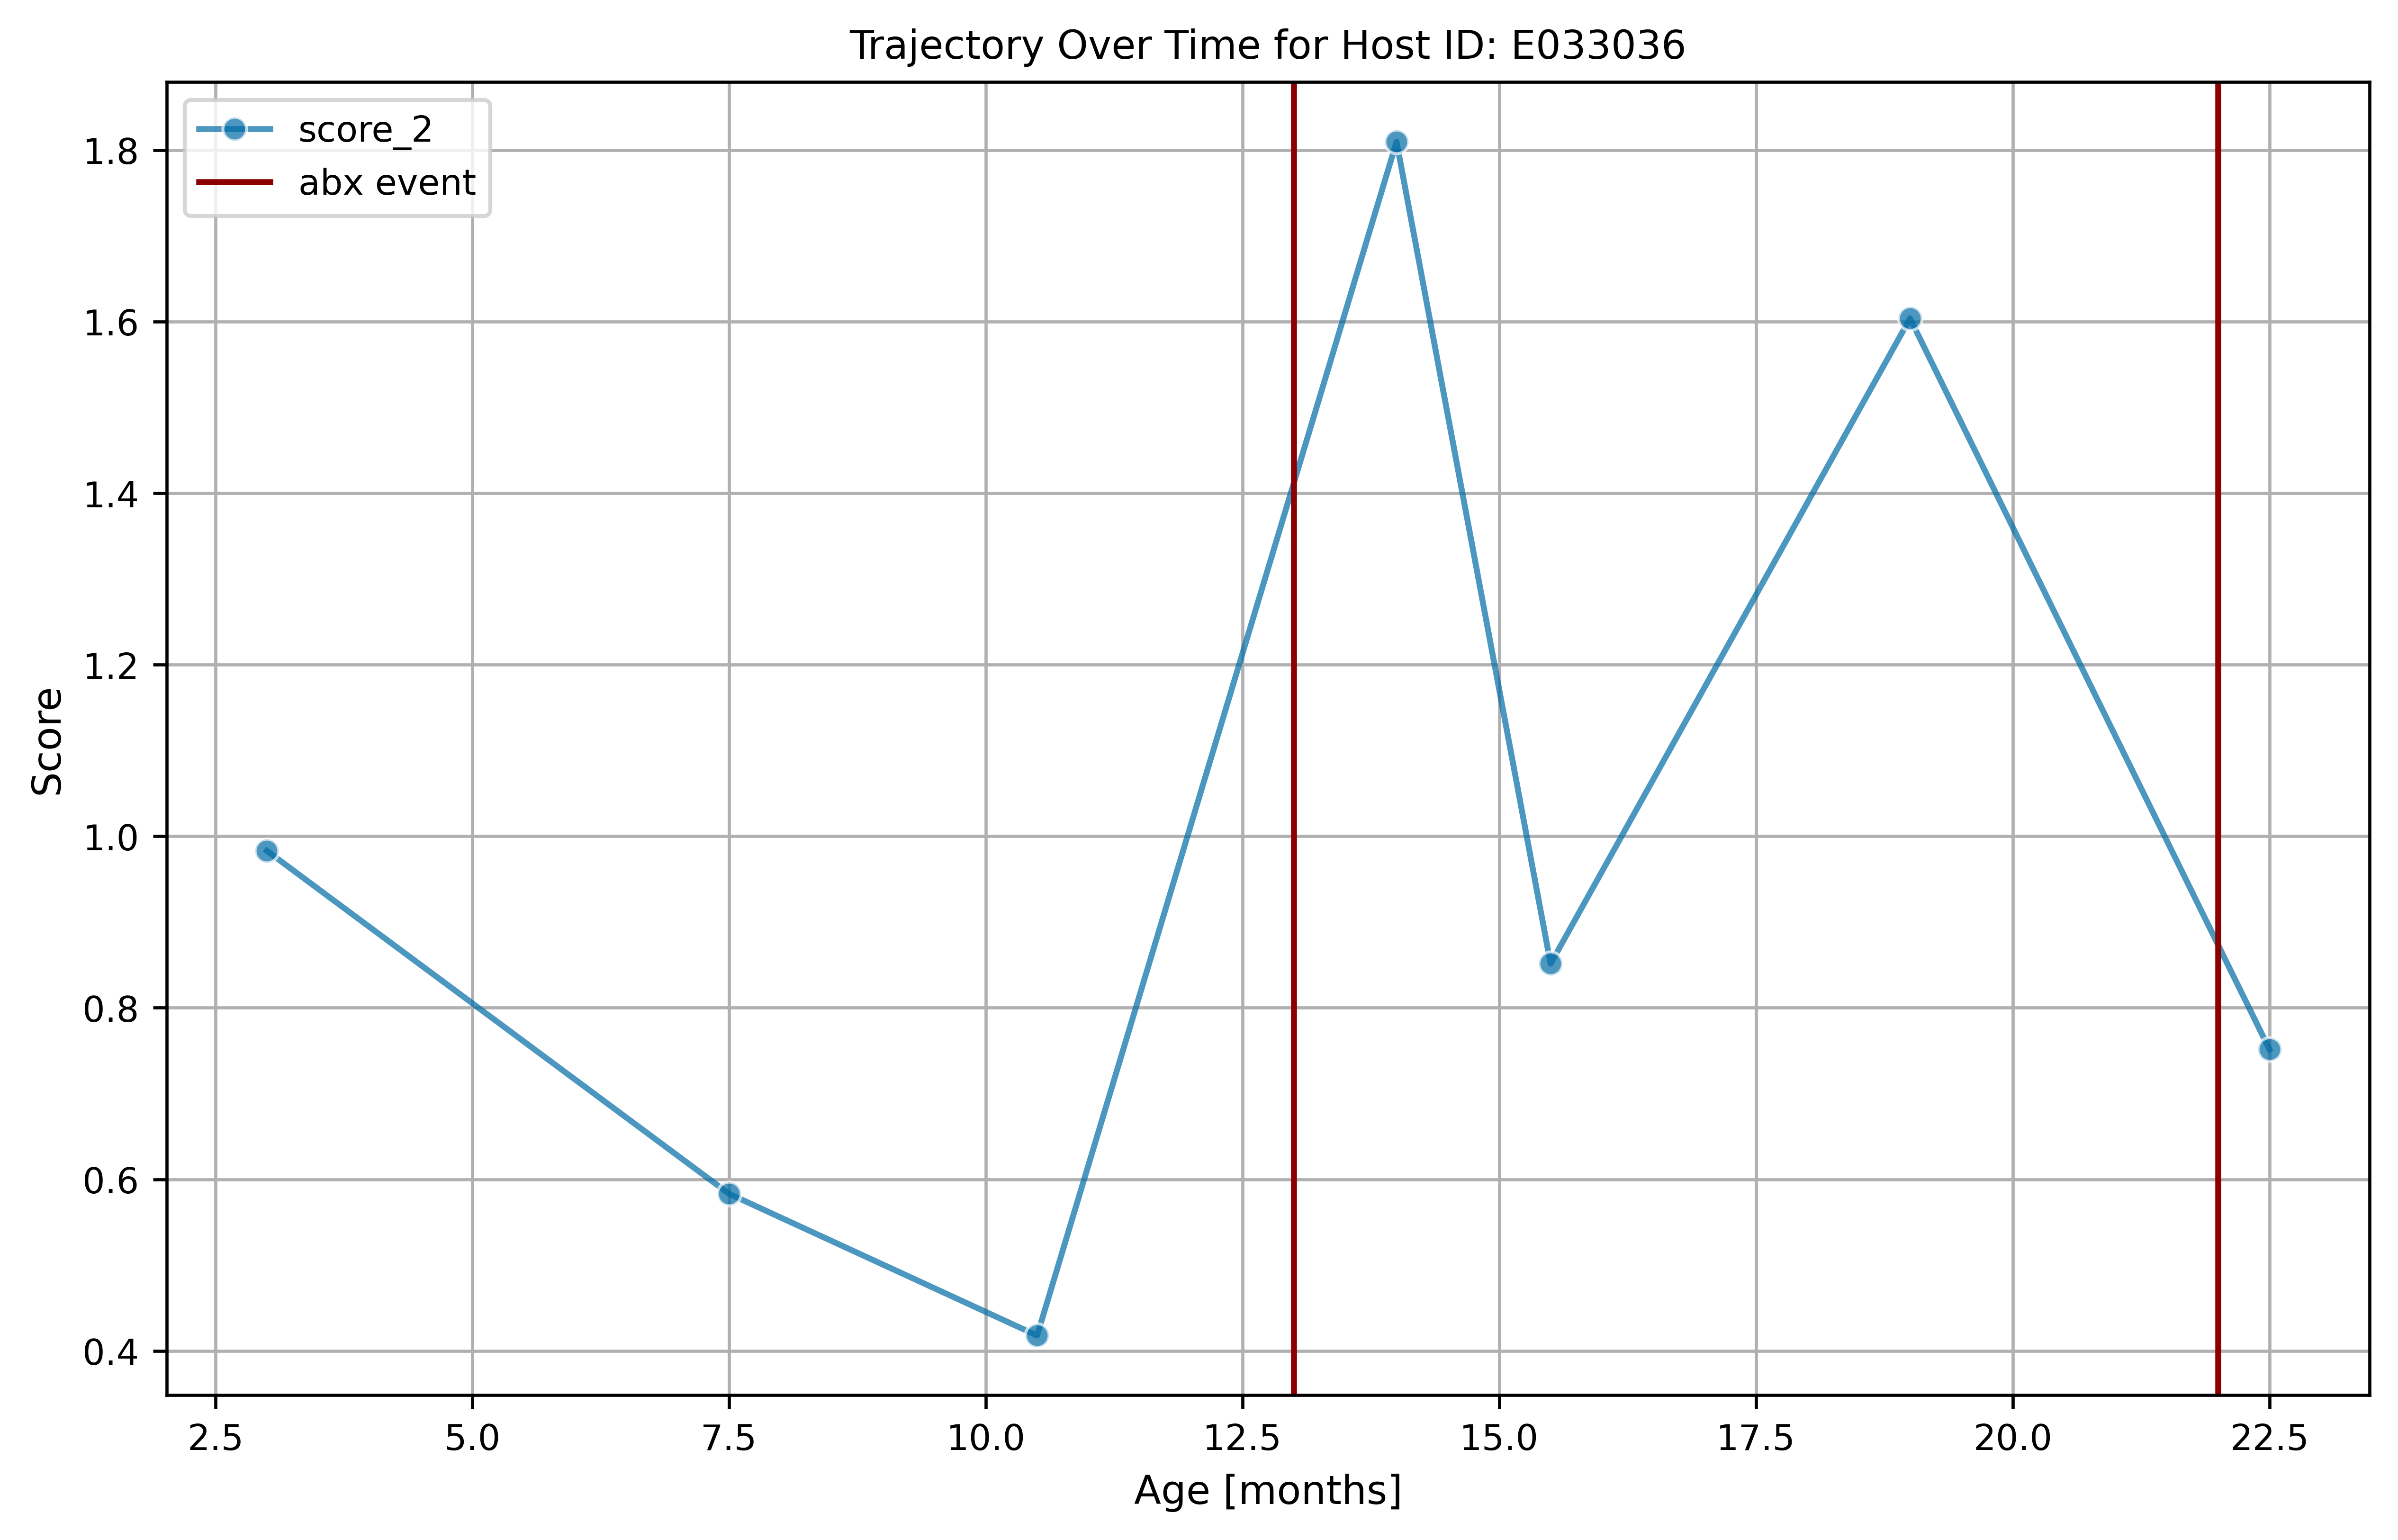

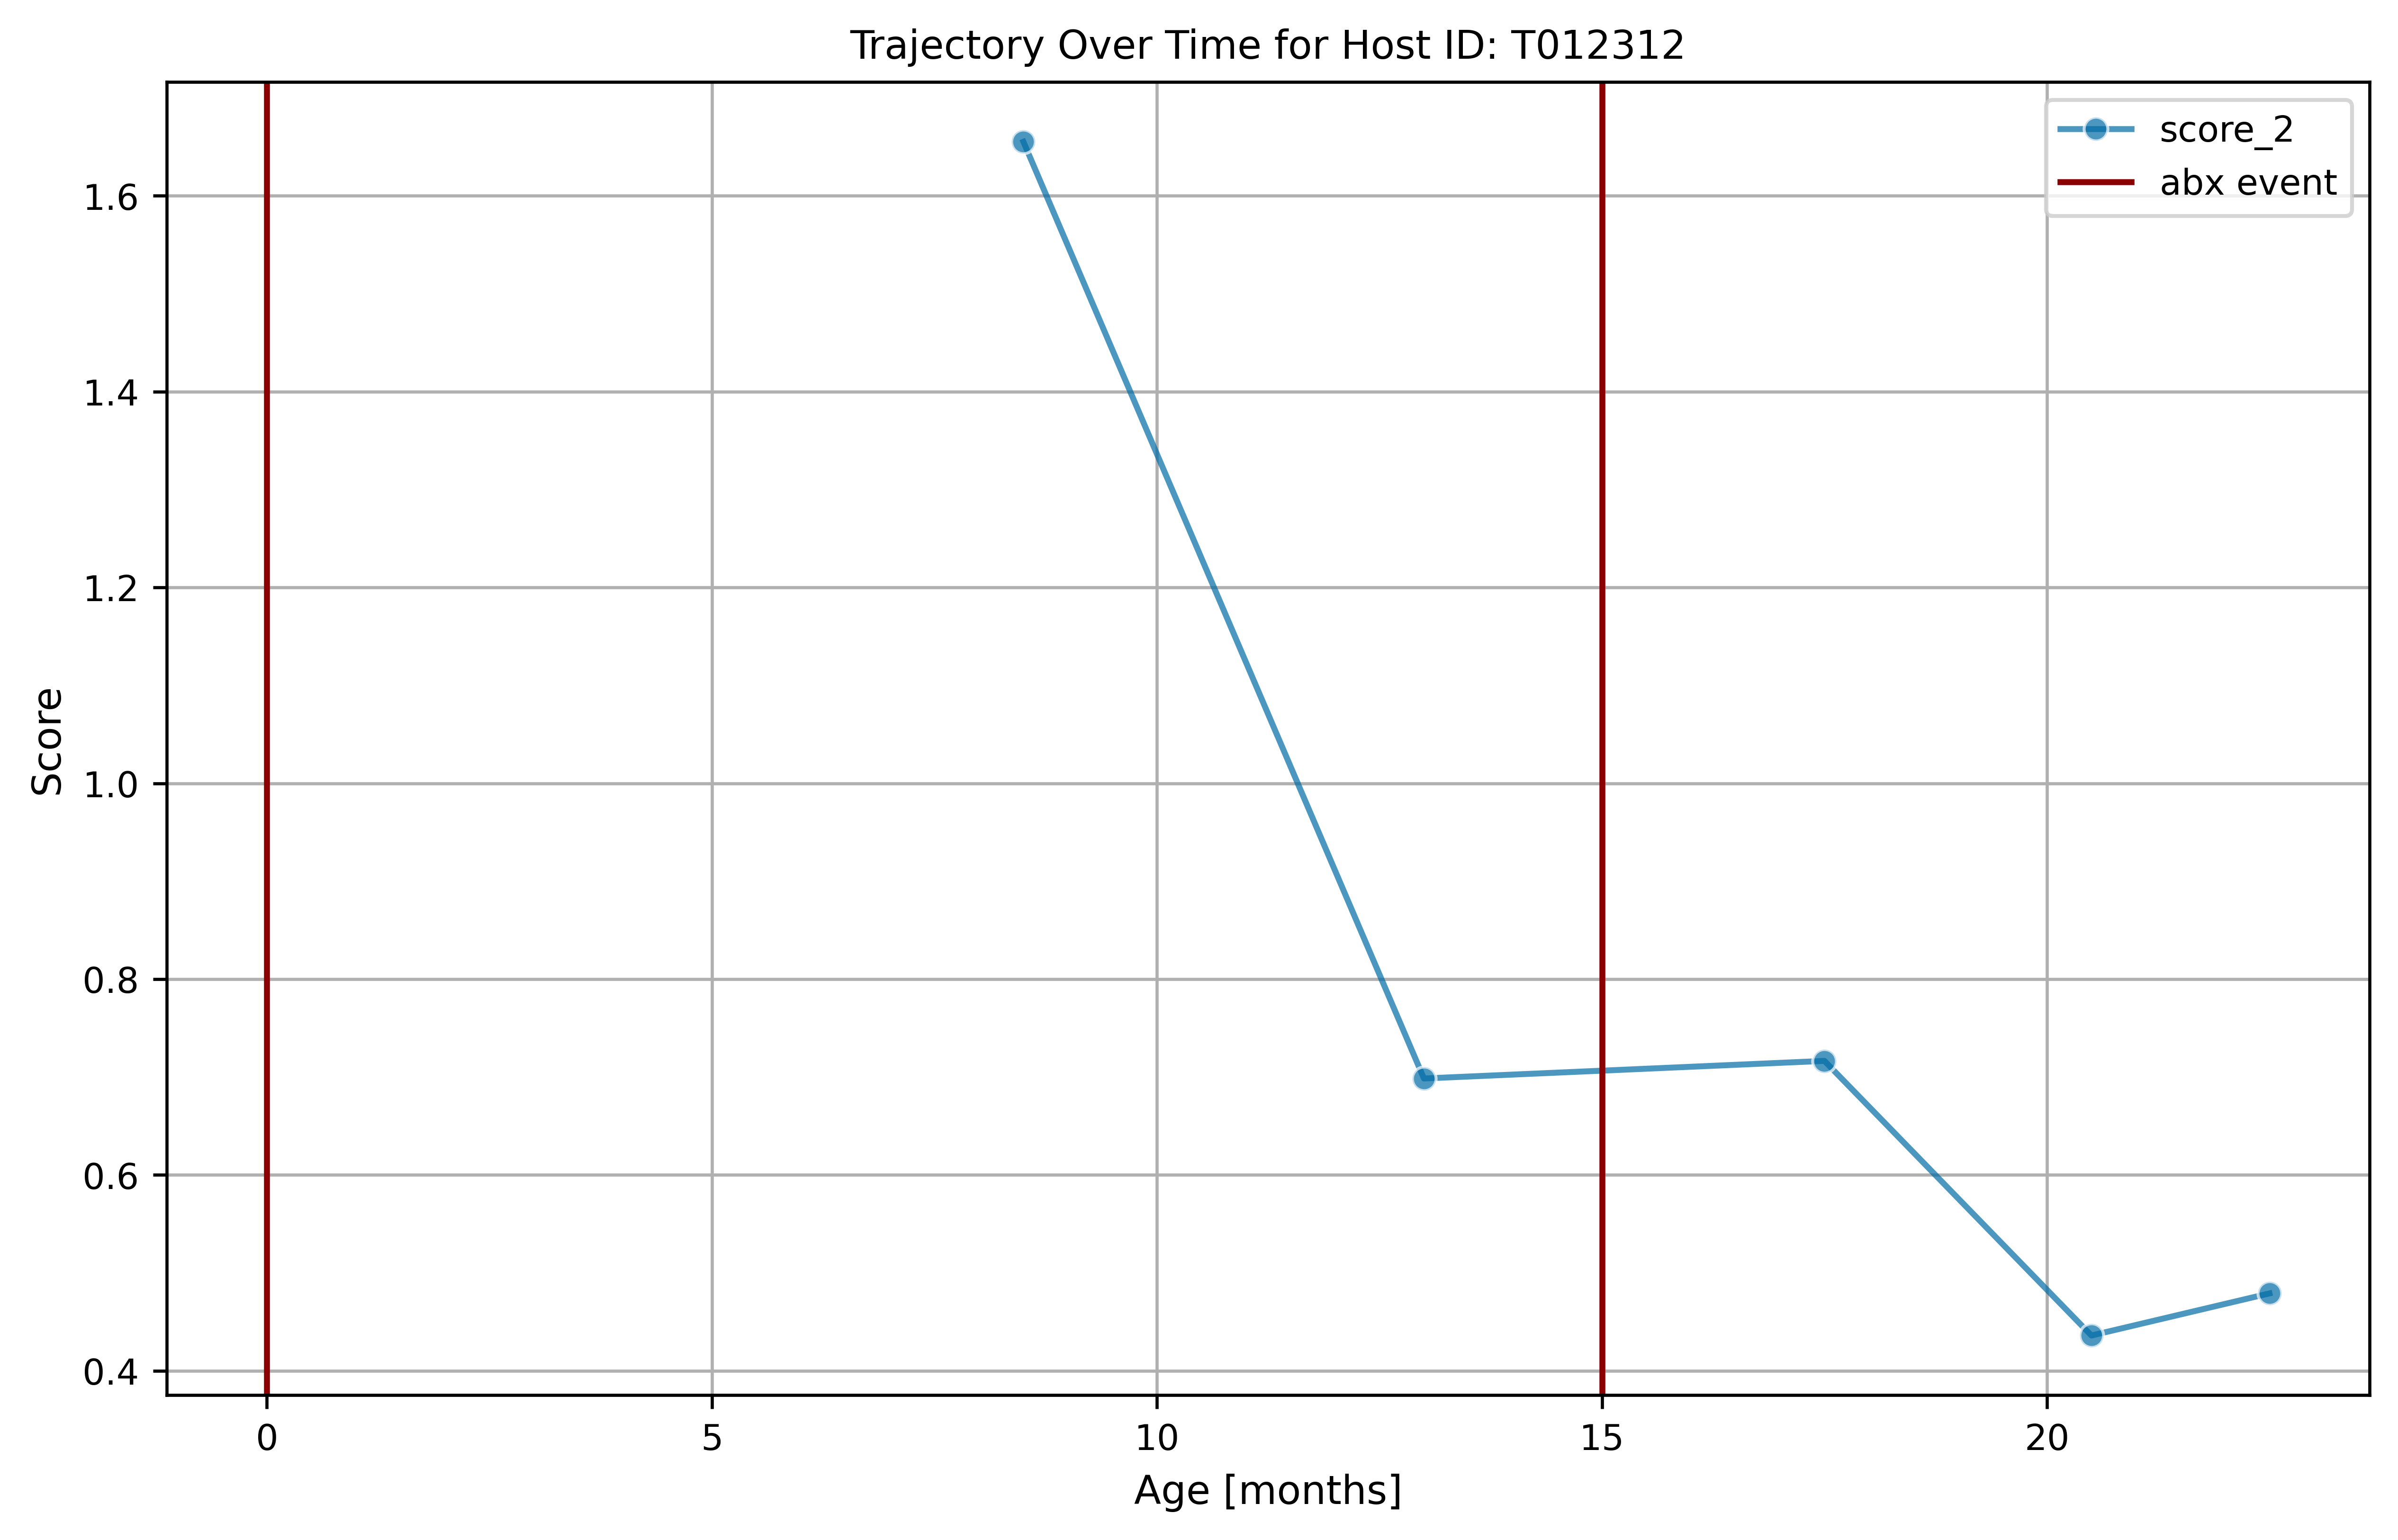

In [18]:
# plot individual trajectories for infants with increased scores prior to abx exposure:

infants_w_no_increase = rel_no_increase["host_id"].unique().tolist()

for infant in infants_w_no_increase:
    plot_trajectory(
        abx_scores_flat,
        abx_events,
        infant,
        [f"score_{n}"],
        path_to_output=None,
        flag=f"score_{n}",
    )